In [1]:
# Validation of the steady-state simulation - Case 1: MLP with Optimal settings
## Optimal Settings are like below:
# 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
# 2. Cd scaling -> replaced as normalization for both Cl and Cd
# 3. Seperate the ML models into the two models, a model only for Cl and the other for Cd
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 + 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 1000 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

h = h[1:]

In [5]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [6]:
t_interval = 0.001
t_len = int((15-10) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [8]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-4],] + cm_target[:-4] + cm_target[-3:]

In [9]:
cm_target

['NACA0018cm_blade1.csv',
 'case1cm_blade1.csv',
 'case2cm_blade1.csv',
 'case4cm_blade1.csv',
 'case5cm_blade1.csv',
 'case7cm_blade1.csv',
 'case8cm_blade1.csv',
 'case13cm_blade1.csv',
 'case14cm_blade1.csv',
 'case15cm_blade1.csv',
 'case16cm_blade1.csv',
 'case17cm_blade1.csv',
 'case18cm_blade1.csv',
 'case19cm_blade1.csv',
 'case20cm_blade1.csv',
 'case21cm_blade1.csv']

In [10]:
# del cm_target[1,2,7,10,13]
del cm_target[13]
del cm_target[10]
del cm_target[7]
del cm_target[1:3]
del cm_target[0]

In [11]:
cm_target

['case4cm_blade1.csv',
 'case5cm_blade1.csv',
 'case7cm_blade1.csv',
 'case8cm_blade1.csv',
 'case14cm_blade1.csv',
 'case15cm_blade1.csv',
 'case17cm_blade1.csv',
 'case18cm_blade1.csv',
 'case20cm_blade1.csv',
 'case21cm_blade1.csv']

In [12]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    hh = generate_h(n_beta, t_len, normalize)
    bb = generate_beta(n_beta, t_len, normalize)
#     total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    #x = np.hstack((t, hh, bb, total_coords))
    #x = np.hstack((t, total_coords))
    #x = t
    x = np.hstack((t, hh, bb))
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x: ", x.shape)
    print("Dimension - y: ", y.shape)
    
    return x, y, t, cm

In [13]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=10, time<15))]
        cm_beUsed = cm[np.where(np.logical_and(time>=10, time<15))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 15, t_interval).reshape((-1,1))
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and Cm: ", input_time_cm.shape)
    return input_time_cm

In [14]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [15]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>0.3:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [16]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

#     beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = np.vstack((bb_imp, bb_imp))
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [17]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    #hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = np.concatenate((h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len)))
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [18]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    
    baseline_coord_high = data.iloc[0,:]
    baseline_coord_low = data.iloc[1,:]
    baseline_coord = np.hstack((np.flip(baseline_coord_high), baseline_coord_low)).reshape((1,-1))
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [19]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j in range(n_beta):
            betaValue = beta[j]

            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords2 = np.zeros((n_cases, 10))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [20]:
# Generating x, y and cm (for denormalizing)
x, y, t, cm = genereate_input_output(cm_target, n_beta, t_len, normalize=True)

Dimension - time and Cm:  (50000, 2)
Dimension - heights of Gurney flaps:  (50000, 1)
Dimension - inclination(beta):  (50000, 1)
Dimension - x:  (50000, 3)
Dimension - y:  (50000, 1)


In [21]:
x -=10

In [22]:
def dataset_split(x, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, y_all, y_test, cm_all, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_train, x_val, y_train, y_val, cm_train, cm_val = train_test_split(x_all, y_all, cm_all, test_size=val_rate/(1-test_rate),
                                                                            random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_train, x_test, y_train, y_test, cm_train, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test, cm_train, cm_test

In [23]:
x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x, y, cm,
                                                                                          test_rate, val_rate=val_rate,
                                                                                          validation=True, random_state=50)

In [24]:
def make_mlp_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_data = tf.keras.Input(shape=3)

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                #kernel_initializer='he_uniform',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(input_data)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     #kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       #kernel_initializer='he_uniform',
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model(input_data, output_data)
    
    return model

In [25]:
model = make_mlp_model(num_layer=n_layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 fc1 (Dense)                 (None, 256)               1024      
                                                                 
 fc2 (Dense)                 (None, 256)               65792     
                                                                 
 fc3 (Dense)                 (None, 256)               65792     
                                                                 
 fc4 (Dense)                 (None, 256)               65792     
                                                                 
 fc5 (Dense)                 (None, 256)               65792     
                                                                 
 outputLayer (Dense)         (None, 1)                 257   

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [27]:
model_directory = "D:\\TrainedModels\\20221229\\10h"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [28]:
ckpt_name = model_directory + "20221229unsteadyPrediction_MLP_10h_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_layers)+"layers_"+ str(n_units) +"units_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, min_delta=1e-06,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, factor=0.5,
                                          min_delta = 1e-6, min_lr=1e-06, verbose=1)

In [29]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [30]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=[x_val, y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
28/35 [=======================>......] - ETA: 0s - loss: 0.0614 - rmse: 0.2475
Epoch 1: val_loss improved from inf to 0.06005, saving model to D:\TrainedModels\20221229\10h20221229unsteadyPrediction_MLP_10h_val_0.2_test0.1_5layers_256units_checkpoint.h5
35/35 [==============================] - 2s 14ms/step - loss: 0.0607 - rmse: 0.2461 - val_loss: 0.0601 - val_rmse: 0.2448 - lr: 1.0000e-04
Epoch 2/10000
27/35 [======================>.......] - ETA: 0s - loss: 0.0590 - rmse: 0.2427
Epoch 2: val_loss improved from 0.06005 to 0.05992, saving model to D:\TrainedModels\20221229\10h20221229unsteadyPrediction_MLP_10h_val_0.2_test0.1_5layers_256units_checkpoint.h5
35/35 [==============================] - 0s 7ms/step - loss: 0.0588 - rmse: 0.2423 - val_loss: 0.0599 - val_rmse: 0.2446 - lr: 1.0000e-04
Epoch 3/10000
27/35 [======================>.......] - ETA: 0s - loss: 0.0588 - rmse: 0.2424
Epoch 3: val_loss improved from 0.05992 to 0.05990, saving model to D:\TrainedModels\20221

35/35 [==============================] - 0s 8ms/step - loss: 0.0542 - rmse: 0.2327 - val_loss: 0.0542 - val_rmse: 0.2325 - lr: 1.0000e-04
Epoch 23/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0534 - rmse: 0.2309
Epoch 23: val_loss improved from 0.05416 to 0.05360, saving model to D:\TrainedModels\20221229\10h20221229unsteadyPrediction_MLP_10h_val_0.2_test0.1_5layers_256units_checkpoint.h5
35/35 [==============================] - 0s 9ms/step - loss: 0.0534 - rmse: 0.2309 - val_loss: 0.0536 - val_rmse: 0.2313 - lr: 1.0000e-04
Epoch 24/10000
28/35 [=======================>......] - ETA: 0s - loss: 0.0526 - rmse: 0.2291
Epoch 24: val_loss improved from 0.05360 to 0.05250, saving model to D:\TrainedModels\20221229\10h20221229unsteadyPrediction_MLP_10h_val_0.2_test0.1_5layers_256units_checkpoint.h5
35/35 [==============================] - 0s 9ms/step - loss: 0.0522 - rmse: 0.2283 - val_loss: 0.0525 - val_rmse: 0.2289 - lr: 1.0000e-04
Epoch 25/10000
29/35 [================

35/35 [==============================] - 0s 9ms/step - loss: 0.0354 - rmse: 0.1878 - val_loss: 0.0354 - val_rmse: 0.1880 - lr: 1.0000e-04
Epoch 44/10000
28/35 [=======================>......] - ETA: 0s - loss: 0.0357 - rmse: 0.1886
Epoch 44: val_loss improved from 0.03541 to 0.03491, saving model to D:\TrainedModels\20221229\10h20221229unsteadyPrediction_MLP_10h_val_0.2_test0.1_5layers_256units_checkpoint.h5
35/35 [==============================] - 0s 9ms/step - loss: 0.0355 - rmse: 0.1882 - val_loss: 0.0349 - val_rmse: 0.1866 - lr: 1.0000e-04
Epoch 45/10000
28/35 [=======================>......] - ETA: 0s - loss: 0.0342 - rmse: 0.1846
Epoch 45: val_loss improved from 0.03491 to 0.03420, saving model to D:\TrainedModels\20221229\10h20221229unsteadyPrediction_MLP_10h_val_0.2_test0.1_5layers_256units_checkpoint.h5
35/35 [==============================] - 0s 9ms/step - loss: 0.0340 - rmse: 0.1841 - val_loss: 0.0342 - val_rmse: 0.1847 - lr: 1.0000e-04
Epoch 46/10000
28/35 [================

35/35 [==============================] - 0s 9ms/step - loss: 0.0241 - rmse: 0.1550 - val_loss: 0.0237 - val_rmse: 0.1539 - lr: 1.0000e-04
Epoch 67/10000
28/35 [=======================>......] - ETA: 0s - loss: 0.0241 - rmse: 0.1549
Epoch 67: val_loss improved from 0.02375 to 0.02374, saving model to D:\TrainedModels\20221229\10h20221229unsteadyPrediction_MLP_10h_val_0.2_test0.1_5layers_256units_checkpoint.h5
35/35 [==============================] - 0s 9ms/step - loss: 0.0241 - rmse: 0.1549 - val_loss: 0.0237 - val_rmse: 0.1538 - lr: 1.0000e-04
Epoch 68/10000
28/35 [=======================>......] - ETA: 0s - loss: 0.0238 - rmse: 0.1539
Epoch 68: val_loss did not improve from 0.02374
35/35 [==============================] - 0s 7ms/step - loss: 0.0238 - rmse: 0.1539 - val_loss: 0.0255 - val_rmse: 0.1596 - lr: 1.0000e-04
Epoch 69/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0237 - rmse: 0.1536
Epoch 69: val_loss improved from 0.02374 to 0.02307, saving model to D:\Trai

35/35 [==============================] - 0s 8ms/step - loss: 0.0193 - rmse: 0.1385 - val_loss: 0.0190 - val_rmse: 0.1376 - lr: 1.0000e-04
Epoch 91/10000
34/35 [============================>.] - ETA: 0s - loss: 0.0192 - rmse: 0.1384
Epoch 91: val_loss did not improve from 0.01900
35/35 [==============================] - 0s 8ms/step - loss: 0.0192 - rmse: 0.1384 - val_loss: 0.0208 - val_rmse: 0.1441 - lr: 1.0000e-04
Epoch 92/10000
33/35 [===========================>..] - ETA: 0s - loss: 0.0195 - rmse: 0.1395
Epoch 92: val_loss improved from 0.01900 to 0.01862, saving model to D:\TrainedModels\20221229\10h20221229unsteadyPrediction_MLP_10h_val_0.2_test0.1_5layers_256units_checkpoint.h5
35/35 [==============================] - 0s 10ms/step - loss: 0.0195 - rmse: 0.1394 - val_loss: 0.0186 - val_rmse: 0.1362 - lr: 1.0000e-04
Epoch 93/10000
28/35 [=======================>......] - ETA: 0s - loss: 0.0191 - rmse: 0.1378
Epoch 93: val_loss did not improve from 0.01862
35/35 [====================

35/35 [==============================] - 0s 9ms/step - loss: 0.0179 - rmse: 0.1335 - val_loss: 0.0169 - val_rmse: 0.1299 - lr: 1.0000e-04
Epoch 117/10000
28/35 [=======================>......] - ETA: 0s - loss: 0.0169 - rmse: 0.1298
Epoch 117: val_loss did not improve from 0.01694
35/35 [==============================] - 0s 7ms/step - loss: 0.0169 - rmse: 0.1299 - val_loss: 0.0170 - val_rmse: 0.1302 - lr: 1.0000e-04
Epoch 118/10000
28/35 [=======================>......] - ETA: 0s - loss: 0.0170 - rmse: 0.1303
Epoch 118: val_loss improved from 0.01694 to 0.01683, saving model to D:\TrainedModels\20221229\10h20221229unsteadyPrediction_MLP_10h_val_0.2_test0.1_5layers_256units_checkpoint.h5
35/35 [==============================] - 0s 9ms/step - loss: 0.0170 - rmse: 0.1300 - val_loss: 0.0168 - val_rmse: 0.1295 - lr: 1.0000e-04
Epoch 119/10000
28/35 [=======================>......] - ETA: 0s - loss: 0.0172 - rmse: 0.1309
Epoch 119: val_loss did not improve from 0.01683
35/35 [===============

29/35 [=======================>......] - ETA: 0s - loss: 0.0162 - rmse: 0.1270
Epoch 143: val_loss did not improve from 0.01572
35/35 [==============================] - 0s 7ms/step - loss: 0.0163 - rmse: 0.1276 - val_loss: 0.0170 - val_rmse: 0.1301 - lr: 1.0000e-04
Epoch 144/10000
28/35 [=======================>......] - ETA: 0s - loss: 0.0163 - rmse: 0.1274
Epoch 144: val_loss did not improve from 0.01572
35/35 [==============================] - 0s 7ms/step - loss: 0.0162 - rmse: 0.1270 - val_loss: 0.0167 - val_rmse: 0.1290 - lr: 1.0000e-04
Epoch 145/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0164 - rmse: 0.1277
Epoch 145: val_loss did not improve from 0.01572
35/35 [==============================] - 0s 7ms/step - loss: 0.0162 - rmse: 0.1272 - val_loss: 0.0157 - val_rmse: 0.1252 - lr: 1.0000e-04
Epoch 146/10000
28/35 [=======================>......] - ETA: 0s - loss: 0.0158 - rmse: 0.1257
Epoch 146: val_loss improved from 0.01572 to 0.01527, saving model to D:\Tr

Epoch 170/10000
28/35 [=======================>......] - ETA: 0s - loss: 0.0153 - rmse: 0.1234
Epoch 170: val_loss did not improve from 0.01460
35/35 [==============================] - 0s 7ms/step - loss: 0.0152 - rmse: 0.1230 - val_loss: 0.0148 - val_rmse: 0.1214 - lr: 1.0000e-04
Epoch 171/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0152 - rmse: 0.1231
Epoch 171: val_loss did not improve from 0.01460
35/35 [==============================] - 0s 7ms/step - loss: 0.0153 - rmse: 0.1234 - val_loss: 0.0148 - val_rmse: 0.1215 - lr: 1.0000e-04
Epoch 172/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0149 - rmse: 0.1220
Epoch 172: val_loss did not improve from 0.01460
35/35 [==============================] - 0s 7ms/step - loss: 0.0150 - rmse: 0.1225 - val_loss: 0.0158 - val_rmse: 0.1255 - lr: 1.0000e-04
Epoch 173/10000
30/35 [========================>.....] - ETA: 0s - loss: 0.0153 - rmse: 0.1235
Epoch 173: val_loss did not improve from 0.01460
35/35 [===

28/35 [=======================>......] - ETA: 0s - loss: 0.0142 - rmse: 0.1191
Epoch 197: val_loss improved from 0.01393 to 0.01364, saving model to D:\TrainedModels\20221229\10h20221229unsteadyPrediction_MLP_10h_val_0.2_test0.1_5layers_256units_checkpoint.h5
35/35 [==============================] - 0s 9ms/step - loss: 0.0142 - rmse: 0.1188 - val_loss: 0.0136 - val_rmse: 0.1166 - lr: 1.0000e-04
Epoch 198/10000
28/35 [=======================>......] - ETA: 0s - loss: 0.0141 - rmse: 0.1185
Epoch 198: val_loss did not improve from 0.01364
35/35 [==============================] - 0s 7ms/step - loss: 0.0142 - rmse: 0.1190 - val_loss: 0.0151 - val_rmse: 0.1226 - lr: 1.0000e-04
Epoch 199/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0145 - rmse: 0.1202
Epoch 199: val_loss did not improve from 0.01364
35/35 [==============================] - 0s 7ms/step - loss: 0.0145 - rmse: 0.1203 - val_loss: 0.0146 - val_rmse: 0.1206 - lr: 1.0000e-04
Epoch 200/10000
28/35 [===============

Epoch 224/10000
28/35 [=======================>......] - ETA: 0s - loss: 0.0137 - rmse: 0.1170
Epoch 224: val_loss did not improve from 0.01300
35/35 [==============================] - 0s 7ms/step - loss: 0.0138 - rmse: 0.1173 - val_loss: 0.0132 - val_rmse: 0.1149 - lr: 1.0000e-04
Epoch 225/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0138 - rmse: 0.1172
Epoch 225: val_loss did not improve from 0.01300
35/35 [==============================] - 0s 7ms/step - loss: 0.0138 - rmse: 0.1173 - val_loss: 0.0157 - val_rmse: 0.1251 - lr: 1.0000e-04
Epoch 226/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0144 - rmse: 0.1197
Epoch 226: val_loss improved from 0.01300 to 0.01297, saving model to D:\TrainedModels\20221229\10h20221229unsteadyPrediction_MLP_10h_val_0.2_test0.1_5layers_256units_checkpoint.h5
35/35 [==============================] - 0s 9ms/step - loss: 0.0142 - rmse: 0.1191 - val_loss: 0.0130 - val_rmse: 0.1137 - lr: 1.0000e-04
Epoch 227/10000
29/35 

30/35 [========================>.....] - ETA: 0s - loss: 0.0131 - rmse: 0.1143
Epoch 250: val_loss did not improve from 0.01255
35/35 [==============================] - 0s 7ms/step - loss: 0.0132 - rmse: 0.1148 - val_loss: 0.0135 - val_rmse: 0.1160 - lr: 1.0000e-04
Epoch 251/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0129 - rmse: 0.1132
Epoch 251: val_loss did not improve from 0.01255
35/35 [==============================] - 0s 7ms/step - loss: 0.0129 - rmse: 0.1135 - val_loss: 0.0128 - val_rmse: 0.1129 - lr: 1.0000e-04
Epoch 252/10000
30/35 [========================>.....] - ETA: 0s - loss: 0.0127 - rmse: 0.1124
Epoch 252: val_loss improved from 0.01255 to 0.01225, saving model to D:\TrainedModels\20221229\10h20221229unsteadyPrediction_MLP_10h_val_0.2_test0.1_5layers_256units_checkpoint.h5
35/35 [==============================] - 0s 8ms/step - loss: 0.0128 - rmse: 0.1129 - val_loss: 0.0122 - val_rmse: 0.1105 - lr: 1.0000e-04
Epoch 253/10000
28/35 [===============

30/35 [========================>.....] - ETA: 0s - loss: 0.0120 - rmse: 0.1095
Epoch 276: val_loss did not improve from 0.01173
35/35 [==============================] - 0s 7ms/step - loss: 0.0120 - rmse: 0.1095 - val_loss: 0.0120 - val_rmse: 0.1091 - lr: 1.0000e-04
Epoch 277/10000
30/35 [========================>.....] - ETA: 0s - loss: 0.0121 - rmse: 0.1098
Epoch 277: val_loss did not improve from 0.01173
35/35 [==============================] - 0s 7ms/step - loss: 0.0122 - rmse: 0.1102 - val_loss: 0.0131 - val_rmse: 0.1141 - lr: 1.0000e-04
Epoch 278/10000
28/35 [=======================>......] - ETA: 0s - loss: 0.0119 - rmse: 0.1091
Epoch 278: val_loss did not improve from 0.01173
35/35 [==============================] - 0s 7ms/step - loss: 0.0123 - rmse: 0.1105 - val_loss: 0.0130 - val_rmse: 0.1138 - lr: 1.0000e-04
Epoch 279/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0122 - rmse: 0.1105
Epoch 279: val_loss did not improve from 0.01173
35/35 [===================

30/35 [========================>.....] - ETA: 0s - loss: 0.0117 - rmse: 0.1077
Epoch 303: val_loss did not improve from 0.01098
35/35 [==============================] - 0s 7ms/step - loss: 0.0116 - rmse: 0.1074 - val_loss: 0.0119 - val_rmse: 0.1089 - lr: 1.0000e-04
Epoch 304/10000
30/35 [========================>.....] - ETA: 0s - loss: 0.0113 - rmse: 0.1060
Epoch 304: val_loss did not improve from 0.01098
35/35 [==============================] - 0s 7ms/step - loss: 0.0114 - rmse: 0.1067 - val_loss: 0.0117 - val_rmse: 0.1077 - lr: 1.0000e-04
Epoch 305/10000
31/35 [=========================>....] - ETA: 0s - loss: 0.0117 - rmse: 0.1079
Epoch 305: val_loss improved from 0.01098 to 0.01073, saving model to D:\TrainedModels\20221229\10h20221229unsteadyPrediction_MLP_10h_val_0.2_test0.1_5layers_256units_checkpoint.h5
35/35 [==============================] - 0s 9ms/step - loss: 0.0117 - rmse: 0.1081 - val_loss: 0.0107 - val_rmse: 0.1034 - lr: 1.0000e-04
Epoch 306/10000
30/35 [===============

28/35 [=======================>......] - ETA: 0s - loss: 0.0108 - rmse: 0.1035
Epoch 330: val_loss did not improve from 0.01015
35/35 [==============================] - 0s 7ms/step - loss: 0.0110 - rmse: 0.1045 - val_loss: 0.0109 - val_rmse: 0.1040 - lr: 1.0000e-04
Epoch 331/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0111 - rmse: 0.1050
Epoch 331: val_loss did not improve from 0.01015
35/35 [==============================] - 0s 7ms/step - loss: 0.0110 - rmse: 0.1049 - val_loss: 0.0114 - val_rmse: 0.1068 - lr: 1.0000e-04
Epoch 332/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0109 - rmse: 0.1042
Epoch 332: val_loss did not improve from 0.01015
35/35 [==============================] - 0s 7ms/step - loss: 0.0109 - rmse: 0.1044 - val_loss: 0.0102 - val_rmse: 0.1009 - lr: 1.0000e-04
Epoch 333/10000
31/35 [=========================>....] - ETA: 0s - loss: 0.0108 - rmse: 0.1035
Epoch 333: val_loss did not improve from 0.01015
35/35 [===================

30/35 [========================>.....] - ETA: 0s - loss: 0.0105 - rmse: 0.1024
Epoch 357: val_loss did not improve from 0.00956
35/35 [==============================] - 0s 7ms/step - loss: 0.0105 - rmse: 0.1021 - val_loss: 0.0102 - val_rmse: 0.1007 - lr: 1.0000e-04
Epoch 358/10000
30/35 [========================>.....] - ETA: 0s - loss: 0.0102 - rmse: 0.1006
Epoch 358: val_loss did not improve from 0.00956
35/35 [==============================] - 0s 7ms/step - loss: 0.0101 - rmse: 0.1004 - val_loss: 0.0098 - val_rmse: 0.0988 - lr: 1.0000e-04
Epoch 359/10000
30/35 [========================>.....] - ETA: 0s - loss: 0.0099 - rmse: 0.0995
Epoch 359: val_loss did not improve from 0.00956
35/35 [==============================] - 0s 7ms/step - loss: 0.0100 - rmse: 0.0996 - val_loss: 0.0102 - val_rmse: 0.1008 - lr: 1.0000e-04
Epoch 360/10000
30/35 [========================>.....] - ETA: 0s - loss: 0.0102 - rmse: 0.1006
Epoch 360: val_loss did not improve from 0.00956
35/35 [===================

30/35 [========================>.....] - ETA: 0s - loss: 0.0095 - rmse: 0.0974
Epoch 384: val_loss did not improve from 0.00887
35/35 [==============================] - 0s 7ms/step - loss: 0.0096 - rmse: 0.0976 - val_loss: 0.0091 - val_rmse: 0.0949 - lr: 1.0000e-04
Epoch 385/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0100 - rmse: 0.0997
Epoch 385: val_loss did not improve from 0.00887
35/35 [==============================] - 0s 7ms/step - loss: 0.0100 - rmse: 0.0999 - val_loss: 0.0094 - val_rmse: 0.0965 - lr: 1.0000e-04
Epoch 386/10000
30/35 [========================>.....] - ETA: 0s - loss: 0.0097 - rmse: 0.0983
Epoch 386: val_loss did not improve from 0.00887
35/35 [==============================] - 0s 7ms/step - loss: 0.0098 - rmse: 0.0987 - val_loss: 0.0101 - val_rmse: 0.1002 - lr: 1.0000e-04
Epoch 387/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0097 - rmse: 0.0981
Epoch 387: val_loss did not improve from 0.00887
35/35 [===================

Epoch 411/10000
30/35 [========================>.....] - ETA: 0s - loss: 0.0087 - rmse: 0.0930
Epoch 411: val_loss did not improve from 0.00835
35/35 [==============================] - 0s 7ms/step - loss: 0.0087 - rmse: 0.0931 - val_loss: 0.0087 - val_rmse: 0.0933 - lr: 1.0000e-04
Epoch 412/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0092 - rmse: 0.0956
Epoch 412: val_loss did not improve from 0.00835
35/35 [==============================] - 0s 7ms/step - loss: 0.0091 - rmse: 0.0954 - val_loss: 0.0088 - val_rmse: 0.0937 - lr: 1.0000e-04
Epoch 413/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0088 - rmse: 0.0937
Epoch 413: val_loss did not improve from 0.00835
35/35 [==============================] - 0s 7ms/step - loss: 0.0089 - rmse: 0.0939 - val_loss: 0.0086 - val_rmse: 0.0927 - lr: 1.0000e-04
Epoch 414/10000
30/35 [========================>.....] - ETA: 0s - loss: 0.0087 - rmse: 0.0933
Epoch 414: val_loss did not improve from 0.00835
35/35 [===

29/35 [=======================>......] - ETA: 0s - loss: 0.0082 - rmse: 0.0906
Epoch 438: val_loss did not improve from 0.00774
35/35 [==============================] - 0s 7ms/step - loss: 0.0082 - rmse: 0.0902 - val_loss: 0.0080 - val_rmse: 0.0893 - lr: 1.0000e-04
Epoch 439/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0082 - rmse: 0.0901
Epoch 439: val_loss did not improve from 0.00774
35/35 [==============================] - 0s 7ms/step - loss: 0.0082 - rmse: 0.0902 - val_loss: 0.0083 - val_rmse: 0.0911 - lr: 1.0000e-04
Epoch 440/10000
28/35 [=======================>......] - ETA: 0s - loss: 0.0085 - rmse: 0.0918
Epoch 440: val_loss did not improve from 0.00774
35/35 [==============================] - 0s 7ms/step - loss: 0.0085 - rmse: 0.0919 - val_loss: 0.0088 - val_rmse: 0.0935 - lr: 1.0000e-04
Epoch 441/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0082 - rmse: 0.0906
Epoch 441: val_loss did not improve from 0.00774
35/35 [===================

Epoch 465/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0074 - rmse: 0.0859
Epoch 465: val_loss improved from 0.00710 to 0.00699, saving model to D:\TrainedModels\20221229\10h20221229unsteadyPrediction_MLP_10h_val_0.2_test0.1_5layers_256units_checkpoint.h5
35/35 [==============================] - 0s 9ms/step - loss: 0.0074 - rmse: 0.0859 - val_loss: 0.0070 - val_rmse: 0.0834 - lr: 1.0000e-04
Epoch 466/10000
28/35 [=======================>......] - ETA: 0s - loss: 0.0074 - rmse: 0.0859
Epoch 466: val_loss did not improve from 0.00699
35/35 [==============================] - 0s 7ms/step - loss: 0.0074 - rmse: 0.0859 - val_loss: 0.0073 - val_rmse: 0.0850 - lr: 1.0000e-04
Epoch 467/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0079 - rmse: 0.0889
Epoch 467: val_loss did not improve from 0.00699
35/35 [==============================] - 0s 7ms/step - loss: 0.0078 - rmse: 0.0883 - val_loss: 0.0088 - val_rmse: 0.0935 - lr: 1.0000e-04
Epoch 468/10000
30/35 

Epoch 492/10000
30/35 [========================>.....] - ETA: 0s - loss: 0.0066 - rmse: 0.0811
Epoch 492: val_loss did not improve from 0.00648
35/35 [==============================] - 0s 7ms/step - loss: 0.0067 - rmse: 0.0814 - val_loss: 0.0065 - val_rmse: 0.0806 - lr: 1.0000e-04
Epoch 493/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0070 - rmse: 0.0834
Epoch 493: val_loss did not improve from 0.00648
35/35 [==============================] - 0s 7ms/step - loss: 0.0070 - rmse: 0.0834 - val_loss: 0.0068 - val_rmse: 0.0823 - lr: 1.0000e-04
Epoch 494/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0068 - rmse: 0.0820
Epoch 494: val_loss did not improve from 0.00648
35/35 [==============================] - 0s 7ms/step - loss: 0.0070 - rmse: 0.0835 - val_loss: 0.0086 - val_rmse: 0.0925 - lr: 1.0000e-04
Epoch 495/10000
30/35 [========================>.....] - ETA: 0s - loss: 0.0078 - rmse: 0.0883
Epoch 495: val_loss did not improve from 0.00648
35/35 [===

30/35 [========================>.....] - ETA: 0s - loss: 0.0059 - rmse: 0.0767
Epoch 520: val_loss improved from 0.00576 to 0.00555, saving model to D:\TrainedModels\20221229\10h20221229unsteadyPrediction_MLP_10h_val_0.2_test0.1_5layers_256units_checkpoint.h5
35/35 [==============================] - 0s 8ms/step - loss: 0.0059 - rmse: 0.0765 - val_loss: 0.0056 - val_rmse: 0.0742 - lr: 1.0000e-04
Epoch 521/10000
30/35 [========================>.....] - ETA: 0s - loss: 0.0058 - rmse: 0.0755
Epoch 521: val_loss improved from 0.00555 to 0.00540, saving model to D:\TrainedModels\20221229\10h20221229unsteadyPrediction_MLP_10h_val_0.2_test0.1_5layers_256units_checkpoint.h5
35/35 [==============================] - 0s 9ms/step - loss: 0.0058 - rmse: 0.0757 - val_loss: 0.0054 - val_rmse: 0.0732 - lr: 1.0000e-04
Epoch 522/10000
28/35 [=======================>......] - ETA: 0s - loss: 0.0060 - rmse: 0.0770
Epoch 522: val_loss did not improve from 0.00540
35/35 [==============================] - 0s 

Epoch 546/10000
28/35 [=======================>......] - ETA: 0s - loss: 0.0056 - rmse: 0.0743
Epoch 546: val_loss did not improve from 0.00497
35/35 [==============================] - 0s 7ms/step - loss: 0.0056 - rmse: 0.0744 - val_loss: 0.0058 - val_rmse: 0.0757 - lr: 1.0000e-04
Epoch 547/10000
30/35 [========================>.....] - ETA: 0s - loss: 0.0055 - rmse: 0.0736
Epoch 547: val_loss did not improve from 0.00497
35/35 [==============================] - 0s 7ms/step - loss: 0.0055 - rmse: 0.0740 - val_loss: 0.0054 - val_rmse: 0.0734 - lr: 1.0000e-04
Epoch 548/10000
28/35 [=======================>......] - ETA: 0s - loss: 0.0054 - rmse: 0.0731
Epoch 548: val_loss did not improve from 0.00497
35/35 [==============================] - 0s 7ms/step - loss: 0.0056 - rmse: 0.0748 - val_loss: 0.0051 - val_rmse: 0.0714 - lr: 1.0000e-04
Epoch 549/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0056 - rmse: 0.0748
Epoch 549: val_loss did not improve from 0.00497
35/35 [===

Epoch 573/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0048 - rmse: 0.0687
Epoch 573: val_loss did not improve from 0.00415
35/35 [==============================] - 0s 7ms/step - loss: 0.0048 - rmse: 0.0689 - val_loss: 0.0049 - val_rmse: 0.0695 - lr: 1.0000e-04
Epoch 574/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0047 - rmse: 0.0683
Epoch 574: val_loss did not improve from 0.00415
35/35 [==============================] - 0s 7ms/step - loss: 0.0048 - rmse: 0.0693 - val_loss: 0.0047 - val_rmse: 0.0685 - lr: 1.0000e-04
Epoch 575/10000
28/35 [=======================>......] - ETA: 0s - loss: 0.0047 - rmse: 0.0683
Epoch 575: val_loss improved from 0.00415 to 0.00403, saving model to D:\TrainedModels\20221229\10h20221229unsteadyPrediction_MLP_10h_val_0.2_test0.1_5layers_256units_checkpoint.h5
35/35 [==============================] - 0s 9ms/step - loss: 0.0047 - rmse: 0.0683 - val_loss: 0.0040 - val_rmse: 0.0632 - lr: 1.0000e-04
Epoch 576/10000
28/35 

Epoch 599/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0037 - rmse: 0.0604
Epoch 599: val_loss improved from 0.00344 to 0.00338, saving model to D:\TrainedModels\20221229\10h20221229unsteadyPrediction_MLP_10h_val_0.2_test0.1_5layers_256units_checkpoint.h5
35/35 [==============================] - 0s 8ms/step - loss: 0.0037 - rmse: 0.0605 - val_loss: 0.0034 - val_rmse: 0.0577 - lr: 1.0000e-04
Epoch 600/10000
28/35 [=======================>......] - ETA: 0s - loss: 0.0038 - rmse: 0.0613
Epoch 600: val_loss did not improve from 0.00338
35/35 [==============================] - 0s 7ms/step - loss: 0.0038 - rmse: 0.0615 - val_loss: 0.0040 - val_rmse: 0.0626 - lr: 1.0000e-04
Epoch 601/10000
28/35 [=======================>......] - ETA: 0s - loss: 0.0037 - rmse: 0.0607
Epoch 601: val_loss did not improve from 0.00338
35/35 [==============================] - 0s 7ms/step - loss: 0.0037 - rmse: 0.0608 - val_loss: 0.0041 - val_rmse: 0.0634 - lr: 1.0000e-04
Epoch 602/10000
28/35 

35/35 [==============================] - 0s 8ms/step - loss: 0.0033 - rmse: 0.0573 - val_loss: 0.0028 - val_rmse: 0.0521 - lr: 1.0000e-04
Epoch 626/10000
31/35 [=========================>....] - ETA: 0s - loss: 0.0030 - rmse: 0.0544
Epoch 626: val_loss did not improve from 0.00276
35/35 [==============================] - 0s 7ms/step - loss: 0.0030 - rmse: 0.0544 - val_loss: 0.0036 - val_rmse: 0.0593 - lr: 1.0000e-04
Epoch 627/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0030 - rmse: 0.0542
Epoch 627: val_loss improved from 0.00276 to 0.00276, saving model to D:\TrainedModels\20221229\10h20221229unsteadyPrediction_MLP_10h_val_0.2_test0.1_5layers_256units_checkpoint.h5
35/35 [==============================] - 0s 9ms/step - loss: 0.0030 - rmse: 0.0544 - val_loss: 0.0028 - val_rmse: 0.0521 - lr: 1.0000e-04
Epoch 628/10000
30/35 [========================>.....] - ETA: 0s - loss: 0.0031 - rmse: 0.0549
Epoch 628: val_loss improved from 0.00276 to 0.00272, saving model to D

Epoch 652/10000
30/35 [========================>.....] - ETA: 0s - loss: 0.0024 - rmse: 0.0490
Epoch 652: val_loss did not improve from 0.00234
35/35 [==============================] - 0s 7ms/step - loss: 0.0024 - rmse: 0.0486 - val_loss: 0.0023 - val_rmse: 0.0479 - lr: 1.0000e-04
Epoch 653/10000
30/35 [========================>.....] - ETA: 0s - loss: 0.0027 - rmse: 0.0517
Epoch 653: val_loss did not improve from 0.00234
35/35 [==============================] - 0s 7ms/step - loss: 0.0027 - rmse: 0.0519 - val_loss: 0.0026 - val_rmse: 0.0509 - lr: 1.0000e-04
Epoch 654/10000
30/35 [========================>.....] - ETA: 0s - loss: 0.0025 - rmse: 0.0493
Epoch 654: val_loss improved from 0.00234 to 0.00226, saving model to D:\TrainedModels\20221229\10h20221229unsteadyPrediction_MLP_10h_val_0.2_test0.1_5layers_256units_checkpoint.h5
35/35 [==============================] - 0s 8ms/step - loss: 0.0025 - rmse: 0.0491 - val_loss: 0.0023 - val_rmse: 0.0470 - lr: 1.0000e-04
Epoch 655/10000
30/35 

Epoch 679/10000
30/35 [========================>.....] - ETA: 0s - loss: 0.0018 - rmse: 0.0422
Epoch 679: val_loss did not improve from 0.00184
35/35 [==============================] - 0s 7ms/step - loss: 0.0018 - rmse: 0.0421 - val_loss: 0.0020 - val_rmse: 0.0444 - lr: 1.0000e-04
Epoch 680/10000
28/35 [=======================>......] - ETA: 0s - loss: 0.0020 - rmse: 0.0443
Epoch 680: val_loss did not improve from 0.00184
35/35 [==============================] - 0s 7ms/step - loss: 0.0021 - rmse: 0.0448 - val_loss: 0.0021 - val_rmse: 0.0457 - lr: 1.0000e-04
Epoch 681/10000
30/35 [========================>.....] - ETA: 0s - loss: 0.0022 - rmse: 0.0459
Epoch 681: val_loss did not improve from 0.00184
35/35 [==============================] - 0s 7ms/step - loss: 0.0022 - rmse: 0.0464 - val_loss: 0.0019 - val_rmse: 0.0427 - lr: 1.0000e-04
Epoch 682/10000
30/35 [========================>.....] - ETA: 0s - loss: 0.0024 - rmse: 0.0490
Epoch 682: val_loss did not improve from 0.00184
35/35 [===

Epoch 706/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0019 - rmse: 0.0428
Epoch 706: val_loss did not improve from 0.00149
35/35 [==============================] - 0s 7ms/step - loss: 0.0018 - rmse: 0.0423 - val_loss: 0.0016 - val_rmse: 0.0398 - lr: 1.0000e-04
Epoch 707/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0016 - rmse: 0.0394
Epoch 707: val_loss improved from 0.00149 to 0.00142, saving model to D:\TrainedModels\20221229\10h20221229unsteadyPrediction_MLP_10h_val_0.2_test0.1_5layers_256units_checkpoint.h5
35/35 [==============================] - 0s 9ms/step - loss: 0.0016 - rmse: 0.0393 - val_loss: 0.0014 - val_rmse: 0.0370 - lr: 1.0000e-04
Epoch 708/10000
30/35 [========================>.....] - ETA: 0s - loss: 0.0015 - rmse: 0.0384
Epoch 708: val_loss did not improve from 0.00142
35/35 [==============================] - 0s 7ms/step - loss: 0.0015 - rmse: 0.0386 - val_loss: 0.0016 - val_rmse: 0.0394 - lr: 1.0000e-04
Epoch 709/10000
29/35 

30/35 [========================>.....] - ETA: 0s - loss: 0.0014 - rmse: 0.0368
Epoch 733: val_loss did not improve from 0.00123
35/35 [==============================] - 0s 7ms/step - loss: 0.0014 - rmse: 0.0365 - val_loss: 0.0013 - val_rmse: 0.0359 - lr: 1.0000e-04
Epoch 734/10000
30/35 [========================>.....] - ETA: 0s - loss: 0.0014 - rmse: 0.0365
Epoch 734: val_loss improved from 0.00123 to 0.00120, saving model to D:\TrainedModels\20221229\10h20221229unsteadyPrediction_MLP_10h_val_0.2_test0.1_5layers_256units_checkpoint.h5
35/35 [==============================] - 0s 8ms/step - loss: 0.0014 - rmse: 0.0363 - val_loss: 0.0012 - val_rmse: 0.0339 - lr: 1.0000e-04
Epoch 735/10000
30/35 [========================>.....] - ETA: 0s - loss: 0.0020 - rmse: 0.0442
Epoch 735: val_loss did not improve from 0.00120
35/35 [==============================] - 0s 7ms/step - loss: 0.0022 - rmse: 0.0460 - val_loss: 0.0033 - val_rmse: 0.0573 - lr: 1.0000e-04
Epoch 736/10000
30/35 [===============

28/35 [=======================>......] - ETA: 0s - loss: 0.0012 - rmse: 0.0339
Epoch 759: val_loss did not improve from 0.00101
35/35 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0344 - val_loss: 0.0014 - val_rmse: 0.0365 - lr: 1.0000e-04
Epoch 760/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0012 - rmse: 0.0335
Epoch 760: val_loss did not improve from 0.00101
35/35 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0331 - val_loss: 0.0012 - val_rmse: 0.0335 - lr: 1.0000e-04
Epoch 761/10000
28/35 [=======================>......] - ETA: 0s - loss: 0.0015 - rmse: 0.0380
Epoch 761: val_loss did not improve from 0.00101
35/35 [==============================] - 0s 7ms/step - loss: 0.0014 - rmse: 0.0367 - val_loss: 0.0012 - val_rmse: 0.0345 - lr: 1.0000e-04
Epoch 762/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0014 - rmse: 0.0372
Epoch 762: val_loss did not improve from 0.00101
35/35 [===================

29/35 [=======================>......] - ETA: 0s - loss: 0.0011 - rmse: 0.0320
Epoch 786: val_loss did not improve from 0.00083
35/35 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0324 - val_loss: 0.0015 - val_rmse: 0.0381 - lr: 1.0000e-04
Epoch 787/10000
31/35 [=========================>....] - ETA: 0s - loss: 0.0014 - rmse: 0.0361
Epoch 787: val_loss did not improve from 0.00083
35/35 [==============================] - 0s 7ms/step - loss: 0.0014 - rmse: 0.0368 - val_loss: 9.9699e-04 - val_rmse: 0.0308 - lr: 1.0000e-04
Epoch 788/10000
30/35 [========================>.....] - ETA: 0s - loss: 0.0012 - rmse: 0.0335
Epoch 788: val_loss did not improve from 0.00083
35/35 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0333 - val_loss: 0.0012 - val_rmse: 0.0336 - lr: 1.0000e-04
Epoch 789/10000
28/35 [=======================>......] - ETA: 0s - loss: 0.0010 - rmse: 0.0314
Epoch 789: val_loss did not improve from 0.00083
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0339 - val_loss: 0.0011 - val_rmse: 0.0318 - lr: 1.0000e-04
Epoch 815/10000
29/35 [=======================>......] - ETA: 0s - loss: 8.7235e-04 - rmse: 0.0287
Epoch 815: val_loss did not improve from 0.00082
35/35 [==============================] - 0s 7ms/step - loss: 8.9346e-04 - rmse: 0.0290 - val_loss: 0.0014 - val_rmse: 0.0361 - lr: 1.0000e-04
Epoch 816/10000
30/35 [========================>.....] - ETA: 0s - loss: 0.0011 - rmse: 0.0331
Epoch 816: val_loss did not improve from 0.00082
35/35 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0333 - val_loss: 0.0011 - val_rmse: 0.0329 - lr: 1.0000e-04
Epoch 817/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0010 - rmse: 0.0310
Epoch 817: val_loss did not improve from 0.00082
35/35 [==============================] - 0s 7ms/step - loss: 9.9568e-04 - rmse: 0.0307 - val_loss: 8.6834e-04 - val_rmse: 0.0286 - lr: 1.0000e-04


29/35 [=======================>......] - ETA: 0s - loss: 7.8997e-04 - rmse: 0.0272
Epoch 842: val_loss did not improve from 0.00068
35/35 [==============================] - 0s 7ms/step - loss: 7.9344e-04 - rmse: 0.0273 - val_loss: 6.9998e-04 - val_rmse: 0.0255 - lr: 1.0000e-04
Epoch 843/10000
29/35 [=======================>......] - ETA: 0s - loss: 9.5013e-04 - rmse: 0.0300
Epoch 843: val_loss did not improve from 0.00068
35/35 [==============================] - 0s 7ms/step - loss: 9.4602e-04 - rmse: 0.0299 - val_loss: 7.3492e-04 - val_rmse: 0.0262 - lr: 1.0000e-04
Epoch 844/10000
30/35 [========================>.....] - ETA: 0s - loss: 8.8477e-04 - rmse: 0.0289
Epoch 844: val_loss did not improve from 0.00068
35/35 [==============================] - 0s 7ms/step - loss: 8.5455e-04 - rmse: 0.0284 - val_loss: 8.5692e-04 - val_rmse: 0.0284 - lr: 1.0000e-04
Epoch 845/10000
28/35 [=======================>......] - ETA: 0s - loss: 9.5320e-04 - rmse: 0.0300
Epoch 845: val_loss did not improve

35/35 [==============================] - 0s 8ms/step - loss: 7.9880e-04 - rmse: 0.0274 - val_loss: 6.3231e-04 - val_rmse: 0.0241 - lr: 1.0000e-04
Epoch 870/10000
29/35 [=======================>......] - ETA: 0s - loss: 9.3208e-04 - rmse: 0.0297
Epoch 870: val_loss did not improve from 0.00063
35/35 [==============================] - 0s 7ms/step - loss: 0.0010 - rmse: 0.0312 - val_loss: 0.0021 - val_rmse: 0.0451 - lr: 1.0000e-04
Epoch 871/10000
31/35 [=========================>....] - ETA: 0s - loss: 0.0023 - rmse: 0.0470
Epoch 871: val_loss did not improve from 0.00063
35/35 [==============================] - 0s 7ms/step - loss: 0.0022 - rmse: 0.0466 - val_loss: 0.0016 - val_rmse: 0.0388 - lr: 1.0000e-04
Epoch 872/10000
28/35 [=======================>......] - ETA: 0s - loss: 0.0011 - rmse: 0.0324
Epoch 872: val_loss did not improve from 0.00063
35/35 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0319 - val_loss: 0.0014 - val_rmse: 0.0370 - lr: 1.0000e-04
Epoc

30/35 [========================>.....] - ETA: 0s - loss: 8.6044e-04 - rmse: 0.0285
Epoch 896: val_loss did not improve from 0.00059
35/35 [==============================] - 0s 7ms/step - loss: 9.0753e-04 - rmse: 0.0293 - val_loss: 0.0018 - val_rmse: 0.0424 - lr: 1.0000e-04
Epoch 897/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0011 - rmse: 0.0330
Epoch 897: val_loss did not improve from 0.00059
35/35 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0319 - val_loss: 8.0225e-04 - val_rmse: 0.0274 - lr: 1.0000e-04
Epoch 898/10000
31/35 [=========================>....] - ETA: 0s - loss: 0.0013 - rmse: 0.0347  
Epoch 898: val_loss did not improve from 0.00059
35/35 [==============================] - 0s 7ms/step - loss: 0.0013 - rmse: 0.0348 - val_loss: 8.6538e-04 - val_rmse: 0.0285 - lr: 1.0000e-04
Epoch 899/10000
30/35 [========================>.....] - ETA: 0s - loss: 0.0015 - rmse: 0.0383
Epoch 899: val_loss did not improve from 0.00059
35/35 [=

Epoch 923/10000
29/35 [=======================>......] - ETA: 0s - loss: 9.1046e-04 - rmse: 0.0293
Epoch 923: val_loss did not improve from 0.00052
35/35 [==============================] - 0s 7ms/step - loss: 8.7677e-04 - rmse: 0.0287 - val_loss: 5.7257e-04 - val_rmse: 0.0228 - lr: 1.0000e-04
Epoch 924/10000
29/35 [=======================>......] - ETA: 0s - loss: 7.8880e-04 - rmse: 0.0272
Epoch 924: val_loss did not improve from 0.00052
35/35 [==============================] - 0s 7ms/step - loss: 8.5222e-04 - rmse: 0.0283 - val_loss: 8.3354e-04 - val_rmse: 0.0280 - lr: 1.0000e-04
Epoch 925/10000
30/35 [========================>.....] - ETA: 0s - loss: 7.2948e-04 - rmse: 0.0260
Epoch 925: val_loss did not improve from 0.00052
35/35 [==============================] - 0s 7ms/step - loss: 7.4472e-04 - rmse: 0.0263 - val_loss: 0.0011 - val_rmse: 0.0323 - lr: 1.0000e-04
Epoch 926/10000
29/35 [=======================>......] - ETA: 0s - loss: 8.4730e-04 - rmse: 0.0282
Epoch 926: val_loss did

29/35 [=======================>......] - ETA: 0s - loss: 0.0010 - rmse: 0.0312    
Epoch 951: val_loss did not improve from 0.00052
35/35 [==============================] - 0s 7ms/step - loss: 0.0010 - rmse: 0.0308 - val_loss: 5.2820e-04 - val_rmse: 0.0218 - lr: 1.0000e-04
Epoch 952/10000
29/35 [=======================>......] - ETA: 0s - loss: 8.0631e-04 - rmse: 0.0275
Epoch 952: val_loss did not improve from 0.00052
35/35 [==============================] - 0s 7ms/step - loss: 7.8947e-04 - rmse: 0.0272 - val_loss: 5.7067e-04 - val_rmse: 0.0228 - lr: 1.0000e-04
Epoch 953/10000
28/35 [=======================>......] - ETA: 0s - loss: 7.9268e-04 - rmse: 0.0272
Epoch 953: val_loss did not improve from 0.00052
35/35 [==============================] - 0s 7ms/step - loss: 7.5540e-04 - rmse: 0.0265 - val_loss: 5.6760e-04 - val_rmse: 0.0227 - lr: 1.0000e-04
Epoch 954/10000
31/35 [=========================>....] - ETA: 0s - loss: 7.9833e-04 - rmse: 0.0273
Epoch 954: val_loss did not improve fro

Epoch 979/10000
28/35 [=======================>......] - ETA: 0s - loss: 6.8767e-04 - rmse: 0.0252
Epoch 979: val_loss did not improve from 0.00049
35/35 [==============================] - 0s 7ms/step - loss: 7.3920e-04 - rmse: 0.0262 - val_loss: 0.0015 - val_rmse: 0.0385 - lr: 1.0000e-04
Epoch 980/10000
29/35 [=======================>......] - ETA: 0s - loss: 8.4105e-04 - rmse: 0.0281
Epoch 980: val_loss did not improve from 0.00049
35/35 [==============================] - 0s 7ms/step - loss: 8.1380e-04 - rmse: 0.0276 - val_loss: 5.9014e-04 - val_rmse: 0.0232 - lr: 1.0000e-04
Epoch 981/10000
30/35 [========================>.....] - ETA: 0s - loss: 5.8420e-04 - rmse: 0.0231
Epoch 981: val_loss did not improve from 0.00049
35/35 [==============================] - 0s 7ms/step - loss: 5.8020e-04 - rmse: 0.0230 - val_loss: 6.4549e-04 - val_rmse: 0.0244 - lr: 1.0000e-04
Epoch 982/10000
28/35 [=======================>......] - ETA: 0s - loss: 9.1584e-04 - rmse: 0.0294
Epoch 982: val_loss did

Epoch 1007/10000
29/35 [=======================>......] - ETA: 0s - loss: 5.6161e-04 - rmse: 0.0226
Epoch 1007: val_loss did not improve from 0.00049
35/35 [==============================] - 0s 7ms/step - loss: 5.5414e-04 - rmse: 0.0224 - val_loss: 5.4039e-04 - val_rmse: 0.0221 - lr: 1.0000e-04
Epoch 1008/10000
29/35 [=======================>......] - ETA: 0s - loss: 5.5838e-04 - rmse: 0.0225
Epoch 1008: val_loss improved from 0.00049 to 0.00049, saving model to D:\TrainedModels\20221229\10h20221229unsteadyPrediction_MLP_10h_val_0.2_test0.1_5layers_256units_checkpoint.h5
35/35 [==============================] - 0s 8ms/step - loss: 5.7398e-04 - rmse: 0.0229 - val_loss: 4.8590e-04 - val_rmse: 0.0208 - lr: 1.0000e-04
Epoch 1009/10000
29/35 [=======================>......] - ETA: 0s - loss: 5.1716e-04 - rmse: 0.0216
Epoch 1009: val_loss did not improve from 0.00049
35/35 [==============================] - 0s 7ms/step - loss: 5.2952e-04 - rmse: 0.0219 - val_loss: 5.5420e-04 - val_rmse: 0.02

35/35 [==============================] - 0s 7ms/step - loss: 6.4586e-04 - rmse: 0.0244 - val_loss: 4.8568e-04 - val_rmse: 0.0208 - lr: 1.0000e-04
Epoch 1034/10000
30/35 [========================>.....] - ETA: 0s - loss: 5.5323e-04 - rmse: 0.0224
Epoch 1034: val_loss did not improve from 0.00046
35/35 [==============================] - 0s 7ms/step - loss: 5.5195e-04 - rmse: 0.0224 - val_loss: 9.5753e-04 - val_rmse: 0.0301 - lr: 1.0000e-04
Epoch 1035/10000
28/35 [=======================>......] - ETA: 0s - loss: 5.8782e-04 - rmse: 0.0232
Epoch 1035: val_loss did not improve from 0.00046
35/35 [==============================] - 0s 7ms/step - loss: 6.2079e-04 - rmse: 0.0239 - val_loss: 0.0012 - val_rmse: 0.0337 - lr: 1.0000e-04
Epoch 1036/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0018 - rmse: 0.0415
Epoch 1036: val_loss did not improve from 0.00046
35/35 [==============================] - 0s 7ms/step - loss: 0.0017 - rmse: 0.0405 - val_loss: 0.0012 - val_rmse: 0.0334

29/35 [=======================>......] - ETA: 0s - loss: 5.1964e-04 - rmse: 0.0216
Epoch 1061: val_loss did not improve from 0.00046
35/35 [==============================] - 0s 7ms/step - loss: 5.1594e-04 - rmse: 0.0215 - val_loss: 7.7114e-04 - val_rmse: 0.0268 - lr: 1.0000e-04
Epoch 1062/10000
30/35 [========================>.....] - ETA: 0s - loss: 0.0013 - rmse: 0.0357
Epoch 1062: val_loss did not improve from 0.00046
35/35 [==============================] - 0s 7ms/step - loss: 0.0014 - rmse: 0.0373 - val_loss: 0.0015 - val_rmse: 0.0382 - lr: 1.0000e-04
Epoch 1063/10000
30/35 [========================>.....] - ETA: 0s - loss: 0.0014 - rmse: 0.0360
Epoch 1063: val_loss did not improve from 0.00046
35/35 [==============================] - 0s 7ms/step - loss: 0.0013 - rmse: 0.0352 - val_loss: 0.0013 - val_rmse: 0.0347 - lr: 1.0000e-04
Epoch 1064/10000
29/35 [=======================>......] - ETA: 0s - loss: 7.9947e-04 - rmse: 0.0273
Epoch 1064: val_loss did not improve from 0.00046
35/

28/35 [=======================>......] - ETA: 0s - loss: 7.2963e-04 - rmse: 0.0260
Epoch 1088: val_loss did not improve from 0.00045
35/35 [==============================] - 0s 7ms/step - loss: 7.0626e-04 - rmse: 0.0256 - val_loss: 5.9312e-04 - val_rmse: 0.0233 - lr: 1.0000e-04
Epoch 1089/10000
29/35 [=======================>......] - ETA: 0s - loss: 6.4746e-04 - rmse: 0.0244
Epoch 1089: val_loss did not improve from 0.00045
35/35 [==============================] - 0s 7ms/step - loss: 6.3798e-04 - rmse: 0.0242 - val_loss: 5.9535e-04 - val_rmse: 0.0233 - lr: 1.0000e-04
Epoch 1090/10000
31/35 [=========================>....] - ETA: 0s - loss: 6.0791e-04 - rmse: 0.0236
Epoch 1090: val_loss did not improve from 0.00045
35/35 [==============================] - 0s 7ms/step - loss: 6.0442e-04 - rmse: 0.0235 - val_loss: 4.7182e-04 - val_rmse: 0.0205 - lr: 1.0000e-04
Epoch 1091/10000
31/35 [=========================>....] - ETA: 0s - loss: 6.5028e-04 - rmse: 0.0245
Epoch 1091: val_loss did not 

Epoch 1115/10000
28/35 [=======================>......] - ETA: 0s - loss: 5.1481e-04 - rmse: 0.0215
Epoch 1115: val_loss did not improve from 0.00041
35/35 [==============================] - 0s 7ms/step - loss: 5.4349e-04 - rmse: 0.0222 - val_loss: 5.5807e-04 - val_rmse: 0.0225 - lr: 1.0000e-04
Epoch 1116/10000
29/35 [=======================>......] - ETA: 0s - loss: 5.3741e-04 - rmse: 0.0220
Epoch 1116: val_loss did not improve from 0.00041
35/35 [==============================] - 0s 7ms/step - loss: 5.2969e-04 - rmse: 0.0219 - val_loss: 4.8076e-04 - val_rmse: 0.0207 - lr: 1.0000e-04
Epoch 1117/10000
30/35 [========================>.....] - ETA: 0s - loss: 7.0615e-04 - rmse: 0.0256
Epoch 1117: val_loss did not improve from 0.00041
35/35 [==============================] - 0s 7ms/step - loss: 6.8891e-04 - rmse: 0.0252 - val_loss: 6.6272e-04 - val_rmse: 0.0247 - lr: 1.0000e-04
Epoch 1118/10000
29/35 [=======================>......] - ETA: 0s - loss: 5.8599e-04 - rmse: 0.0231
Epoch 1118: 

Epoch 1143/10000
28/35 [=======================>......] - ETA: 0s - loss: 6.3867e-04 - rmse: 0.0242
Epoch 1143: val_loss did not improve from 0.00041
35/35 [==============================] - 0s 7ms/step - loss: 6.0645e-04 - rmse: 0.0235 - val_loss: 4.8685e-04 - val_rmse: 0.0208 - lr: 1.0000e-04
Epoch 1144/10000
29/35 [=======================>......] - ETA: 0s - loss: 6.6835e-04 - rmse: 0.0248
Epoch 1144: val_loss did not improve from 0.00041
35/35 [==============================] - 0s 7ms/step - loss: 7.0386e-04 - rmse: 0.0255 - val_loss: 0.0016 - val_rmse: 0.0392 - lr: 1.0000e-04
Epoch 1145/10000
29/35 [=======================>......] - ETA: 0s - loss: 9.3735e-04 - rmse: 0.0297
Epoch 1145: val_loss did not improve from 0.00041
35/35 [==============================] - 0s 7ms/step - loss: 8.6531e-04 - rmse: 0.0285 - val_loss: 4.2754e-04 - val_rmse: 0.0194 - lr: 1.0000e-04
Epoch 1146/10000
29/35 [=======================>......] - ETA: 0s - loss: 6.0057e-04 - rmse: 0.0234
Epoch 1146: val_

35/35 [==============================] - 0s 7ms/step - loss: 5.1638e-04 - rmse: 0.0215 - val_loss: 4.6508e-04 - val_rmse: 0.0203 - lr: 1.0000e-04
Epoch 1171/10000
28/35 [=======================>......] - ETA: 0s - loss: 6.3448e-04 - rmse: 0.0241
Epoch 1171: val_loss did not improve from 0.00039
35/35 [==============================] - 0s 7ms/step - loss: 6.3923e-04 - rmse: 0.0242 - val_loss: 7.7407e-04 - val_rmse: 0.0269 - lr: 1.0000e-04
Epoch 1172/10000
28/35 [=======================>......] - ETA: 0s - loss: 5.4423e-04 - rmse: 0.0222
Epoch 1172: val_loss did not improve from 0.00039
35/35 [==============================] - 0s 7ms/step - loss: 5.5173e-04 - rmse: 0.0223 - val_loss: 4.5417e-04 - val_rmse: 0.0200 - lr: 1.0000e-04
Epoch 1173/10000
31/35 [=========================>....] - ETA: 0s - loss: 4.2852e-04 - rmse: 0.0194
Epoch 1173: val_loss did not improve from 0.00039
35/35 [==============================] - 0s 7ms/step - loss: 4.4217e-04 - rmse: 0.0197 - val_loss: 7.2361e-04 - 

Epoch 1198/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0011 - rmse: 0.0329    
Epoch 1198: val_loss did not improve from 0.00037
35/35 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0339 - val_loss: 7.9146e-04 - val_rmse: 0.0272 - lr: 1.0000e-04
Epoch 1199/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0011 - rmse: 0.0319
Epoch 1199: val_loss did not improve from 0.00037
35/35 [==============================] - 0s 7ms/step - loss: 9.8899e-04 - rmse: 0.0306 - val_loss: 6.3285e-04 - val_rmse: 0.0241 - lr: 1.0000e-04
Epoch 1200/10000
28/35 [=======================>......] - ETA: 0s - loss: 4.7864e-04 - rmse: 0.0206
Epoch 1200: val_loss did not improve from 0.00037
35/35 [==============================] - 0s 7ms/step - loss: 4.8108e-04 - rmse: 0.0207 - val_loss: 5.4062e-04 - val_rmse: 0.0221 - lr: 1.0000e-04
Epoch 1201/10000
29/35 [=======================>......] - ETA: 0s - loss: 4.8792e-04 - rmse: 0.0209
Epoch 1201: val_loss

Epoch 1226/10000
29/35 [=======================>......] - ETA: 0s - loss: 8.9784e-04 - rmse: 0.0291
Epoch 1226: val_loss did not improve from 0.00037
35/35 [==============================] - 0s 7ms/step - loss: 9.2018e-04 - rmse: 0.0295 - val_loss: 0.0010 - val_rmse: 0.0308 - lr: 1.0000e-04
Epoch 1227/10000
30/35 [========================>.....] - ETA: 0s - loss: 9.0354e-04 - rmse: 0.0292
Epoch 1227: val_loss did not improve from 0.00037
35/35 [==============================] - 0s 7ms/step - loss: 8.5887e-04 - rmse: 0.0284 - val_loss: 8.0440e-04 - val_rmse: 0.0274 - lr: 1.0000e-04
Epoch 1228/10000
29/35 [=======================>......] - ETA: 0s - loss: 5.8385e-04 - rmse: 0.0230
Epoch 1228: val_loss did not improve from 0.00037
35/35 [==============================] - 0s 7ms/step - loss: 5.6430e-04 - rmse: 0.0226 - val_loss: 4.5449e-04 - val_rmse: 0.0200 - lr: 1.0000e-04
Epoch 1229/10000
29/35 [=======================>......] - ETA: 0s - loss: 4.4848e-04 - rmse: 0.0199
Epoch 1229: val_

35/35 [==============================] - 0s 7ms/step - loss: 6.5989e-04 - rmse: 0.0246 - val_loss: 6.1385e-04 - val_rmse: 0.0237 - lr: 1.0000e-04
Epoch 1254/10000
31/35 [=========================>....] - ETA: 0s - loss: 0.0014 - rmse: 0.0362  
Epoch 1254: val_loss did not improve from 0.00037
35/35 [==============================] - 0s 7ms/step - loss: 0.0013 - rmse: 0.0360 - val_loss: 9.1565e-04 - val_rmse: 0.0294 - lr: 1.0000e-04
Epoch 1255/10000
29/35 [=======================>......] - ETA: 0s - loss: 6.8000e-04 - rmse: 0.0250
Epoch 1255: val_loss did not improve from 0.00037
35/35 [==============================] - 0s 7ms/step - loss: 6.3119e-04 - rmse: 0.0240 - val_loss: 4.4313e-04 - val_rmse: 0.0198 - lr: 1.0000e-04
Epoch 1256/10000
29/35 [=======================>......] - ETA: 0s - loss: 5.5573e-04 - rmse: 0.0224
Epoch 1256: val_loss did not improve from 0.00037
35/35 [==============================] - 0s 7ms/step - loss: 5.4034e-04 - rmse: 0.0221 - val_loss: 5.0762e-04 - val_rm

Epoch 1281/10000
28/35 [=======================>......] - ETA: 0s - loss: 8.5203e-04 - rmse: 0.0283
Epoch 1281: val_loss did not improve from 0.00035
35/35 [==============================] - 0s 7ms/step - loss: 7.7225e-04 - rmse: 0.0268 - val_loss: 4.0184e-04 - val_rmse: 0.0187 - lr: 1.0000e-04
Epoch 1282/10000
28/35 [=======================>......] - ETA: 0s - loss: 3.8541e-04 - rmse: 0.0182
Epoch 1282: val_loss improved from 0.00035 to 0.00035, saving model to D:\TrainedModels\20221229\10h20221229unsteadyPrediction_MLP_10h_val_0.2_test0.1_5layers_256units_checkpoint.h5
35/35 [==============================] - 0s 9ms/step - loss: 3.8973e-04 - rmse: 0.0184 - val_loss: 3.5103e-04 - val_rmse: 0.0173 - lr: 1.0000e-04
Epoch 1283/10000
29/35 [=======================>......] - ETA: 0s - loss: 5.2947e-04 - rmse: 0.0218
Epoch 1283: val_loss did not improve from 0.00035
35/35 [==============================] - 0s 7ms/step - loss: 5.2213e-04 - rmse: 0.0217 - val_loss: 5.3717e-04 - val_rmse: 0.02

Epoch 1308/10000
29/35 [=======================>......] - ETA: 0s - loss: 3.9130e-04 - rmse: 0.0184
Epoch 1308: val_loss did not improve from 0.00035
35/35 [==============================] - 0s 7ms/step - loss: 3.8411e-04 - rmse: 0.0182 - val_loss: 3.6143e-04 - val_rmse: 0.0176 - lr: 1.0000e-04
Epoch 1309/10000
30/35 [========================>.....] - ETA: 0s - loss: 5.9487e-04 - rmse: 0.0233
Epoch 1309: val_loss did not improve from 0.00035
35/35 [==============================] - 0s 7ms/step - loss: 5.7869e-04 - rmse: 0.0229 - val_loss: 4.8326e-04 - val_rmse: 0.0207 - lr: 1.0000e-04
Epoch 1310/10000
30/35 [========================>.....] - ETA: 0s - loss: 7.5373e-04 - rmse: 0.0265
Epoch 1310: val_loss did not improve from 0.00035
35/35 [==============================] - 0s 7ms/step - loss: 7.6417e-04 - rmse: 0.0267 - val_loss: 9.4091e-04 - val_rmse: 0.0298 - lr: 1.0000e-04
Epoch 1311/10000
28/35 [=======================>......] - ETA: 0s - loss: 8.8463e-04 - rmse: 0.0288
Epoch 1311: 

Epoch 1336/10000
29/35 [=======================>......] - ETA: 0s - loss: 4.6025e-04 - rmse: 0.0202
Epoch 1336: val_loss did not improve from 0.00035
35/35 [==============================] - 0s 7ms/step - loss: 4.8151e-04 - rmse: 0.0207 - val_loss: 6.1602e-04 - val_rmse: 0.0237 - lr: 1.0000e-04
Epoch 1337/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0015 - rmse: 0.0384  
Epoch 1337: val_loss did not improve from 0.00035
35/35 [==============================] - 0s 7ms/step - loss: 0.0017 - rmse: 0.0410 - val_loss: 0.0029 - val_rmse: 0.0531 - lr: 1.0000e-04
Epoch 1338/10000
29/35 [=======================>......] - ETA: 0s - loss: 0.0013 - rmse: 0.0356
Epoch 1338: val_loss did not improve from 0.00035
35/35 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0339 - val_loss: 7.5795e-04 - val_rmse: 0.0265 - lr: 1.0000e-04
Epoch 1339/10000
29/35 [=======================>......] - ETA: 0s - loss: 4.8252e-04 - rmse: 0.0207
Epoch 1339: val_loss did not i

Epoch 1363/10000
28/35 [=======================>......] - ETA: 0s - loss: 4.3091e-04 - rmse: 0.0194
Epoch 1363: val_loss did not improve from 0.00032
35/35 [==============================] - 0s 7ms/step - loss: 4.2992e-04 - rmse: 0.0194 - val_loss: 3.6603e-04 - val_rmse: 0.0177 - lr: 1.0000e-04
Epoch 1364/10000
29/35 [=======================>......] - ETA: 0s - loss: 7.1122e-04 - rmse: 0.0257
Epoch 1364: val_loss did not improve from 0.00032
35/35 [==============================] - 0s 7ms/step - loss: 7.1112e-04 - rmse: 0.0256 - val_loss: 4.1836e-04 - val_rmse: 0.0191 - lr: 1.0000e-04
Epoch 1365/10000
29/35 [=======================>......] - ETA: 0s - loss: 6.9224e-04 - rmse: 0.0253
Epoch 1365: val_loss did not improve from 0.00032
35/35 [==============================] - 0s 7ms/step - loss: 6.8103e-04 - rmse: 0.0251 - val_loss: 4.7640e-04 - val_rmse: 0.0206 - lr: 1.0000e-04
Epoch 1366/10000
29/35 [=======================>......] - ETA: 0s - loss: 5.1411e-04 - rmse: 0.0215
Epoch 1366: 

Epoch 1391/10000
30/35 [========================>.....] - ETA: 0s - loss: 5.1073e-04 - rmse: 0.0214
Epoch 1391: val_loss did not improve from 0.00032
35/35 [==============================] - 0s 7ms/step - loss: 6.6071e-04 - rmse: 0.0246 - val_loss: 0.0022 - val_rmse: 0.0458 - lr: 1.0000e-04
Epoch 1392/10000
29/35 [=======================>......] - ETA: 0s - loss: 9.3006e-04 - rmse: 0.0296
Epoch 1392: val_loss did not improve from 0.00032
35/35 [==============================] - 0s 7ms/step - loss: 8.5769e-04 - rmse: 0.0284 - val_loss: 3.8845e-04 - val_rmse: 0.0183 - lr: 1.0000e-04
Epoch 1393/10000
29/35 [=======================>......] - ETA: 0s - loss: 5.0346e-04 - rmse: 0.0212
Epoch 1393: val_loss did not improve from 0.00032
35/35 [==============================] - 0s 7ms/step - loss: 5.2084e-04 - rmse: 0.0216 - val_loss: 6.5143e-04 - val_rmse: 0.0245 - lr: 1.0000e-04
Epoch 1394/10000
28/35 [=======================>......] - ETA: 0s - loss: 4.4437e-04 - rmse: 0.0198
Epoch 1394: val_

35/35 [==============================] - 0s 7ms/step - loss: 3.9664e-04 - rmse: 0.0185 - val_loss: 5.0633e-04 - val_rmse: 0.0213 - lr: 1.0000e-04
Epoch 1419/10000
30/35 [========================>.....] - ETA: 0s - loss: 5.4957e-04 - rmse: 0.0223
Epoch 1419: val_loss did not improve from 0.00031
35/35 [==============================] - 0s 7ms/step - loss: 5.4592e-04 - rmse: 0.0222 - val_loss: 3.3687e-04 - val_rmse: 0.0168 - lr: 1.0000e-04
Epoch 1420/10000
29/35 [=======================>......] - ETA: 0s - loss: 5.8897e-04 - rmse: 0.0231
Epoch 1420: val_loss did not improve from 0.00031
35/35 [==============================] - 0s 7ms/step - loss: 5.5389e-04 - rmse: 0.0224 - val_loss: 4.9659e-04 - val_rmse: 0.0211 - lr: 1.0000e-04
Epoch 1421/10000
28/35 [=======================>......] - ETA: 0s - loss: 4.3064e-04 - rmse: 0.0194
Epoch 1421: val_loss did not improve from 0.00031
35/35 [==============================] - 0s 7ms/step - loss: 4.5740e-04 - rmse: 0.0201 - val_loss: 5.5515e-04 - 

30/35 [========================>.....] - ETA: 0s - loss: 0.0012 - rmse: 0.0332  
Epoch 1446: val_loss did not improve from 0.00031
35/35 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0328 - val_loss: 4.4629e-04 - val_rmse: 0.0198 - lr: 1.0000e-04
Epoch 1447/10000
31/35 [=========================>....] - ETA: 0s - loss: 7.4075e-04 - rmse: 0.0262
Epoch 1447: val_loss did not improve from 0.00031
35/35 [==============================] - 0s 7ms/step - loss: 7.3074e-04 - rmse: 0.0260 - val_loss: 4.1626e-04 - val_rmse: 0.0190 - lr: 1.0000e-04
Epoch 1448/10000
29/35 [=======================>......] - ETA: 0s - loss: 4.4321e-04 - rmse: 0.0197
Epoch 1448: val_loss did not improve from 0.00031
35/35 [==============================] - 0s 7ms/step - loss: 4.2638e-04 - rmse: 0.0193 - val_loss: 3.3017e-04 - val_rmse: 0.0166 - lr: 1.0000e-04
Epoch 1449/10000
29/35 [=======================>......] - ETA: 0s - loss: 3.5848e-04 - rmse: 0.0175
Epoch 1449: val_loss improved from 

28/35 [=======================>......] - ETA: 0s - loss: 5.4817e-04 - rmse: 0.0222
Epoch 1473: val_loss did not improve from 0.00031
35/35 [==============================] - 0s 7ms/step - loss: 5.3847e-04 - rmse: 0.0220 - val_loss: 4.6625e-04 - val_rmse: 0.0203 - lr: 1.0000e-04
Epoch 1474/10000
29/35 [=======================>......] - ETA: 0s - loss: 4.3896e-04 - rmse: 0.0196
Epoch 1474: val_loss did not improve from 0.00031
35/35 [==============================] - 0s 7ms/step - loss: 4.3867e-04 - rmse: 0.0196 - val_loss: 4.9231e-04 - val_rmse: 0.0209 - lr: 1.0000e-04
Epoch 1475/10000
28/35 [=======================>......] - ETA: 0s - loss: 7.8402e-04 - rmse: 0.0270
Epoch 1475: val_loss did not improve from 0.00031
35/35 [==============================] - 0s 7ms/step - loss: 8.3378e-04 - rmse: 0.0279 - val_loss: 4.1239e-04 - val_rmse: 0.0189 - lr: 1.0000e-04
Epoch 1476/10000
28/35 [=======================>......] - ETA: 0s - loss: 8.8081e-04 - rmse: 0.0288
Epoch 1476: val_loss did not 

30/35 [========================>.....] - ETA: 0s - loss: 6.8417e-04 - rmse: 0.0251
Epoch 1500: val_loss did not improve from 0.00029
35/35 [==============================] - 0s 7ms/step - loss: 6.5220e-04 - rmse: 0.0245 - val_loss: 3.4990e-04 - val_rmse: 0.0172 - lr: 1.0000e-04
Epoch 1501/10000
30/35 [========================>.....] - ETA: 0s - loss: 3.9793e-04 - rmse: 0.0186
Epoch 1501: val_loss did not improve from 0.00029
35/35 [==============================] - 0s 7ms/step - loss: 4.0636e-04 - rmse: 0.0188 - val_loss: 5.2922e-04 - val_rmse: 0.0218 - lr: 1.0000e-04
Epoch 1502/10000
31/35 [=========================>....] - ETA: 0s - loss: 5.7204e-04 - rmse: 0.0228
Epoch 1502: val_loss did not improve from 0.00029
35/35 [==============================] - 0s 7ms/step - loss: 5.9711e-04 - rmse: 0.0233 - val_loss: 9.2129e-04 - val_rmse: 0.0295 - lr: 1.0000e-04
Epoch 1503/10000
29/35 [=======================>......] - ETA: 0s - loss: 4.4629e-04 - rmse: 0.0198
Epoch 1503: val_loss did not 

Epoch 1528/10000
30/35 [========================>.....] - ETA: 0s - loss: 4.4229e-04 - rmse: 0.0197
Epoch 1528: val_loss did not improve from 0.00029
35/35 [==============================] - 0s 7ms/step - loss: 4.3555e-04 - rmse: 0.0195 - val_loss: 4.1554e-04 - val_rmse: 0.0190 - lr: 1.0000e-04
Epoch 1529/10000
29/35 [=======================>......] - ETA: 0s - loss: 3.5046e-04 - rmse: 0.0172
Epoch 1529: val_loss did not improve from 0.00029
35/35 [==============================] - 0s 7ms/step - loss: 3.6942e-04 - rmse: 0.0178 - val_loss: 5.2567e-04 - val_rmse: 0.0217 - lr: 1.0000e-04
Epoch 1530/10000
30/35 [========================>.....] - ETA: 0s - loss: 5.8005e-04 - rmse: 0.0229
Epoch 1530: val_loss did not improve from 0.00029
35/35 [==============================] - 0s 7ms/step - loss: 6.3645e-04 - rmse: 0.0241 - val_loss: 0.0013 - val_rmse: 0.0353 - lr: 1.0000e-04
Epoch 1531/10000
30/35 [========================>.....] - ETA: 0s - loss: 5.9900e-04 - rmse: 0.0233
Epoch 1531: val_

Epoch 1556/10000
29/35 [=======================>......] - ETA: 0s - loss: 4.3348e-04 - rmse: 0.0195
Epoch 1556: val_loss did not improve from 0.00029
35/35 [==============================] - 0s 7ms/step - loss: 4.3685e-04 - rmse: 0.0196 - val_loss: 4.0377e-04 - val_rmse: 0.0187 - lr: 1.0000e-04
Epoch 1557/10000
29/35 [=======================>......] - ETA: 0s - loss: 5.1529e-04 - rmse: 0.0215
Epoch 1557: val_loss did not improve from 0.00029
35/35 [==============================] - 0s 7ms/step - loss: 5.1232e-04 - rmse: 0.0214 - val_loss: 8.2283e-04 - val_rmse: 0.0277 - lr: 1.0000e-04
Epoch 1558/10000
30/35 [========================>.....] - ETA: 0s - loss: 5.7667e-04 - rmse: 0.0229
Epoch 1558: val_loss did not improve from 0.00029
35/35 [==============================] - 0s 7ms/step - loss: 5.5141e-04 - rmse: 0.0223 - val_loss: 4.4888e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1559/10000
30/35 [========================>.....] - ETA: 0s - loss: 4.4214e-04 - rmse: 0.0197
Epoch 1559: 

29/35 [=======================>......] - ETA: 0s - loss: 4.2902e-04 - rmse: 0.0194
Epoch 1583: val_loss did not improve from 0.00029
35/35 [==============================] - 0s 7ms/step - loss: 4.3978e-04 - rmse: 0.0196 - val_loss: 3.9154e-04 - val_rmse: 0.0184 - lr: 1.0000e-04
Epoch 1584/10000
30/35 [========================>.....] - ETA: 0s - loss: 4.1499e-04 - rmse: 0.0190
Epoch 1584: val_loss did not improve from 0.00029
35/35 [==============================] - 0s 7ms/step - loss: 4.1806e-04 - rmse: 0.0191 - val_loss: 4.3417e-04 - val_rmse: 0.0195 - lr: 1.0000e-04
Epoch 1585/10000
31/35 [=========================>....] - ETA: 0s - loss: 4.2031e-04 - rmse: 0.0191
Epoch 1585: val_loss did not improve from 0.00029
35/35 [==============================] - 0s 7ms/step - loss: 4.3674e-04 - rmse: 0.0196 - val_loss: 4.3293e-04 - val_rmse: 0.0195 - lr: 1.0000e-04
Epoch 1586/10000
28/35 [=======================>......] - ETA: 0s - loss: 8.1489e-04 - rmse: 0.0276
Epoch 1586: val_loss did not 

30/35 [========================>.....] - ETA: 0s - loss: 4.2717e-04 - rmse: 0.0193
Epoch 1610: val_loss did not improve from 0.00027
35/35 [==============================] - 0s 7ms/step - loss: 4.4086e-04 - rmse: 0.0197 - val_loss: 3.4083e-04 - val_rmse: 0.0169 - lr: 1.0000e-04
Epoch 1611/10000
31/35 [=========================>....] - ETA: 0s - loss: 4.5200e-04 - rmse: 0.0199
Epoch 1611: val_loss did not improve from 0.00027
35/35 [==============================] - 0s 7ms/step - loss: 4.4096e-04 - rmse: 0.0197 - val_loss: 3.8396e-04 - val_rmse: 0.0182 - lr: 1.0000e-04
Epoch 1612/10000
29/35 [=======================>......] - ETA: 0s - loss: 4.7741e-04 - rmse: 0.0206
Epoch 1612: val_loss did not improve from 0.00027
35/35 [==============================] - 0s 7ms/step - loss: 4.7848e-04 - rmse: 0.0206 - val_loss: 4.5857e-04 - val_rmse: 0.0201 - lr: 1.0000e-04
Epoch 1613/10000
29/35 [=======================>......] - ETA: 0s - loss: 4.4299e-04 - rmse: 0.0197
Epoch 1613: val_loss did not 

Epoch 1638/10000
28/35 [=======================>......] - ETA: 0s - loss: 5.1521e-04 - rmse: 0.0215
Epoch 1638: val_loss did not improve from 0.00027
35/35 [==============================] - 0s 7ms/step - loss: 4.8218e-04 - rmse: 0.0207 - val_loss: 4.0935e-04 - val_rmse: 0.0188 - lr: 1.0000e-04
Epoch 1639/10000
29/35 [=======================>......] - ETA: 0s - loss: 4.3644e-04 - rmse: 0.0196
Epoch 1639: val_loss did not improve from 0.00027
35/35 [==============================] - 0s 7ms/step - loss: 4.4700e-04 - rmse: 0.0198 - val_loss: 7.7281e-04 - val_rmse: 0.0268 - lr: 1.0000e-04
Epoch 1640/10000
29/35 [=======================>......] - ETA: 0s - loss: 5.1889e-04 - rmse: 0.0216
Epoch 1640: val_loss did not improve from 0.00027
35/35 [==============================] - 0s 7ms/step - loss: 4.9770e-04 - rmse: 0.0211 - val_loss: 4.8288e-04 - val_rmse: 0.0207 - lr: 1.0000e-04
Epoch 1641/10000
29/35 [=======================>......] - ETA: 0s - loss: 4.8949e-04 - rmse: 0.0209
Epoch 1641: 

35/35 [==============================] - 0s 10ms/step - loss: 4.0752e-04 - rmse: 0.0188 - val_loss: 2.6768e-04 - val_rmse: 0.0146 - lr: 1.0000e-04
Epoch 1666/10000
30/35 [========================>.....] - ETA: 0s - loss: 6.4500e-04 - rmse: 0.0243
Epoch 1666: val_loss did not improve from 0.00027
35/35 [==============================] - 0s 7ms/step - loss: 6.7014e-04 - rmse: 0.0248 - val_loss: 0.0010 - val_rmse: 0.0310 - lr: 1.0000e-04
Epoch 1667/10000
30/35 [========================>.....] - ETA: 0s - loss: 6.1835e-04 - rmse: 0.0237
Epoch 1667: val_loss did not improve from 0.00027
35/35 [==============================] - 0s 7ms/step - loss: 5.9930e-04 - rmse: 0.0233 - val_loss: 3.7497e-04 - val_rmse: 0.0179 - lr: 1.0000e-04
Epoch 1668/10000
29/35 [=======================>......] - ETA: 0s - loss: 3.8501e-04 - rmse: 0.0182
Epoch 1668: val_loss did not improve from 0.00027
35/35 [==============================] - 0s 7ms/step - loss: 4.0230e-04 - rmse: 0.0187 - val_loss: 5.0254e-04 - val

29/35 [=======================>......] - ETA: 0s - loss: 8.0631e-04 - rmse: 0.0274
Epoch 1693: val_loss did not improve from 0.00027
35/35 [==============================] - 0s 7ms/step - loss: 7.5772e-04 - rmse: 0.0265 - val_loss: 4.7564e-04 - val_rmse: 0.0205 - lr: 1.0000e-04
Epoch 1694/10000
29/35 [=======================>......] - ETA: 0s - loss: 5.4423e-04 - rmse: 0.0221
Epoch 1694: val_loss did not improve from 0.00027
35/35 [==============================] - 0s 7ms/step - loss: 5.5465e-04 - rmse: 0.0224 - val_loss: 4.5670e-04 - val_rmse: 0.0201 - lr: 1.0000e-04
Epoch 1695/10000
30/35 [========================>.....] - ETA: 0s - loss: 4.2732e-04 - rmse: 0.0193
Epoch 1695: val_loss did not improve from 0.00027
35/35 [==============================] - 0s 7ms/step - loss: 4.2077e-04 - rmse: 0.0191 - val_loss: 3.3424e-04 - val_rmse: 0.0167 - lr: 1.0000e-04
Epoch 1696/10000
30/35 [========================>.....] - ETA: 0s - loss: 3.7478e-04 - rmse: 0.0179
Epoch 1696: val_loss did not 

Epoch 1721/10000
31/35 [=========================>....] - ETA: 0s - loss: 0.0011 - rmse: 0.0328
Epoch 1721: val_loss did not improve from 0.00027
35/35 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0320 - val_loss: 5.0669e-04 - val_rmse: 0.0213 - lr: 1.0000e-04
Epoch 1722/10000
28/35 [=======================>......] - ETA: 0s - loss: 4.6884e-04 - rmse: 0.0204
Epoch 1722: val_loss did not improve from 0.00027
35/35 [==============================] - 0s 7ms/step - loss: 4.4186e-04 - rmse: 0.0197 - val_loss: 2.9359e-04 - val_rmse: 0.0155 - lr: 1.0000e-04
Epoch 1723/10000
28/35 [=======================>......] - ETA: 0s - loss: 3.0878e-04 - rmse: 0.0159
Epoch 1723: val_loss did not improve from 0.00027
35/35 [==============================] - 0s 7ms/step - loss: 2.9918e-04 - rmse: 0.0156 - val_loss: 3.1203e-04 - val_rmse: 0.0160 - lr: 1.0000e-04
Epoch 1724/10000
30/35 [========================>.....] - ETA: 0s - loss: 3.1766e-04 - rmse: 0.0162
Epoch 1724: val_loss

Epoch 1749/10000
28/35 [=======================>......] - ETA: 0s - loss: 4.6980e-04 - rmse: 0.0204
Epoch 1749: val_loss did not improve from 0.00027
35/35 [==============================] - 0s 7ms/step - loss: 4.7596e-04 - rmse: 0.0205 - val_loss: 4.5840e-04 - val_rmse: 0.0201 - lr: 1.0000e-04
Epoch 1750/10000
29/35 [=======================>......] - ETA: 0s - loss: 5.4359e-04 - rmse: 0.0221
Epoch 1750: val_loss did not improve from 0.00027
35/35 [==============================] - 0s 7ms/step - loss: 5.2373e-04 - rmse: 0.0217 - val_loss: 3.6134e-04 - val_rmse: 0.0175 - lr: 1.0000e-04
Epoch 1751/10000
28/35 [=======================>......] - ETA: 0s - loss: 4.4720e-04 - rmse: 0.0198
Epoch 1751: val_loss did not improve from 0.00027
35/35 [==============================] - 0s 7ms/step - loss: 4.3751e-04 - rmse: 0.0196 - val_loss: 3.2188e-04 - val_rmse: 0.0164 - lr: 1.0000e-04
Epoch 1752/10000
28/35 [=======================>......] - ETA: 0s - loss: 4.6789e-04 - rmse: 0.0203
Epoch 1752: 

28/35 [=======================>......] - ETA: 0s - loss: 2.6903e-04 - rmse: 0.0146
Epoch 1775: val_loss did not improve from 0.00025
35/35 [==============================] - 0s 7ms/step - loss: 2.6761e-04 - rmse: 0.0146 - val_loss: 2.5331e-04 - val_rmse: 0.0141 - lr: 5.0000e-05
Epoch 1776/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.6991e-04 - rmse: 0.0147
Epoch 1776: val_loss did not improve from 0.00025
35/35 [==============================] - 0s 7ms/step - loss: 2.6915e-04 - rmse: 0.0146 - val_loss: 2.6138e-04 - val_rmse: 0.0144 - lr: 5.0000e-05
Epoch 1777/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.6435e-04 - rmse: 0.0145
Epoch 1777: val_loss did not improve from 0.00025
35/35 [==============================] - 0s 7ms/step - loss: 2.7163e-04 - rmse: 0.0147 - val_loss: 2.5471e-04 - val_rmse: 0.0141 - lr: 5.0000e-05
Epoch 1778/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.7399e-04 - rmse: 0.0148
Epoch 1778: val_loss did not 

30/35 [========================>.....] - ETA: 0s - loss: 3.2009e-04 - rmse: 0.0163
Epoch 1802: val_loss did not improve from 0.00024
35/35 [==============================] - 0s 7ms/step - loss: 3.1862e-04 - rmse: 0.0162 - val_loss: 3.0190e-04 - val_rmse: 0.0157 - lr: 5.0000e-05
Epoch 1803/10000
30/35 [========================>.....] - ETA: 0s - loss: 3.0770e-04 - rmse: 0.0159
Epoch 1803: val_loss did not improve from 0.00024
35/35 [==============================] - 0s 7ms/step - loss: 3.1113e-04 - rmse: 0.0160 - val_loss: 3.4609e-04 - val_rmse: 0.0171 - lr: 5.0000e-05
Epoch 1804/10000
30/35 [========================>.....] - ETA: 0s - loss: 3.0211e-04 - rmse: 0.0157
Epoch 1804: val_loss did not improve from 0.00024
35/35 [==============================] - 0s 7ms/step - loss: 2.9564e-04 - rmse: 0.0155 - val_loss: 2.6911e-04 - val_rmse: 0.0146 - lr: 5.0000e-05
Epoch 1805/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.7897e-04 - rmse: 0.0150
Epoch 1805: val_loss did not 

Epoch 1830/10000
31/35 [=========================>....] - ETA: 0s - loss: 3.0760e-04 - rmse: 0.0159
Epoch 1830: val_loss did not improve from 0.00024
35/35 [==============================] - 0s 7ms/step - loss: 3.1223e-04 - rmse: 0.0160 - val_loss: 3.9447e-04 - val_rmse: 0.0184 - lr: 5.0000e-05
Epoch 1831/10000
30/35 [========================>.....] - ETA: 0s - loss: 5.0759e-04 - rmse: 0.0213
Epoch 1831: val_loss did not improve from 0.00024
35/35 [==============================] - 0s 7ms/step - loss: 4.9673e-04 - rmse: 0.0210 - val_loss: 2.9329e-04 - val_rmse: 0.0154 - lr: 5.0000e-05
Epoch 1832/10000
29/35 [=======================>......] - ETA: 0s - loss: 3.1742e-04 - rmse: 0.0162
Epoch 1832: val_loss did not improve from 0.00024
35/35 [==============================] - 0s 7ms/step - loss: 3.1003e-04 - rmse: 0.0160 - val_loss: 2.7167e-04 - val_rmse: 0.0147 - lr: 5.0000e-05
Epoch 1833/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.9460e-04 - rmse: 0.0155
Epoch 1833: 

28/35 [=======================>......] - ETA: 0s - loss: 4.7902e-04 - rmse: 0.0206
Epoch 1857: val_loss did not improve from 0.00024
35/35 [==============================] - 0s 7ms/step - loss: 4.5026e-04 - rmse: 0.0199 - val_loss: 2.7092e-04 - val_rmse: 0.0147 - lr: 5.0000e-05
Epoch 1858/10000
29/35 [=======================>......] - ETA: 0s - loss: 4.2125e-04 - rmse: 0.0191
Epoch 1858: val_loss did not improve from 0.00024
35/35 [==============================] - 0s 7ms/step - loss: 4.3168e-04 - rmse: 0.0194 - val_loss: 3.4585e-04 - val_rmse: 0.0171 - lr: 5.0000e-05
Epoch 1859/10000
28/35 [=======================>......] - ETA: 0s - loss: 3.0325e-04 - rmse: 0.0158
Epoch 1859: val_loss did not improve from 0.00024
35/35 [==============================] - 0s 7ms/step - loss: 2.9160e-04 - rmse: 0.0154 - val_loss: 2.6164e-04 - val_rmse: 0.0144 - lr: 5.0000e-05
Epoch 1860/10000
28/35 [=======================>......] - ETA: 0s - loss: 3.0099e-04 - rmse: 0.0157
Epoch 1860: val_loss did not 

Epoch 1885/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.7711e-04 - rmse: 0.0149
Epoch 1885: val_loss did not improve from 0.00024
35/35 [==============================] - 0s 7ms/step - loss: 2.7661e-04 - rmse: 0.0149 - val_loss: 2.7408e-04 - val_rmse: 0.0148 - lr: 5.0000e-05
Epoch 1886/10000
30/35 [========================>.....] - ETA: 0s - loss: 3.5024e-04 - rmse: 0.0172
Epoch 1886: val_loss did not improve from 0.00024
35/35 [==============================] - 0s 7ms/step - loss: 3.3873e-04 - rmse: 0.0168 - val_loss: 2.6058e-04 - val_rmse: 0.0143 - lr: 5.0000e-05
Epoch 1887/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.7053e-04 - rmse: 0.0147
Epoch 1887: val_loss did not improve from 0.00024
35/35 [==============================] - 0s 7ms/step - loss: 2.7517e-04 - rmse: 0.0148 - val_loss: 2.6135e-04 - val_rmse: 0.0144 - lr: 5.0000e-05
Epoch 1888/10000
27/35 [======================>.......] - ETA: 0s - loss: 2.7200e-04 - rmse: 0.0147
Epoch 1888: 

Epoch 1913/10000
29/35 [=======================>......] - ETA: 0s - loss: 3.4573e-04 - rmse: 0.0171
Epoch 1913: val_loss did not improve from 0.00024
35/35 [==============================] - 0s 7ms/step - loss: 3.3662e-04 - rmse: 0.0168 - val_loss: 3.6797e-04 - val_rmse: 0.0177 - lr: 5.0000e-05
Epoch 1914/10000
29/35 [=======================>......] - ETA: 0s - loss: 3.4717e-04 - rmse: 0.0171
Epoch 1914: val_loss did not improve from 0.00024
35/35 [==============================] - 0s 7ms/step - loss: 3.3632e-04 - rmse: 0.0168 - val_loss: 2.7053e-04 - val_rmse: 0.0147 - lr: 5.0000e-05
Epoch 1915/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.6832e-04 - rmse: 0.0146
Epoch 1915: val_loss did not improve from 0.00024
35/35 [==============================] - 0s 7ms/step - loss: 2.6477e-04 - rmse: 0.0145 - val_loss: 2.4963e-04 - val_rmse: 0.0140 - lr: 5.0000e-05
Epoch 1916/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.6242e-04 - rmse: 0.0144
Epoch 1916: 

28/35 [=======================>......] - ETA: 0s - loss: 3.0497e-04 - rmse: 0.0158
Epoch 1940: val_loss did not improve from 0.00024
35/35 [==============================] - 0s 7ms/step - loss: 3.0410e-04 - rmse: 0.0158 - val_loss: 2.8381e-04 - val_rmse: 0.0151 - lr: 5.0000e-05
Epoch 1941/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.7446e-04 - rmse: 0.0148
Epoch 1941: val_loss did not improve from 0.00024
35/35 [==============================] - 0s 7ms/step - loss: 2.7560e-04 - rmse: 0.0149 - val_loss: 2.4167e-04 - val_rmse: 0.0137 - lr: 5.0000e-05
Epoch 1942/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.7815e-04 - rmse: 0.0149
Epoch 1942: val_loss did not improve from 0.00024
35/35 [==============================] - 0s 7ms/step - loss: 2.7286e-04 - rmse: 0.0148 - val_loss: 2.7971e-04 - val_rmse: 0.0150 - lr: 5.0000e-05
Epoch 1943/10000
28/35 [=======================>......] - ETA: 0s - loss: 3.0005e-04 - rmse: 0.0157
Epoch 1943: val_loss did not 

Epoch 1968/10000
29/35 [=======================>......] - ETA: 0s - loss: 3.2619e-04 - rmse: 0.0165
Epoch 1968: val_loss did not improve from 0.00024
35/35 [==============================] - 0s 7ms/step - loss: 3.3263e-04 - rmse: 0.0167 - val_loss: 3.0033e-04 - val_rmse: 0.0157 - lr: 5.0000e-05
Epoch 1969/10000
30/35 [========================>.....] - ETA: 0s - loss: 3.1048e-04 - rmse: 0.0160
Epoch 1969: val_loss did not improve from 0.00024
35/35 [==============================] - 0s 7ms/step - loss: 3.0878e-04 - rmse: 0.0159 - val_loss: 2.8088e-04 - val_rmse: 0.0150 - lr: 5.0000e-05
Epoch 1970/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.5508e-04 - rmse: 0.0141
Epoch 1970: val_loss did not improve from 0.00024
35/35 [==============================] - 0s 7ms/step - loss: 2.5519e-04 - rmse: 0.0142 - val_loss: 2.4605e-04 - val_rmse: 0.0138 - lr: 5.0000e-05
Epoch 1971/10000
30/35 [========================>.....] - ETA: 0s - loss: 3.6719e-04 - rmse: 0.0177
Epoch 1971: 

Epoch 1996/10000
30/35 [========================>.....] - ETA: 0s - loss: 3.0448e-04 - rmse: 0.0158
Epoch 1996: val_loss did not improve from 0.00024
35/35 [==============================] - 0s 7ms/step - loss: 3.0140e-04 - rmse: 0.0157 - val_loss: 2.7430e-04 - val_rmse: 0.0148 - lr: 5.0000e-05
Epoch 1997/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.6380e-04 - rmse: 0.0145
Epoch 1997: val_loss did not improve from 0.00024
35/35 [==============================] - 0s 7ms/step - loss: 2.6758e-04 - rmse: 0.0146 - val_loss: 3.7172e-04 - val_rmse: 0.0178 - lr: 5.0000e-05
Epoch 1998/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.8985e-04 - rmse: 0.0153
Epoch 1998: val_loss did not improve from 0.00024
35/35 [==============================] - 0s 7ms/step - loss: 2.8296e-04 - rmse: 0.0151 - val_loss: 2.6582e-04 - val_rmse: 0.0145 - lr: 5.0000e-05
Epoch 1999/10000
28/35 [=======================>......] - ETA: 0s - loss: 3.0238e-04 - rmse: 0.0157
Epoch 1999: 

Epoch 2024/10000
29/35 [=======================>......] - ETA: 0s - loss: 4.3855e-04 - rmse: 0.0196
Epoch 2024: val_loss did not improve from 0.00024
35/35 [==============================] - 0s 7ms/step - loss: 4.4029e-04 - rmse: 0.0196 - val_loss: 4.2778e-04 - val_rmse: 0.0193 - lr: 5.0000e-05
Epoch 2025/10000
28/35 [=======================>......] - ETA: 0s - loss: 3.6508e-04 - rmse: 0.0176
Epoch 2025: val_loss did not improve from 0.00024
35/35 [==============================] - 0s 7ms/step - loss: 3.6036e-04 - rmse: 0.0175 - val_loss: 3.0439e-04 - val_rmse: 0.0158 - lr: 5.0000e-05
Epoch 2026/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.7040e-04 - rmse: 0.0147
Epoch 2026: val_loss did not improve from 0.00024
35/35 [==============================] - 0s 7ms/step - loss: 3.0065e-04 - rmse: 0.0157 - val_loss: 4.6680e-04 - val_rmse: 0.0203 - lr: 5.0000e-05
Epoch 2027/10000
29/35 [=======================>......] - ETA: 0s - loss: 4.1944e-04 - rmse: 0.0191
Epoch 2027: 

28/35 [=======================>......] - ETA: 0s - loss: 2.4660e-04 - rmse: 0.0138
Epoch 2050: val_loss did not improve from 0.00022
35/35 [==============================] - 0s 7ms/step - loss: 2.4314e-04 - rmse: 0.0137 - val_loss: 2.2387e-04 - val_rmse: 0.0130 - lr: 2.5000e-05
Epoch 2051/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.4509e-04 - rmse: 0.0138
Epoch 2051: val_loss did not improve from 0.00022
35/35 [==============================] - 0s 7ms/step - loss: 2.4773e-04 - rmse: 0.0139 - val_loss: 2.4328e-04 - val_rmse: 0.0137 - lr: 2.5000e-05
Epoch 2052/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.4581e-04 - rmse: 0.0138
Epoch 2052: val_loss did not improve from 0.00022
35/35 [==============================] - 0s 7ms/step - loss: 2.4413e-04 - rmse: 0.0138 - val_loss: 2.5308e-04 - val_rmse: 0.0141 - lr: 2.5000e-05
Epoch 2053/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.3322e-04 - rmse: 0.0133
Epoch 2053: val_loss did not 

29/35 [=======================>......] - ETA: 0s - loss: 2.4011e-04 - rmse: 0.0136
Epoch 2077: val_loss did not improve from 0.00022
35/35 [==============================] - 0s 7ms/step - loss: 2.3936e-04 - rmse: 0.0136 - val_loss: 2.3004e-04 - val_rmse: 0.0132 - lr: 2.5000e-05
Epoch 2078/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.3100e-04 - rmse: 0.0133
Epoch 2078: val_loss did not improve from 0.00022
35/35 [==============================] - 0s 7ms/step - loss: 2.3438e-04 - rmse: 0.0134 - val_loss: 2.5523e-04 - val_rmse: 0.0141 - lr: 2.5000e-05
Epoch 2079/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.4942e-04 - rmse: 0.0139
Epoch 2079: val_loss did not improve from 0.00022
35/35 [==============================] - 0s 7ms/step - loss: 2.4753e-04 - rmse: 0.0139 - val_loss: 2.4169e-04 - val_rmse: 0.0137 - lr: 2.5000e-05
Epoch 2080/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.4909e-04 - rmse: 0.0139
Epoch 2080: val_loss did not 

Epoch 2105/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.4495e-04 - rmse: 0.0138
Epoch 2105: val_loss did not improve from 0.00022
35/35 [==============================] - 0s 7ms/step - loss: 2.4685e-04 - rmse: 0.0138 - val_loss: 2.5838e-04 - val_rmse: 0.0143 - lr: 2.5000e-05
Epoch 2106/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.5905e-04 - rmse: 0.0143
Epoch 2106: val_loss did not improve from 0.00022
35/35 [==============================] - 0s 7ms/step - loss: 2.6094e-04 - rmse: 0.0143 - val_loss: 3.4812e-04 - val_rmse: 0.0171 - lr: 2.5000e-05
Epoch 2107/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.7586e-04 - rmse: 0.0149
Epoch 2107: val_loss did not improve from 0.00022
35/35 [==============================] - 0s 7ms/step - loss: 2.6788e-04 - rmse: 0.0146 - val_loss: 2.3220e-04 - val_rmse: 0.0133 - lr: 2.5000e-05
Epoch 2108/10000
31/35 [=========================>....] - ETA: 0s - loss: 2.6451e-04 - rmse: 0.0145
Epoch 2108: 

Epoch 2133/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.5542e-04 - rmse: 0.0142
Epoch 2133: val_loss did not improve from 0.00022
35/35 [==============================] - 0s 7ms/step - loss: 2.5216e-04 - rmse: 0.0140 - val_loss: 2.3782e-04 - val_rmse: 0.0135 - lr: 2.5000e-05
Epoch 2134/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.2900e-04 - rmse: 0.0132
Epoch 2134: val_loss did not improve from 0.00022
35/35 [==============================] - 0s 7ms/step - loss: 2.3156e-04 - rmse: 0.0133 - val_loss: 2.4641e-04 - val_rmse: 0.0138 - lr: 2.5000e-05
Epoch 2135/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.4236e-04 - rmse: 0.0137
Epoch 2135: val_loss did not improve from 0.00022
35/35 [==============================] - 0s 7ms/step - loss: 2.4143e-04 - rmse: 0.0136 - val_loss: 2.4246e-04 - val_rmse: 0.0137 - lr: 2.5000e-05
Epoch 2136/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.3577e-04 - rmse: 0.0134
Epoch 2136: 

Epoch 2161/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.5086e-04 - rmse: 0.0140
Epoch 2161: val_loss did not improve from 0.00022
35/35 [==============================] - 0s 7ms/step - loss: 2.6448e-04 - rmse: 0.0145 - val_loss: 3.3162e-04 - val_rmse: 0.0166 - lr: 2.5000e-05
Epoch 2162/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.5373e-04 - rmse: 0.0141
Epoch 2162: val_loss did not improve from 0.00022
35/35 [==============================] - 0s 7ms/step - loss: 2.4974e-04 - rmse: 0.0140 - val_loss: 2.2814e-04 - val_rmse: 0.0132 - lr: 2.5000e-05
Epoch 2163/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.3515e-04 - rmse: 0.0134
Epoch 2163: val_loss did not improve from 0.00022
35/35 [==============================] - 0s 7ms/step - loss: 2.3543e-04 - rmse: 0.0134 - val_loss: 2.3978e-04 - val_rmse: 0.0136 - lr: 2.5000e-05
Epoch 2164/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.4735e-04 - rmse: 0.0139
Epoch 2164: 

Epoch 2188/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.1868e-04 - rmse: 0.0128
Epoch 2188: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.1903e-04 - rmse: 0.0128 - val_loss: 2.2728e-04 - val_rmse: 0.0131 - lr: 1.2500e-05
Epoch 2189/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.2495e-04 - rmse: 0.0130
Epoch 2189: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.2279e-04 - rmse: 0.0129 - val_loss: 2.3341e-04 - val_rmse: 0.0134 - lr: 1.2500e-05
Epoch 2190/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.2241e-04 - rmse: 0.0129
Epoch 2190: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.2243e-04 - rmse: 0.0129 - val_loss: 2.2653e-04 - val_rmse: 0.0131 - lr: 1.2500e-05
Epoch 2191/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.2027e-04 - rmse: 0.0129
Epoch 2191: 

28/35 [=======================>......] - ETA: 0s - loss: 2.3155e-04 - rmse: 0.0133
Epoch 2215: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.3330e-04 - rmse: 0.0133 - val_loss: 2.2282e-04 - val_rmse: 0.0129 - lr: 1.2500e-05
Epoch 2216/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.2358e-04 - rmse: 0.0130
Epoch 2216: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.2646e-04 - rmse: 0.0131 - val_loss: 2.2741e-04 - val_rmse: 0.0131 - lr: 1.2500e-05
Epoch 2217/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.2795e-04 - rmse: 0.0131
Epoch 2217: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.2765e-04 - rmse: 0.0131 - val_loss: 2.2654e-04 - val_rmse: 0.0131 - lr: 1.2500e-05
Epoch 2218/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.2315e-04 - rmse: 0.0130
Epoch 2218: val_loss did not 

Epoch 2243/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.2895e-04 - rmse: 0.0132
Epoch 2243: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.3160e-04 - rmse: 0.0133 - val_loss: 2.2380e-04 - val_rmse: 0.0130 - lr: 1.2500e-05
Epoch 2244/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.4494e-04 - rmse: 0.0138
Epoch 2244: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.4187e-04 - rmse: 0.0137 - val_loss: 2.2753e-04 - val_rmse: 0.0131 - lr: 1.2500e-05
Epoch 2245/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.3416e-04 - rmse: 0.0134
Epoch 2245: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.3544e-04 - rmse: 0.0134 - val_loss: 2.2347e-04 - val_rmse: 0.0130 - lr: 1.2500e-05
Epoch 2246/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.2359e-04 - rmse: 0.0130
Epoch 2246: 

Epoch 2270/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.2709e-04 - rmse: 0.0131
Epoch 2270: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.2727e-04 - rmse: 0.0131 - val_loss: 2.2392e-04 - val_rmse: 0.0130 - lr: 1.2500e-05
Epoch 2271/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.1758e-04 - rmse: 0.0127
Epoch 2271: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.1845e-04 - rmse: 0.0128 - val_loss: 2.1963e-04 - val_rmse: 0.0128 - lr: 1.2500e-05
Epoch 2272/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.2162e-04 - rmse: 0.0129
Epoch 2272: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.2079e-04 - rmse: 0.0129 - val_loss: 2.1845e-04 - val_rmse: 0.0128 - lr: 1.2500e-05
Epoch 2273/10000
31/35 [=========================>....] - ETA: 0s - loss: 2.1957e-04 - rmse: 0.0128
Epoch 2273: 

Epoch 2298/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.3785e-04 - rmse: 0.0135
Epoch 2298: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.4010e-04 - rmse: 0.0136 - val_loss: 2.1819e-04 - val_rmse: 0.0128 - lr: 1.2500e-05
Epoch 2299/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.2957e-04 - rmse: 0.0132
Epoch 2299: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.3053e-04 - rmse: 0.0132 - val_loss: 2.3405e-04 - val_rmse: 0.0134 - lr: 1.2500e-05
Epoch 2300/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.2701e-04 - rmse: 0.0131
Epoch 2300: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.2661e-04 - rmse: 0.0131 - val_loss: 2.6037e-04 - val_rmse: 0.0143 - lr: 1.2500e-05
Epoch 2301/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.3312e-04 - rmse: 0.0133
Epoch 2301: 

Epoch 2326/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.3691e-04 - rmse: 0.0135
Epoch 2326: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.3249e-04 - rmse: 0.0133 - val_loss: 2.1923e-04 - val_rmse: 0.0128 - lr: 1.2500e-05
Epoch 2327/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.1972e-04 - rmse: 0.0128
Epoch 2327: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.2069e-04 - rmse: 0.0129 - val_loss: 2.2310e-04 - val_rmse: 0.0130 - lr: 1.2500e-05
Epoch 2328/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.1967e-04 - rmse: 0.0128
Epoch 2328: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.2056e-04 - rmse: 0.0129 - val_loss: 2.3477e-04 - val_rmse: 0.0134 - lr: 1.2500e-05
Epoch 2329/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.3634e-04 - rmse: 0.0135
Epoch 2329: 

Epoch 2354/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.8072e-04 - rmse: 0.0150
Epoch 2354: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.7497e-04 - rmse: 0.0148 - val_loss: 2.6334e-04 - val_rmse: 0.0144 - lr: 1.2500e-05
Epoch 2355/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.6427e-04 - rmse: 0.0145
Epoch 2355: val_loss did not improve from 0.00021

Epoch 2355: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
35/35 [==============================] - 0s 7ms/step - loss: 2.5975e-04 - rmse: 0.0143 - val_loss: 2.5716e-04 - val_rmse: 0.0142 - lr: 1.2500e-05
Epoch 2356/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.1946e-04 - rmse: 0.0128
Epoch 2356: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.1826e-04 - rmse: 0.0128 - val_loss: 2.1544e-04 - val_rmse: 0.0127 - lr: 6.2500e-06
Epoch 2357/10000
30/35 [=========

Epoch 2381/10000
31/35 [=========================>....] - ETA: 0s - loss: 2.1549e-04 - rmse: 0.0127
Epoch 2381: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.1596e-04 - rmse: 0.0127 - val_loss: 2.1462e-04 - val_rmse: 0.0126 - lr: 6.2500e-06
Epoch 2382/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.1956e-04 - rmse: 0.0128
Epoch 2382: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.2125e-04 - rmse: 0.0129 - val_loss: 2.4345e-04 - val_rmse: 0.0137 - lr: 6.2500e-06
Epoch 2383/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.2457e-04 - rmse: 0.0130
Epoch 2383: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.2362e-04 - rmse: 0.0130 - val_loss: 2.4102e-04 - val_rmse: 0.0136 - lr: 6.2500e-06
Epoch 2384/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.2554e-04 - rmse: 0.0131
Epoch 2384: 

31/35 [=========================>....] - ETA: 0s - loss: 2.1888e-04 - rmse: 0.0128
Epoch 2408: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.1880e-04 - rmse: 0.0128 - val_loss: 2.1614e-04 - val_rmse: 0.0127 - lr: 6.2500e-06
Epoch 2409/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.1626e-04 - rmse: 0.0127
Epoch 2409: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.1845e-04 - rmse: 0.0128 - val_loss: 2.4400e-04 - val_rmse: 0.0137 - lr: 6.2500e-06
Epoch 2410/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.1934e-04 - rmse: 0.0128
Epoch 2410: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.2062e-04 - rmse: 0.0129 - val_loss: 2.1397e-04 - val_rmse: 0.0126 - lr: 6.2500e-06
Epoch 2411/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.2274e-04 - rmse: 0.0129
Epoch 2411: val_loss did not 

Epoch 2436/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.1339e-04 - rmse: 0.0126
Epoch 2436: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.1548e-04 - rmse: 0.0127 - val_loss: 2.2188e-04 - val_rmse: 0.0129 - lr: 6.2500e-06
Epoch 2437/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.1373e-04 - rmse: 0.0126
Epoch 2437: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.1352e-04 - rmse: 0.0126 - val_loss: 2.1823e-04 - val_rmse: 0.0128 - lr: 6.2500e-06
Epoch 2438/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.1775e-04 - rmse: 0.0127
Epoch 2438: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.1811e-04 - rmse: 0.0128 - val_loss: 2.1817e-04 - val_rmse: 0.0128 - lr: 6.2500e-06
Epoch 2439/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.1997e-04 - rmse: 0.0128
Epoch 2439: 

Epoch 2464/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.1347e-04 - rmse: 0.0126
Epoch 2464: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.1455e-04 - rmse: 0.0126 - val_loss: 2.1724e-04 - val_rmse: 0.0127 - lr: 6.2500e-06
Epoch 2465/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.1168e-04 - rmse: 0.0125
Epoch 2465: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.1079e-04 - rmse: 0.0125 - val_loss: 2.1433e-04 - val_rmse: 0.0126 - lr: 6.2500e-06
Epoch 2466/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.1150e-04 - rmse: 0.0125
Epoch 2466: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.1224e-04 - rmse: 0.0125 - val_loss: 2.1066e-04 - val_rmse: 0.0125 - lr: 6.2500e-06
Epoch 2467/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.1262e-04 - rmse: 0.0125
Epoch 2467: 

Epoch 2492/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.1521e-04 - rmse: 0.0126
Epoch 2492: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.1498e-04 - rmse: 0.0126 - val_loss: 2.2270e-04 - val_rmse: 0.0129 - lr: 6.2500e-06
Epoch 2493/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.2049e-04 - rmse: 0.0129
Epoch 2493: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.2077e-04 - rmse: 0.0129 - val_loss: 2.3279e-04 - val_rmse: 0.0133 - lr: 6.2500e-06
Epoch 2494/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.1976e-04 - rmse: 0.0128
Epoch 2494: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.2013e-04 - rmse: 0.0128 - val_loss: 2.1178e-04 - val_rmse: 0.0125 - lr: 6.2500e-06
Epoch 2495/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.2236e-04 - rmse: 0.0129
Epoch 2495: 

Epoch 2519/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0662e-04 - rmse: 0.0123
Epoch 2519: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.0964e-04 - rmse: 0.0124 - val_loss: 2.2419e-04 - val_rmse: 0.0130 - lr: 3.1250e-06
Epoch 2520/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.1617e-04 - rmse: 0.0127
Epoch 2520: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.1370e-04 - rmse: 0.0126 - val_loss: 2.1031e-04 - val_rmse: 0.0125 - lr: 3.1250e-06
Epoch 2521/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0761e-04 - rmse: 0.0123
Epoch 2521: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.0752e-04 - rmse: 0.0123 - val_loss: 2.0935e-04 - val_rmse: 0.0124 - lr: 3.1250e-06
Epoch 2522/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.1073e-04 - rmse: 0.0125
Epoch 2522: 

Epoch 2547/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.1266e-04 - rmse: 0.0125
Epoch 2547: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.1155e-04 - rmse: 0.0125 - val_loss: 2.1196e-04 - val_rmse: 0.0125 - lr: 3.1250e-06
Epoch 2548/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0708e-04 - rmse: 0.0123
Epoch 2548: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.0761e-04 - rmse: 0.0123 - val_loss: 2.1359e-04 - val_rmse: 0.0126 - lr: 3.1250e-06
Epoch 2549/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0590e-04 - rmse: 0.0123
Epoch 2549: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.0806e-04 - rmse: 0.0124 - val_loss: 2.1397e-04 - val_rmse: 0.0126 - lr: 3.1250e-06
Epoch 2550/10000
31/35 [=========================>....] - ETA: 0s - loss: 2.0771e-04 - rmse: 0.0123
Epoch 2550: 

30/35 [========================>.....] - ETA: 0s - loss: 2.0653e-04 - rmse: 0.0123
Epoch 2574: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.0687e-04 - rmse: 0.0123 - val_loss: 2.0709e-04 - val_rmse: 0.0123 - lr: 3.1250e-06
Epoch 2575/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.0976e-04 - rmse: 0.0124
Epoch 2575: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.0972e-04 - rmse: 0.0124 - val_loss: 2.0708e-04 - val_rmse: 0.0123 - lr: 3.1250e-06
Epoch 2576/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.1216e-04 - rmse: 0.0125
Epoch 2576: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.1100e-04 - rmse: 0.0125 - val_loss: 2.1542e-04 - val_rmse: 0.0127 - lr: 3.1250e-06
Epoch 2577/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.1481e-04 - rmse: 0.0126
Epoch 2577: val_loss did not 

Epoch 2602/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.1031e-04 - rmse: 0.0125
Epoch 2602: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.1197e-04 - rmse: 0.0125 - val_loss: 2.0739e-04 - val_rmse: 0.0123 - lr: 3.1250e-06
Epoch 2603/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.0541e-04 - rmse: 0.0123
Epoch 2603: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.0562e-04 - rmse: 0.0123 - val_loss: 2.1084e-04 - val_rmse: 0.0125 - lr: 3.1250e-06
Epoch 2604/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.0727e-04 - rmse: 0.0123
Epoch 2604: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.0701e-04 - rmse: 0.0123 - val_loss: 2.0753e-04 - val_rmse: 0.0123 - lr: 3.1250e-06
Epoch 2605/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0980e-04 - rmse: 0.0124
Epoch 2605: 

Epoch 2630/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.1086e-04 - rmse: 0.0125
Epoch 2630: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.1076e-04 - rmse: 0.0125 - val_loss: 2.1153e-04 - val_rmse: 0.0125 - lr: 3.1250e-06
Epoch 2631/10000
31/35 [=========================>....] - ETA: 0s - loss: 2.0468e-04 - rmse: 0.0122
Epoch 2631: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.0583e-04 - rmse: 0.0123 - val_loss: 2.0887e-04 - val_rmse: 0.0124 - lr: 3.1250e-06
Epoch 2632/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.1043e-04 - rmse: 0.0125
Epoch 2632: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.0893e-04 - rmse: 0.0124 - val_loss: 2.1401e-04 - val_rmse: 0.0126 - lr: 3.1250e-06
Epoch 2633/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0879e-04 - rmse: 0.0124
Epoch 2633: 

Epoch 2658/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.1081e-04 - rmse: 0.0125
Epoch 2658: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.1060e-04 - rmse: 0.0125 - val_loss: 2.1061e-04 - val_rmse: 0.0125 - lr: 3.1250e-06
Epoch 2659/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0667e-04 - rmse: 0.0123
Epoch 2659: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.1017e-04 - rmse: 0.0124 - val_loss: 2.1162e-04 - val_rmse: 0.0125 - lr: 3.1250e-06
Epoch 2660/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.1619e-04 - rmse: 0.0127
Epoch 2660: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.1562e-04 - rmse: 0.0127 - val_loss: 2.1087e-04 - val_rmse: 0.0125 - lr: 3.1250e-06
Epoch 2661/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.1023e-04 - rmse: 0.0125
Epoch 2661: 

35/35 [==============================] - 0s 7ms/step - loss: 2.0634e-04 - rmse: 0.0123 - val_loss: 2.0703e-04 - val_rmse: 0.0123 - lr: 1.5625e-06
Epoch 2686/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0588e-04 - rmse: 0.0123
Epoch 2686: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.0465e-04 - rmse: 0.0122 - val_loss: 2.0803e-04 - val_rmse: 0.0124 - lr: 1.5625e-06
Epoch 2687/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0410e-04 - rmse: 0.0122
Epoch 2687: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.0530e-04 - rmse: 0.0123 - val_loss: 2.2492e-04 - val_rmse: 0.0130 - lr: 1.5625e-06
Epoch 2688/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0518e-04 - rmse: 0.0122
Epoch 2688: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.0523e-04 - rmse: 0.0122 - val_loss: 2.0732e-04 - 

Epoch 2713/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0538e-04 - rmse: 0.0123
Epoch 2713: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.0439e-04 - rmse: 0.0122 - val_loss: 2.1000e-04 - val_rmse: 0.0124 - lr: 1.5625e-06
Epoch 2714/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0592e-04 - rmse: 0.0123
Epoch 2714: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.0496e-04 - rmse: 0.0122 - val_loss: 2.0854e-04 - val_rmse: 0.0124 - lr: 1.5625e-06
Epoch 2715/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0814e-04 - rmse: 0.0124
Epoch 2715: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.0803e-04 - rmse: 0.0124 - val_loss: 2.1731e-04 - val_rmse: 0.0127 - lr: 1.5625e-06
Epoch 2716/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0557e-04 - rmse: 0.0123
Epoch 2716: 

28/35 [=======================>......] - ETA: 0s - loss: 2.0482e-04 - rmse: 0.0122
Epoch 2740: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.0424e-04 - rmse: 0.0122 - val_loss: 2.0673e-04 - val_rmse: 0.0123 - lr: 1.5625e-06
Epoch 2741/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0679e-04 - rmse: 0.0123
Epoch 2741: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.0703e-04 - rmse: 0.0123 - val_loss: 2.1553e-04 - val_rmse: 0.0127 - lr: 1.5625e-06
Epoch 2742/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.0530e-04 - rmse: 0.0123
Epoch 2742: val_loss did not improve from 0.00021
35/35 [==============================] - 0s 7ms/step - loss: 2.0546e-04 - rmse: 0.0123 - val_loss: 2.0588e-04 - val_rmse: 0.0123 - lr: 1.5625e-06
Epoch 2743/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.0395e-04 - rmse: 0.0122
Epoch 2743: val_loss did not 

30/35 [========================>.....] - ETA: 0s - loss: 2.0462e-04 - rmse: 0.0122
Epoch 2767: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0502e-04 - rmse: 0.0122 - val_loss: 2.0788e-04 - val_rmse: 0.0124 - lr: 1.5625e-06
Epoch 2768/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0436e-04 - rmse: 0.0122
Epoch 2768: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0358e-04 - rmse: 0.0122 - val_loss: 2.0635e-04 - val_rmse: 0.0123 - lr: 1.5625e-06
Epoch 2769/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0476e-04 - rmse: 0.0122
Epoch 2769: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0539e-04 - rmse: 0.0123 - val_loss: 2.2341e-04 - val_rmse: 0.0130 - lr: 1.5625e-06
Epoch 2770/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.1046e-04 - rmse: 0.0125
Epoch 2770: val_loss did not 

Epoch 2795/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0271e-04 - rmse: 0.0121
Epoch 2795: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0452e-04 - rmse: 0.0122 - val_loss: 2.0911e-04 - val_rmse: 0.0124 - lr: 1.5625e-06
Epoch 2796/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0244e-04 - rmse: 0.0121
Epoch 2796: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0315e-04 - rmse: 0.0122 - val_loss: 2.1605e-04 - val_rmse: 0.0127 - lr: 1.5625e-06
Epoch 2797/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0520e-04 - rmse: 0.0122
Epoch 2797: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0407e-04 - rmse: 0.0122 - val_loss: 2.0934e-04 - val_rmse: 0.0124 - lr: 1.5625e-06
Epoch 2798/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0545e-04 - rmse: 0.0123
Epoch 2798: 

Epoch 2823/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0896e-04 - rmse: 0.0124
Epoch 2823: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0745e-04 - rmse: 0.0123 - val_loss: 2.0809e-04 - val_rmse: 0.0124 - lr: 1.5625e-06
Epoch 2824/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0439e-04 - rmse: 0.0122
Epoch 2824: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0442e-04 - rmse: 0.0122 - val_loss: 2.0628e-04 - val_rmse: 0.0123 - lr: 1.5625e-06
Epoch 2825/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0833e-04 - rmse: 0.0124
Epoch 2825: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0747e-04 - rmse: 0.0123 - val_loss: 2.1135e-04 - val_rmse: 0.0125 - lr: 1.5625e-06
Epoch 2826/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0749e-04 - rmse: 0.0123
Epoch 2826: 

Epoch 2851/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0351e-04 - rmse: 0.0122
Epoch 2851: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0343e-04 - rmse: 0.0122 - val_loss: 2.1833e-04 - val_rmse: 0.0128 - lr: 1.5625e-06
Epoch 2852/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0547e-04 - rmse: 0.0123
Epoch 2852: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0505e-04 - rmse: 0.0122 - val_loss: 2.0586e-04 - val_rmse: 0.0123 - lr: 1.5625e-06
Epoch 2853/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0259e-04 - rmse: 0.0121
Epoch 2853: val_loss did not improve from 0.00020

Epoch 2853: ReduceLROnPlateau reducing learning rate to 1e-06.
35/35 [==============================] - 0s 7ms/step - loss: 2.0333e-04 - rmse: 0.0122 - val_loss: 2.0726e-04 - val_rmse: 0.0123 - lr: 1.5625e-06
Epoch 2854/10000
30/35 [========================

30/35 [========================>.....] - ETA: 0s - loss: 2.0366e-04 - rmse: 0.0122
Epoch 2878: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0246e-04 - rmse: 0.0121 - val_loss: 2.0723e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 2879/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.0199e-04 - rmse: 0.0121
Epoch 2879: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0163e-04 - rmse: 0.0121 - val_loss: 2.0555e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 2880/10000
31/35 [=========================>....] - ETA: 0s - loss: 2.0232e-04 - rmse: 0.0121
Epoch 2880: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0194e-04 - rmse: 0.0121 - val_loss: 2.0589e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 2881/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0784e-04 - rmse: 0.0124
Epoch 2881: val_loss did not 

28/35 [=======================>......] - ETA: 0s - loss: 2.0278e-04 - rmse: 0.0121
Epoch 2905: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0335e-04 - rmse: 0.0122 - val_loss: 2.0492e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 2906/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0214e-04 - rmse: 0.0121
Epoch 2906: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0309e-04 - rmse: 0.0122 - val_loss: 2.1110e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 2907/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0394e-04 - rmse: 0.0122
Epoch 2907: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0349e-04 - rmse: 0.0122 - val_loss: 2.0531e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 2908/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0365e-04 - rmse: 0.0122
Epoch 2908: val_loss did not 

29/35 [=======================>......] - ETA: 0s - loss: 2.0268e-04 - rmse: 0.0121
Epoch 2932: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0273e-04 - rmse: 0.0121 - val_loss: 2.0709e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 2933/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0641e-04 - rmse: 0.0123
Epoch 2933: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0464e-04 - rmse: 0.0122 - val_loss: 2.0674e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 2934/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0196e-04 - rmse: 0.0121
Epoch 2934: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0351e-04 - rmse: 0.0122 - val_loss: 2.0706e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 2935/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0398e-04 - rmse: 0.0122
Epoch 2935: val_loss did not 

29/35 [=======================>......] - ETA: 0s - loss: 2.0264e-04 - rmse: 0.0121
Epoch 2959: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0287e-04 - rmse: 0.0122 - val_loss: 2.0568e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 2960/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0401e-04 - rmse: 0.0122
Epoch 2960: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0422e-04 - rmse: 0.0122 - val_loss: 2.0591e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 2961/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0202e-04 - rmse: 0.0121
Epoch 2961: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0238e-04 - rmse: 0.0121 - val_loss: 2.0699e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 2962/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0387e-04 - rmse: 0.0122
Epoch 2962: val_loss did not 

28/35 [=======================>......] - ETA: 0s - loss: 2.0415e-04 - rmse: 0.0122
Epoch 2986: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0403e-04 - rmse: 0.0122 - val_loss: 2.1506e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 2987/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0376e-04 - rmse: 0.0122
Epoch 2987: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0323e-04 - rmse: 0.0122 - val_loss: 2.0584e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 2988/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0493e-04 - rmse: 0.0122
Epoch 2988: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0526e-04 - rmse: 0.0122 - val_loss: 2.1061e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 2989/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0549e-04 - rmse: 0.0123
Epoch 2989: val_loss did not 

Epoch 3014/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.0345e-04 - rmse: 0.0122
Epoch 3014: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0331e-04 - rmse: 0.0122 - val_loss: 2.0649e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 3015/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0340e-04 - rmse: 0.0122
Epoch 3015: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0319e-04 - rmse: 0.0122 - val_loss: 2.0417e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3016/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0254e-04 - rmse: 0.0121
Epoch 3016: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0284e-04 - rmse: 0.0121 - val_loss: 2.0690e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 3017/10000
31/35 [=========================>....] - ETA: 0s - loss: 2.0529e-04 - rmse: 0.0123
Epoch 3017: 

Epoch 3042/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0260e-04 - rmse: 0.0121
Epoch 3042: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0194e-04 - rmse: 0.0121 - val_loss: 2.1905e-04 - val_rmse: 0.0128 - lr: 1.0000e-06
Epoch 3043/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0326e-04 - rmse: 0.0122
Epoch 3043: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0356e-04 - rmse: 0.0122 - val_loss: 2.0505e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3044/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0276e-04 - rmse: 0.0121
Epoch 3044: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0307e-04 - rmse: 0.0122 - val_loss: 2.0534e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 3045/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0232e-04 - rmse: 0.0121
Epoch 3045: 

30/35 [========================>.....] - ETA: 0s - loss: 2.0236e-04 - rmse: 0.0121
Epoch 3069: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0244e-04 - rmse: 0.0121 - val_loss: 2.0530e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 3070/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.0100e-04 - rmse: 0.0121
Epoch 3070: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0174e-04 - rmse: 0.0121 - val_loss: 2.0660e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 3071/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0342e-04 - rmse: 0.0122
Epoch 3071: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0315e-04 - rmse: 0.0122 - val_loss: 2.0482e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3072/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.0127e-04 - rmse: 0.0121
Epoch 3072: val_loss did not 

Epoch 3097/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0159e-04 - rmse: 0.0121
Epoch 3097: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0210e-04 - rmse: 0.0121 - val_loss: 2.0824e-04 - val_rmse: 0.0124 - lr: 1.0000e-06
Epoch 3098/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.0380e-04 - rmse: 0.0122
Epoch 3098: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0209e-04 - rmse: 0.0121 - val_loss: 2.0641e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 3099/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.0433e-04 - rmse: 0.0122
Epoch 3099: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0363e-04 - rmse: 0.0122 - val_loss: 2.0555e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 3100/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0236e-04 - rmse: 0.0121
Epoch 3100: 

Epoch 3125/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.0123e-04 - rmse: 0.0121
Epoch 3125: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0138e-04 - rmse: 0.0121 - val_loss: 2.0603e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 3126/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0391e-04 - rmse: 0.0122
Epoch 3126: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0438e-04 - rmse: 0.0122 - val_loss: 2.0455e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3127/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.0298e-04 - rmse: 0.0122
Epoch 3127: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0398e-04 - rmse: 0.0122 - val_loss: 2.1138e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 3128/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0407e-04 - rmse: 0.0122
Epoch 3128: 

Epoch 3153/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0378e-04 - rmse: 0.0122
Epoch 3153: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0325e-04 - rmse: 0.0122 - val_loss: 2.0674e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 3154/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0151e-04 - rmse: 0.0121
Epoch 3154: val_loss improved from 0.00020 to 0.00020, saving model to D:\TrainedModels\20221229\10h20221229unsteadyPrediction_MLP_10h_val_0.2_test0.1_5layers_256units_checkpoint.h5
35/35 [==============================] - 0s 9ms/step - loss: 2.0199e-04 - rmse: 0.0121 - val_loss: 2.0368e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3155/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0580e-04 - rmse: 0.0123
Epoch 3155: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0588e-04 - rmse: 0.0123 - val_loss: 2.0423e-04 - val_rmse: 0.01

29/35 [=======================>......] - ETA: 0s - loss: 2.0115e-04 - rmse: 0.0121
Epoch 3180: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0192e-04 - rmse: 0.0121 - val_loss: 2.1384e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 3181/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0275e-04 - rmse: 0.0121
Epoch 3181: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0232e-04 - rmse: 0.0121 - val_loss: 2.0462e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3182/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0069e-04 - rmse: 0.0121
Epoch 3182: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0114e-04 - rmse: 0.0121 - val_loss: 2.1063e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 3183/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0314e-04 - rmse: 0.0122
Epoch 3183: val_loss improved

Epoch 3207/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0488e-04 - rmse: 0.0122
Epoch 3207: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0301e-04 - rmse: 0.0122 - val_loss: 2.1056e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 3208/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0274e-04 - rmse: 0.0121
Epoch 3208: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0171e-04 - rmse: 0.0121 - val_loss: 2.0364e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3209/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.0075e-04 - rmse: 0.0121
Epoch 3209: val_loss improved from 0.00020 to 0.00020, saving model to D:\TrainedModels\20221229\10h20221229unsteadyPrediction_MLP_10h_val_0.2_test0.1_5layers_256units_checkpoint.h5
35/35 [==============================] - 0s 8ms/step - loss: 2.0092e-04 - rmse: 0.0121 - val_loss: 2.0299e-04 - val_rmse: 0.01

28/35 [=======================>......] - ETA: 0s - loss: 2.0234e-04 - rmse: 0.0121
Epoch 3234: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0149e-04 - rmse: 0.0121 - val_loss: 2.0444e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3235/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0231e-04 - rmse: 0.0121
Epoch 3235: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0153e-04 - rmse: 0.0121 - val_loss: 2.0619e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 3236/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0333e-04 - rmse: 0.0122
Epoch 3236: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0385e-04 - rmse: 0.0122 - val_loss: 2.0991e-04 - val_rmse: 0.0124 - lr: 1.0000e-06
Epoch 3237/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0231e-04 - rmse: 0.0121
Epoch 3237: val_loss did not 

Epoch 3262/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0280e-04 - rmse: 0.0121
Epoch 3262: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0418e-04 - rmse: 0.0122 - val_loss: 2.0697e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 3263/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0391e-04 - rmse: 0.0122
Epoch 3263: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0276e-04 - rmse: 0.0121 - val_loss: 2.0485e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3264/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0122e-04 - rmse: 0.0121
Epoch 3264: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0169e-04 - rmse: 0.0121 - val_loss: 2.0420e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3265/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.0627e-04 - rmse: 0.0123
Epoch 3265: 

Epoch 3290/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0094e-04 - rmse: 0.0121
Epoch 3290: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0128e-04 - rmse: 0.0121 - val_loss: 2.0896e-04 - val_rmse: 0.0124 - lr: 1.0000e-06
Epoch 3291/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0352e-04 - rmse: 0.0122
Epoch 3291: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0275e-04 - rmse: 0.0121 - val_loss: 2.0321e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3292/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0211e-04 - rmse: 0.0121
Epoch 3292: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0266e-04 - rmse: 0.0121 - val_loss: 2.0360e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3293/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.0144e-04 - rmse: 0.0121
Epoch 3293: 

Epoch 3318/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.0248e-04 - rmse: 0.0121
Epoch 3318: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0241e-04 - rmse: 0.0121 - val_loss: 2.0607e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 3319/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0167e-04 - rmse: 0.0121
Epoch 3319: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0100e-04 - rmse: 0.0121 - val_loss: 2.1140e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 3320/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.0438e-04 - rmse: 0.0122
Epoch 3320: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0282e-04 - rmse: 0.0121 - val_loss: 2.0430e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3321/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0378e-04 - rmse: 0.0122
Epoch 3321: 

Epoch 3346/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0157e-04 - rmse: 0.0121
Epoch 3346: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0200e-04 - rmse: 0.0121 - val_loss: 2.0587e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 3347/10000
31/35 [=========================>....] - ETA: 0s - loss: 2.0420e-04 - rmse: 0.0122
Epoch 3347: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0394e-04 - rmse: 0.0122 - val_loss: 2.0422e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3348/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0181e-04 - rmse: 0.0121
Epoch 3348: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0252e-04 - rmse: 0.0121 - val_loss: 2.0653e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 3349/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9943e-04 - rmse: 0.0120
Epoch 3349: 

Epoch 3374/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9979e-04 - rmse: 0.0120
Epoch 3374: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0014e-04 - rmse: 0.0120 - val_loss: 2.0890e-04 - val_rmse: 0.0124 - lr: 1.0000e-06
Epoch 3375/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0259e-04 - rmse: 0.0121
Epoch 3375: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0153e-04 - rmse: 0.0121 - val_loss: 2.0486e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3376/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0166e-04 - rmse: 0.0121
Epoch 3376: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0128e-04 - rmse: 0.0121 - val_loss: 2.0530e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 3377/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0116e-04 - rmse: 0.0121
Epoch 3377: 

Epoch 3402/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0167e-04 - rmse: 0.0121
Epoch 3402: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0193e-04 - rmse: 0.0121 - val_loss: 2.0547e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 3403/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0180e-04 - rmse: 0.0121
Epoch 3403: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0147e-04 - rmse: 0.0121 - val_loss: 2.0571e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 3404/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0234e-04 - rmse: 0.0121
Epoch 3404: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0298e-04 - rmse: 0.0122 - val_loss: 2.0330e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3405/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0006e-04 - rmse: 0.0120
Epoch 3405: 

Epoch 3430/10000
27/35 [======================>.......] - ETA: 0s - loss: 2.0258e-04 - rmse: 0.0121
Epoch 3430: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0220e-04 - rmse: 0.0121 - val_loss: 2.0390e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3431/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0072e-04 - rmse: 0.0121
Epoch 3431: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0017e-04 - rmse: 0.0120 - val_loss: 2.0450e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3432/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0056e-04 - rmse: 0.0121
Epoch 3432: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0095e-04 - rmse: 0.0121 - val_loss: 2.0438e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3433/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0272e-04 - rmse: 0.0121
Epoch 3433: 

Epoch 3458/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.0192e-04 - rmse: 0.0121
Epoch 3458: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0203e-04 - rmse: 0.0121 - val_loss: 2.0442e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3459/10000
31/35 [=========================>....] - ETA: 0s - loss: 1.9929e-04 - rmse: 0.0120
Epoch 3459: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0007e-04 - rmse: 0.0120 - val_loss: 2.0332e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3460/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.0045e-04 - rmse: 0.0121
Epoch 3460: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0208e-04 - rmse: 0.0121 - val_loss: 2.0466e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3461/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0010e-04 - rmse: 0.0120
Epoch 3461: 

29/35 [=======================>......] - ETA: 0s - loss: 2.0224e-04 - rmse: 0.0121
Epoch 3485: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0262e-04 - rmse: 0.0121 - val_loss: 2.0515e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3486/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9987e-04 - rmse: 0.0120
Epoch 3486: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0097e-04 - rmse: 0.0121 - val_loss: 2.0441e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3487/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.0092e-04 - rmse: 0.0121
Epoch 3487: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0070e-04 - rmse: 0.0121 - val_loss: 2.0534e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 3488/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9987e-04 - rmse: 0.0120
Epoch 3488: val_loss did not 

Epoch 3513/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0174e-04 - rmse: 0.0121
Epoch 3513: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0207e-04 - rmse: 0.0121 - val_loss: 2.0822e-04 - val_rmse: 0.0124 - lr: 1.0000e-06
Epoch 3514/10000
31/35 [=========================>....] - ETA: 0s - loss: 2.0293e-04 - rmse: 0.0122
Epoch 3514: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0325e-04 - rmse: 0.0122 - val_loss: 2.0554e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 3515/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0293e-04 - rmse: 0.0122
Epoch 3515: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0392e-04 - rmse: 0.0122 - val_loss: 2.0370e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3516/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.0232e-04 - rmse: 0.0121
Epoch 3516: 

Epoch 3541/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0203e-04 - rmse: 0.0121
Epoch 3541: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0203e-04 - rmse: 0.0121 - val_loss: 2.0688e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 3542/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0651e-04 - rmse: 0.0123
Epoch 3542: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0466e-04 - rmse: 0.0122 - val_loss: 2.0560e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 3543/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9998e-04 - rmse: 0.0120
Epoch 3543: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0048e-04 - rmse: 0.0121 - val_loss: 2.0632e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 3544/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0326e-04 - rmse: 0.0122
Epoch 3544: 

Epoch 3569/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0182e-04 - rmse: 0.0121
Epoch 3569: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0145e-04 - rmse: 0.0121 - val_loss: 2.0951e-04 - val_rmse: 0.0124 - lr: 1.0000e-06
Epoch 3570/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0218e-04 - rmse: 0.0121
Epoch 3570: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0233e-04 - rmse: 0.0121 - val_loss: 2.0474e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3571/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0073e-04 - rmse: 0.0121
Epoch 3571: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0250e-04 - rmse: 0.0121 - val_loss: 2.1728e-04 - val_rmse: 0.0127 - lr: 1.0000e-06
Epoch 3572/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0439e-04 - rmse: 0.0122
Epoch 3572: 

35/35 [==============================] - 0s 9ms/step - loss: 2.0323e-04 - rmse: 0.0122 - val_loss: 2.0264e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 3597/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0172e-04 - rmse: 0.0121
Epoch 3597: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0235e-04 - rmse: 0.0121 - val_loss: 2.1224e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 3598/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0701e-04 - rmse: 0.0123
Epoch 3598: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0567e-04 - rmse: 0.0123 - val_loss: 2.0526e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3599/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0613e-04 - rmse: 0.0123
Epoch 3599: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0571e-04 - rmse: 0.0123 - val_loss: 2.0435e-04 - 

28/35 [=======================>......] - ETA: 0s - loss: 2.0155e-04 - rmse: 0.0121
Epoch 3624: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0252e-04 - rmse: 0.0121 - val_loss: 2.0753e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 3625/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0498e-04 - rmse: 0.0122
Epoch 3625: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0383e-04 - rmse: 0.0122 - val_loss: 2.0595e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 3626/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0203e-04 - rmse: 0.0121
Epoch 3626: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0223e-04 - rmse: 0.0121 - val_loss: 2.1151e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 3627/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0436e-04 - rmse: 0.0122
Epoch 3627: val_loss did not 

Epoch 3651/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0332e-04 - rmse: 0.0122
Epoch 3651: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0214e-04 - rmse: 0.0121 - val_loss: 2.0587e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 3652/10000
31/35 [=========================>....] - ETA: 0s - loss: 1.9959e-04 - rmse: 0.0120
Epoch 3652: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9991e-04 - rmse: 0.0120 - val_loss: 2.0299e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3653/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.0118e-04 - rmse: 0.0121
Epoch 3653: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0058e-04 - rmse: 0.0121 - val_loss: 2.0883e-04 - val_rmse: 0.0124 - lr: 1.0000e-06
Epoch 3654/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.0015e-04 - rmse: 0.0120
Epoch 3654: 

Epoch 3679/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0111e-04 - rmse: 0.0121
Epoch 3679: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0277e-04 - rmse: 0.0121 - val_loss: 2.0556e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 3680/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0273e-04 - rmse: 0.0121
Epoch 3680: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0210e-04 - rmse: 0.0121 - val_loss: 2.0445e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3681/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0091e-04 - rmse: 0.0121
Epoch 3681: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0081e-04 - rmse: 0.0121 - val_loss: 2.0484e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3682/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9890e-04 - rmse: 0.0120
Epoch 3682: 

Epoch 3707/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9882e-04 - rmse: 0.0120
Epoch 3707: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9923e-04 - rmse: 0.0120 - val_loss: 2.0402e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3708/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0295e-04 - rmse: 0.0122
Epoch 3708: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0252e-04 - rmse: 0.0121 - val_loss: 2.0444e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3709/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0289e-04 - rmse: 0.0122
Epoch 3709: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0179e-04 - rmse: 0.0121 - val_loss: 2.0241e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 3710/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0084e-04 - rmse: 0.0121
Epoch 3710: 

Epoch 3735/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9893e-04 - rmse: 0.0120
Epoch 3735: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9961e-04 - rmse: 0.0120 - val_loss: 2.0621e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 3736/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0240e-04 - rmse: 0.0121
Epoch 3736: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0306e-04 - rmse: 0.0122 - val_loss: 2.0667e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 3737/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0057e-04 - rmse: 0.0121
Epoch 3737: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0045e-04 - rmse: 0.0121 - val_loss: 2.0416e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3738/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0246e-04 - rmse: 0.0121
Epoch 3738: 

Epoch 3763/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9923e-04 - rmse: 0.0120
Epoch 3763: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9967e-04 - rmse: 0.0120 - val_loss: 2.1126e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 3764/10000
31/35 [=========================>....] - ETA: 0s - loss: 2.0142e-04 - rmse: 0.0121
Epoch 3764: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0079e-04 - rmse: 0.0121 - val_loss: 2.0518e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3765/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0538e-04 - rmse: 0.0123
Epoch 3765: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0378e-04 - rmse: 0.0122 - val_loss: 2.0559e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 3766/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0040e-04 - rmse: 0.0120
Epoch 3766: 

Epoch 3791/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0300e-04 - rmse: 0.0122
Epoch 3791: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0252e-04 - rmse: 0.0121 - val_loss: 2.0817e-04 - val_rmse: 0.0124 - lr: 1.0000e-06
Epoch 3792/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.0313e-04 - rmse: 0.0122
Epoch 3792: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0379e-04 - rmse: 0.0122 - val_loss: 2.0629e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 3793/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0123e-04 - rmse: 0.0121
Epoch 3793: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0080e-04 - rmse: 0.0121 - val_loss: 2.0308e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3794/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.0217e-04 - rmse: 0.0121
Epoch 3794: 

Epoch 3819/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.0268e-04 - rmse: 0.0121
Epoch 3819: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0233e-04 - rmse: 0.0121 - val_loss: 2.1749e-04 - val_rmse: 0.0127 - lr: 1.0000e-06
Epoch 3820/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9988e-04 - rmse: 0.0120
Epoch 3820: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0053e-04 - rmse: 0.0121 - val_loss: 2.0462e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3821/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0074e-04 - rmse: 0.0121
Epoch 3821: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0234e-04 - rmse: 0.0121 - val_loss: 2.0585e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 3822/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.0337e-04 - rmse: 0.0122
Epoch 3822: 

Epoch 3847/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.0001e-04 - rmse: 0.0120
Epoch 3847: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0097e-04 - rmse: 0.0121 - val_loss: 2.0287e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3848/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0203e-04 - rmse: 0.0121
Epoch 3848: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0144e-04 - rmse: 0.0121 - val_loss: 2.0652e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 3849/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9982e-04 - rmse: 0.0120
Epoch 3849: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0084e-04 - rmse: 0.0121 - val_loss: 2.0599e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 3850/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0848e-04 - rmse: 0.0124
Epoch 3850: 

Epoch 3875/10000
27/35 [======================>.......] - ETA: 0s - loss: 1.9922e-04 - rmse: 0.0120
Epoch 3875: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9903e-04 - rmse: 0.0120 - val_loss: 2.0584e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 3876/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0214e-04 - rmse: 0.0121
Epoch 3876: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0071e-04 - rmse: 0.0121 - val_loss: 2.1218e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 3877/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0019e-04 - rmse: 0.0120
Epoch 3877: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0148e-04 - rmse: 0.0121 - val_loss: 2.0450e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3878/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0034e-04 - rmse: 0.0120
Epoch 3878: 

Epoch 3903/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0008e-04 - rmse: 0.0120
Epoch 3903: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9950e-04 - rmse: 0.0120 - val_loss: 2.0275e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 3904/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0151e-04 - rmse: 0.0121
Epoch 3904: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0004e-04 - rmse: 0.0120 - val_loss: 2.0383e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3905/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9977e-04 - rmse: 0.0120
Epoch 3905: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0024e-04 - rmse: 0.0120 - val_loss: 2.1016e-04 - val_rmse: 0.0124 - lr: 1.0000e-06
Epoch 3906/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0178e-04 - rmse: 0.0121
Epoch 3906: 

Epoch 3931/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0314e-04 - rmse: 0.0122
Epoch 3931: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0192e-04 - rmse: 0.0121 - val_loss: 2.0659e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 3932/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9989e-04 - rmse: 0.0120
Epoch 3932: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0034e-04 - rmse: 0.0120 - val_loss: 2.0463e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3933/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0004e-04 - rmse: 0.0120
Epoch 3933: val_loss improved from 0.00020 to 0.00020, saving model to D:\TrainedModels\20221229\10h20221229unsteadyPrediction_MLP_10h_val_0.2_test0.1_5layers_256units_checkpoint.h5
35/35 [==============================] - 0s 9ms/step - loss: 2.0101e-04 - rmse: 0.0121 - val_loss: 2.0184e-04 - val_rmse: 0.01

28/35 [=======================>......] - ETA: 0s - loss: 2.0017e-04 - rmse: 0.0120
Epoch 3958: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0007e-04 - rmse: 0.0120 - val_loss: 2.0605e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 3959/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9918e-04 - rmse: 0.0120
Epoch 3959: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9985e-04 - rmse: 0.0120 - val_loss: 2.0775e-04 - val_rmse: 0.0124 - lr: 1.0000e-06
Epoch 3960/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.0148e-04 - rmse: 0.0121
Epoch 3960: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0119e-04 - rmse: 0.0121 - val_loss: 2.0686e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 3961/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9906e-04 - rmse: 0.0120
Epoch 3961: val_loss did not 

Epoch 3986/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0119e-04 - rmse: 0.0121
Epoch 3986: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0061e-04 - rmse: 0.0121 - val_loss: 2.0442e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3987/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9948e-04 - rmse: 0.0120
Epoch 3987: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9972e-04 - rmse: 0.0120 - val_loss: 2.0296e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 3988/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9958e-04 - rmse: 0.0120
Epoch 3988: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0075e-04 - rmse: 0.0121 - val_loss: 2.0266e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 3989/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0013e-04 - rmse: 0.0120
Epoch 3989: 

Epoch 4014/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0316e-04 - rmse: 0.0122
Epoch 4014: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0103e-04 - rmse: 0.0121 - val_loss: 2.0547e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 4015/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0130e-04 - rmse: 0.0121
Epoch 4015: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0039e-04 - rmse: 0.0120 - val_loss: 2.0850e-04 - val_rmse: 0.0124 - lr: 1.0000e-06
Epoch 4016/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9816e-04 - rmse: 0.0120
Epoch 4016: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9834e-04 - rmse: 0.0120 - val_loss: 2.0415e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 4017/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9917e-04 - rmse: 0.0120
Epoch 4017: 

Epoch 4042/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0088e-04 - rmse: 0.0121
Epoch 4042: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0225e-04 - rmse: 0.0121 - val_loss: 2.1326e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 4043/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9976e-04 - rmse: 0.0120
Epoch 4043: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0025e-04 - rmse: 0.0120 - val_loss: 2.1695e-04 - val_rmse: 0.0127 - lr: 1.0000e-06
Epoch 4044/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0001e-04 - rmse: 0.0120
Epoch 4044: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9987e-04 - rmse: 0.0120 - val_loss: 2.0541e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 4045/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0309e-04 - rmse: 0.0122
Epoch 4045: 

Epoch 4070/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0034e-04 - rmse: 0.0120
Epoch 4070: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0079e-04 - rmse: 0.0121 - val_loss: 2.0504e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 4071/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9838e-04 - rmse: 0.0120
Epoch 4071: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9865e-04 - rmse: 0.0120 - val_loss: 2.0382e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 4072/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9997e-04 - rmse: 0.0120
Epoch 4072: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0062e-04 - rmse: 0.0121 - val_loss: 2.0702e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 4073/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.0228e-04 - rmse: 0.0121
Epoch 4073: 

29/35 [=======================>......] - ETA: 0s - loss: 1.9875e-04 - rmse: 0.0120
Epoch 4097: val_loss improved from 0.00020 to 0.00020, saving model to D:\TrainedModels\20221229\10h20221229unsteadyPrediction_MLP_10h_val_0.2_test0.1_5layers_256units_checkpoint.h5
35/35 [==============================] - 0s 9ms/step - loss: 1.9892e-04 - rmse: 0.0120 - val_loss: 2.0164e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4098/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0045e-04 - rmse: 0.0121
Epoch 4098: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0082e-04 - rmse: 0.0121 - val_loss: 2.0298e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 4099/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9893e-04 - rmse: 0.0120
Epoch 4099: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9894e-04 - rmse: 0.0120 - val_loss: 2.0532e-04 - val_rmse: 0.0123 - lr: 1.0000e-

Epoch 4124/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0139e-04 - rmse: 0.0121
Epoch 4124: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0048e-04 - rmse: 0.0121 - val_loss: 2.0190e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4125/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9741e-04 - rmse: 0.0119
Epoch 4125: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9817e-04 - rmse: 0.0120 - val_loss: 2.0241e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4126/10000
31/35 [=========================>....] - ETA: 0s - loss: 1.9996e-04 - rmse: 0.0120
Epoch 4126: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9926e-04 - rmse: 0.0120 - val_loss: 2.0673e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 4127/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.0116e-04 - rmse: 0.0121
Epoch 4127: 

Epoch 4152/10000
31/35 [=========================>....] - ETA: 0s - loss: 2.0032e-04 - rmse: 0.0120
Epoch 4152: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9960e-04 - rmse: 0.0120 - val_loss: 2.0555e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 4153/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9905e-04 - rmse: 0.0120
Epoch 4153: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9906e-04 - rmse: 0.0120 - val_loss: 2.0299e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 4154/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9962e-04 - rmse: 0.0120
Epoch 4154: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0057e-04 - rmse: 0.0121 - val_loss: 2.0230e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4155/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9967e-04 - rmse: 0.0120
Epoch 4155: 

Epoch 4180/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9838e-04 - rmse: 0.0120
Epoch 4180: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9965e-04 - rmse: 0.0120 - val_loss: 2.0369e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 4181/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9992e-04 - rmse: 0.0120
Epoch 4181: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0121e-04 - rmse: 0.0121 - val_loss: 2.0508e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 4182/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9960e-04 - rmse: 0.0120
Epoch 4182: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9936e-04 - rmse: 0.0120 - val_loss: 2.0461e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 4183/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0078e-04 - rmse: 0.0121
Epoch 4183: 

Epoch 4208/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0007e-04 - rmse: 0.0120
Epoch 4208: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9987e-04 - rmse: 0.0120 - val_loss: 2.0664e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 4209/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0098e-04 - rmse: 0.0121
Epoch 4209: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0036e-04 - rmse: 0.0120 - val_loss: 2.0392e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 4210/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9919e-04 - rmse: 0.0120
Epoch 4210: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9891e-04 - rmse: 0.0120 - val_loss: 2.0226e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4211/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9682e-04 - rmse: 0.0119
Epoch 4211: 

28/35 [=======================>......] - ETA: 0s - loss: 1.9929e-04 - rmse: 0.0120
Epoch 4235: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9902e-04 - rmse: 0.0120 - val_loss: 2.0522e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 4236/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9916e-04 - rmse: 0.0120
Epoch 4236: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9938e-04 - rmse: 0.0120 - val_loss: 2.0460e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 4237/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9857e-04 - rmse: 0.0120
Epoch 4237: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9830e-04 - rmse: 0.0120 - val_loss: 2.0593e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 4238/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0093e-04 - rmse: 0.0121
Epoch 4238: val_loss did not 

Epoch 4263/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0008e-04 - rmse: 0.0120
Epoch 4263: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9949e-04 - rmse: 0.0120 - val_loss: 2.0364e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 4264/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9945e-04 - rmse: 0.0120
Epoch 4264: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9975e-04 - rmse: 0.0120 - val_loss: 2.0581e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 4265/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.0215e-04 - rmse: 0.0121
Epoch 4265: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0157e-04 - rmse: 0.0121 - val_loss: 2.0659e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 4266/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9927e-04 - rmse: 0.0120
Epoch 4266: 

Epoch 4291/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9876e-04 - rmse: 0.0120
Epoch 4291: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9942e-04 - rmse: 0.0120 - val_loss: 2.0237e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4292/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0032e-04 - rmse: 0.0120
Epoch 4292: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9955e-04 - rmse: 0.0120 - val_loss: 2.0129e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4293/10000
31/35 [=========================>....] - ETA: 0s - loss: 1.9734e-04 - rmse: 0.0119
Epoch 4293: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9748e-04 - rmse: 0.0119 - val_loss: 2.0181e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4294/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9879e-04 - rmse: 0.0120
Epoch 4294: 

29/35 [=======================>......] - ETA: 0s - loss: 1.9860e-04 - rmse: 0.0120
Epoch 4318: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9806e-04 - rmse: 0.0120 - val_loss: 2.1029e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 4319/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9831e-04 - rmse: 0.0120
Epoch 4319: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0020e-04 - rmse: 0.0120 - val_loss: 2.0572e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 4320/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0025e-04 - rmse: 0.0120
Epoch 4320: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9972e-04 - rmse: 0.0120 - val_loss: 2.0612e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 4321/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9817e-04 - rmse: 0.0120
Epoch 4321: val_loss did not 

Epoch 4346/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9950e-04 - rmse: 0.0120
Epoch 4346: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9939e-04 - rmse: 0.0120 - val_loss: 2.0290e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 4347/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9929e-04 - rmse: 0.0120
Epoch 4347: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9889e-04 - rmse: 0.0120 - val_loss: 2.0329e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 4348/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9945e-04 - rmse: 0.0120
Epoch 4348: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0030e-04 - rmse: 0.0120 - val_loss: 2.0885e-04 - val_rmse: 0.0124 - lr: 1.0000e-06
Epoch 4349/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9867e-04 - rmse: 0.0120
Epoch 4349: 

Epoch 4374/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9893e-04 - rmse: 0.0120
Epoch 4374: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9853e-04 - rmse: 0.0120 - val_loss: 2.0332e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 4375/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.0047e-04 - rmse: 0.0121
Epoch 4375: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0058e-04 - rmse: 0.0121 - val_loss: 2.0738e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 4376/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9738e-04 - rmse: 0.0119
Epoch 4376: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9813e-04 - rmse: 0.0120 - val_loss: 2.0130e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4377/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9851e-04 - rmse: 0.0120
Epoch 4377: 

Epoch 4402/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9719e-04 - rmse: 0.0119
Epoch 4402: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9790e-04 - rmse: 0.0119 - val_loss: 2.0160e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4403/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9548e-04 - rmse: 0.0118
Epoch 4403: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9768e-04 - rmse: 0.0119 - val_loss: 2.0545e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 4404/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0052e-04 - rmse: 0.0121
Epoch 4404: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0120e-04 - rmse: 0.0121 - val_loss: 2.0693e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 4405/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9880e-04 - rmse: 0.0120
Epoch 4405: 

30/35 [========================>.....] - ETA: 0s - loss: 1.9963e-04 - rmse: 0.0120
Epoch 4429: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9972e-04 - rmse: 0.0120 - val_loss: 2.0262e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4430/10000
31/35 [=========================>....] - ETA: 0s - loss: 1.9862e-04 - rmse: 0.0120
Epoch 4430: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9831e-04 - rmse: 0.0120 - val_loss: 2.0410e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 4431/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9864e-04 - rmse: 0.0120
Epoch 4431: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9832e-04 - rmse: 0.0120 - val_loss: 2.0537e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 4432/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9960e-04 - rmse: 0.0120
Epoch 4432: val_loss did not 

Epoch 4457/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9967e-04 - rmse: 0.0120
Epoch 4457: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9981e-04 - rmse: 0.0120 - val_loss: 2.0203e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4458/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9842e-04 - rmse: 0.0120
Epoch 4458: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9761e-04 - rmse: 0.0119 - val_loss: 2.0531e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 4459/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0088e-04 - rmse: 0.0121
Epoch 4459: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0089e-04 - rmse: 0.0121 - val_loss: 2.0415e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 4460/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9913e-04 - rmse: 0.0120
Epoch 4460: 

29/35 [=======================>......] - ETA: 0s - loss: 1.9817e-04 - rmse: 0.0120
Epoch 4484: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9812e-04 - rmse: 0.0120 - val_loss: 2.0233e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4485/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9744e-04 - rmse: 0.0119
Epoch 4485: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9779e-04 - rmse: 0.0119 - val_loss: 2.0117e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4486/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9805e-04 - rmse: 0.0120
Epoch 4486: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9746e-04 - rmse: 0.0119 - val_loss: 2.0251e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4487/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9787e-04 - rmse: 0.0119
Epoch 4487: val_loss did not 

28/35 [=======================>......] - ETA: 0s - loss: 1.9875e-04 - rmse: 0.0120
Epoch 4511: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9871e-04 - rmse: 0.0120 - val_loss: 2.0227e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4512/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9826e-04 - rmse: 0.0120
Epoch 4512: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9867e-04 - rmse: 0.0120 - val_loss: 2.0628e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 4513/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0052e-04 - rmse: 0.0121
Epoch 4513: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0031e-04 - rmse: 0.0120 - val_loss: 2.0390e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 4514/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9930e-04 - rmse: 0.0120
Epoch 4514: val_loss did not 

Epoch 4539/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.0051e-04 - rmse: 0.0121
Epoch 4539: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9930e-04 - rmse: 0.0120 - val_loss: 2.0548e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 4540/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9871e-04 - rmse: 0.0120
Epoch 4540: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9944e-04 - rmse: 0.0120 - val_loss: 2.0177e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4541/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9975e-04 - rmse: 0.0120
Epoch 4541: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9976e-04 - rmse: 0.0120 - val_loss: 2.0519e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 4542/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9955e-04 - rmse: 0.0120
Epoch 4542: 

Epoch 4567/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9777e-04 - rmse: 0.0119
Epoch 4567: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9829e-04 - rmse: 0.0120 - val_loss: 2.0406e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 4568/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9764e-04 - rmse: 0.0119
Epoch 4568: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9833e-04 - rmse: 0.0120 - val_loss: 2.0187e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4569/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9778e-04 - rmse: 0.0119
Epoch 4569: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9795e-04 - rmse: 0.0119 - val_loss: 2.0317e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 4570/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9896e-04 - rmse: 0.0120
Epoch 4570: 

Epoch 4595/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9844e-04 - rmse: 0.0120
Epoch 4595: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9763e-04 - rmse: 0.0119 - val_loss: 2.0341e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 4596/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9920e-04 - rmse: 0.0120
Epoch 4596: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9887e-04 - rmse: 0.0120 - val_loss: 2.0082e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4597/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9727e-04 - rmse: 0.0119
Epoch 4597: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9745e-04 - rmse: 0.0119 - val_loss: 2.0278e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4598/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9697e-04 - rmse: 0.0119
Epoch 4598: 

Epoch 4623/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9837e-04 - rmse: 0.0120
Epoch 4623: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9856e-04 - rmse: 0.0120 - val_loss: 2.0139e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4624/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9903e-04 - rmse: 0.0120
Epoch 4624: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9861e-04 - rmse: 0.0120 - val_loss: 2.0343e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 4625/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9820e-04 - rmse: 0.0120
Epoch 4625: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9882e-04 - rmse: 0.0120 - val_loss: 2.0526e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 4626/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0021e-04 - rmse: 0.0120
Epoch 4626: 

35/35 [==============================] - 0s 7ms/step - loss: 1.9912e-04 - rmse: 0.0120 - val_loss: 2.0926e-04 - val_rmse: 0.0124 - lr: 1.0000e-06
Epoch 4650/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9826e-04 - rmse: 0.0120
Epoch 4650: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9777e-04 - rmse: 0.0119 - val_loss: 2.0197e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4651/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9787e-04 - rmse: 0.0119
Epoch 4651: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9926e-04 - rmse: 0.0120 - val_loss: 2.0125e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4652/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9826e-04 - rmse: 0.0120
Epoch 4652: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9817e-04 - rmse: 0.0120 - val_loss: 2.0432e-04 - 

28/35 [=======================>......] - ETA: 0s - loss: 1.9853e-04 - rmse: 0.0120
Epoch 4677: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9864e-04 - rmse: 0.0120 - val_loss: 2.0810e-04 - val_rmse: 0.0124 - lr: 1.0000e-06
Epoch 4678/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0006e-04 - rmse: 0.0120
Epoch 4678: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0088e-04 - rmse: 0.0121 - val_loss: 2.0295e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 4679/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9824e-04 - rmse: 0.0120
Epoch 4679: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9783e-04 - rmse: 0.0119 - val_loss: 2.0322e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 4680/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9952e-04 - rmse: 0.0120
Epoch 4680: val_loss did not 

Epoch 4705/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9959e-04 - rmse: 0.0120
Epoch 4705: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9833e-04 - rmse: 0.0120 - val_loss: 2.0730e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 4706/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9956e-04 - rmse: 0.0120
Epoch 4706: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9800e-04 - rmse: 0.0119 - val_loss: 2.0148e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4707/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9954e-04 - rmse: 0.0120
Epoch 4707: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9897e-04 - rmse: 0.0120 - val_loss: 2.0105e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4708/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9603e-04 - rmse: 0.0119
Epoch 4708: 

Epoch 4733/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9873e-04 - rmse: 0.0120
Epoch 4733: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9876e-04 - rmse: 0.0120 - val_loss: 2.0308e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 4734/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9772e-04 - rmse: 0.0119
Epoch 4734: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9856e-04 - rmse: 0.0120 - val_loss: 2.0227e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4735/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9955e-04 - rmse: 0.0120
Epoch 4735: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9908e-04 - rmse: 0.0120 - val_loss: 2.0502e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 4736/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9789e-04 - rmse: 0.0119
Epoch 4736: 

Epoch 4761/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9993e-04 - rmse: 0.0120
Epoch 4761: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9916e-04 - rmse: 0.0120 - val_loss: 2.0068e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4762/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9584e-04 - rmse: 0.0119
Epoch 4762: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9691e-04 - rmse: 0.0119 - val_loss: 2.0168e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4763/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9529e-04 - rmse: 0.0118
Epoch 4763: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9680e-04 - rmse: 0.0119 - val_loss: 2.0187e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4764/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9911e-04 - rmse: 0.0120
Epoch 4764: 

Epoch 4789/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0097e-04 - rmse: 0.0121
Epoch 4789: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0038e-04 - rmse: 0.0120 - val_loss: 2.0562e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 4790/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9969e-04 - rmse: 0.0120
Epoch 4790: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9816e-04 - rmse: 0.0120 - val_loss: 2.0120e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4791/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9603e-04 - rmse: 0.0119
Epoch 4791: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9706e-04 - rmse: 0.0119 - val_loss: 2.0138e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4792/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9870e-04 - rmse: 0.0120
Epoch 4792: 

29/35 [=======================>......] - ETA: 0s - loss: 1.9676e-04 - rmse: 0.0119
Epoch 4816: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9734e-04 - rmse: 0.0119 - val_loss: 2.0142e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4817/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9822e-04 - rmse: 0.0120
Epoch 4817: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9839e-04 - rmse: 0.0120 - val_loss: 2.0291e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 4818/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9759e-04 - rmse: 0.0119
Epoch 4818: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9739e-04 - rmse: 0.0119 - val_loss: 2.0192e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4819/10000
31/35 [=========================>....] - ETA: 0s - loss: 1.9732e-04 - rmse: 0.0119
Epoch 4819: val_loss did not 

Epoch 4844/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9844e-04 - rmse: 0.0120
Epoch 4844: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9772e-04 - rmse: 0.0119 - val_loss: 2.0215e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4845/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9786e-04 - rmse: 0.0119
Epoch 4845: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9852e-04 - rmse: 0.0120 - val_loss: 2.0591e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 4846/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9953e-04 - rmse: 0.0120
Epoch 4846: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9862e-04 - rmse: 0.0120 - val_loss: 2.0070e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4847/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9780e-04 - rmse: 0.0119
Epoch 4847: 

28/35 [=======================>......] - ETA: 0s - loss: 1.9908e-04 - rmse: 0.0120
Epoch 4871: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9744e-04 - rmse: 0.0119 - val_loss: 2.0095e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4872/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9835e-04 - rmse: 0.0120
Epoch 4872: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9758e-04 - rmse: 0.0119 - val_loss: 2.0242e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4873/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9661e-04 - rmse: 0.0119
Epoch 4873: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9726e-04 - rmse: 0.0119 - val_loss: 2.0990e-04 - val_rmse: 0.0124 - lr: 1.0000e-06
Epoch 4874/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9866e-04 - rmse: 0.0120
Epoch 4874: val_loss did not 

Epoch 4899/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9721e-04 - rmse: 0.0119
Epoch 4899: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9752e-04 - rmse: 0.0119 - val_loss: 2.0403e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 4900/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9844e-04 - rmse: 0.0120
Epoch 4900: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9808e-04 - rmse: 0.0120 - val_loss: 1.9981e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 4901/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9878e-04 - rmse: 0.0120
Epoch 4901: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9802e-04 - rmse: 0.0119 - val_loss: 2.0351e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 4902/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9961e-04 - rmse: 0.0120
Epoch 4902: 

28/35 [=======================>......] - ETA: 0s - loss: 1.9839e-04 - rmse: 0.0120
Epoch 4926: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9879e-04 - rmse: 0.0120 - val_loss: 2.0133e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4927/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9680e-04 - rmse: 0.0119
Epoch 4927: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9768e-04 - rmse: 0.0119 - val_loss: 2.0545e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 4928/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9827e-04 - rmse: 0.0120
Epoch 4928: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9841e-04 - rmse: 0.0120 - val_loss: 2.0177e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4929/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9698e-04 - rmse: 0.0119
Epoch 4929: val_loss did not 

Epoch 4954/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9666e-04 - rmse: 0.0119
Epoch 4954: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9672e-04 - rmse: 0.0119 - val_loss: 2.0303e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 4955/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9876e-04 - rmse: 0.0120
Epoch 4955: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9808e-04 - rmse: 0.0120 - val_loss: 2.0258e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4956/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9701e-04 - rmse: 0.0119
Epoch 4956: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9767e-04 - rmse: 0.0119 - val_loss: 2.0244e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4957/10000
30/35 [========================>.....] - ETA: 0s - loss: 2.0078e-04 - rmse: 0.0121
Epoch 4957: 

Epoch 4982/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9786e-04 - rmse: 0.0119
Epoch 4982: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9828e-04 - rmse: 0.0120 - val_loss: 2.0192e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4983/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9826e-04 - rmse: 0.0120
Epoch 4983: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9747e-04 - rmse: 0.0119 - val_loss: 2.0235e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 4984/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9748e-04 - rmse: 0.0119
Epoch 4984: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9721e-04 - rmse: 0.0119 - val_loss: 2.0363e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 4985/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0085e-04 - rmse: 0.0121
Epoch 4985: 

Epoch 5010/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9790e-04 - rmse: 0.0119
Epoch 5010: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9813e-04 - rmse: 0.0120 - val_loss: 2.0066e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 5011/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9844e-04 - rmse: 0.0120
Epoch 5011: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9818e-04 - rmse: 0.0120 - val_loss: 1.9958e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5012/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9676e-04 - rmse: 0.0119
Epoch 5012: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9695e-04 - rmse: 0.0119 - val_loss: 2.0095e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 5013/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9787e-04 - rmse: 0.0119
Epoch 5013: 

Epoch 5038/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9825e-04 - rmse: 0.0120
Epoch 5038: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9761e-04 - rmse: 0.0119 - val_loss: 2.0211e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 5039/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9858e-04 - rmse: 0.0120
Epoch 5039: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9808e-04 - rmse: 0.0120 - val_loss: 2.0214e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 5040/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0134e-04 - rmse: 0.0121
Epoch 5040: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9954e-04 - rmse: 0.0120 - val_loss: 2.0049e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 5041/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0337e-04 - rmse: 0.0122
Epoch 5041: 

Epoch 5066/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0175e-04 - rmse: 0.0121
Epoch 5066: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9968e-04 - rmse: 0.0120 - val_loss: 2.0017e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5067/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9650e-04 - rmse: 0.0119
Epoch 5067: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9619e-04 - rmse: 0.0119 - val_loss: 2.0417e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 5068/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9676e-04 - rmse: 0.0119
Epoch 5068: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9900e-04 - rmse: 0.0120 - val_loss: 2.0563e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 5069/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9810e-04 - rmse: 0.0120
Epoch 5069: 

Epoch 5094/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9748e-04 - rmse: 0.0119
Epoch 5094: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9756e-04 - rmse: 0.0119 - val_loss: 2.0023e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5095/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9936e-04 - rmse: 0.0120
Epoch 5095: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9748e-04 - rmse: 0.0119 - val_loss: 2.0064e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 5096/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9675e-04 - rmse: 0.0119
Epoch 5096: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9689e-04 - rmse: 0.0119 - val_loss: 2.0285e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 5097/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9837e-04 - rmse: 0.0120
Epoch 5097: 

Epoch 5122/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9627e-04 - rmse: 0.0119
Epoch 5122: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9669e-04 - rmse: 0.0119 - val_loss: 2.0123e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 5123/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9609e-04 - rmse: 0.0119
Epoch 5123: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9645e-04 - rmse: 0.0119 - val_loss: 2.0009e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5124/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9688e-04 - rmse: 0.0119
Epoch 5124: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9603e-04 - rmse: 0.0119 - val_loss: 2.0032e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5125/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9700e-04 - rmse: 0.0119
Epoch 5125: 

Epoch 5150/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9660e-04 - rmse: 0.0119
Epoch 5150: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9698e-04 - rmse: 0.0119 - val_loss: 2.0205e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 5151/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9936e-04 - rmse: 0.0120
Epoch 5151: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9819e-04 - rmse: 0.0120 - val_loss: 1.9988e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5152/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9760e-04 - rmse: 0.0119
Epoch 5152: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9710e-04 - rmse: 0.0119 - val_loss: 2.0079e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 5153/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9596e-04 - rmse: 0.0119
Epoch 5153: 

Epoch 5178/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9518e-04 - rmse: 0.0118
Epoch 5178: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9558e-04 - rmse: 0.0118 - val_loss: 1.9987e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5179/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9821e-04 - rmse: 0.0120
Epoch 5179: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9817e-04 - rmse: 0.0120 - val_loss: 2.0440e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 5180/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9697e-04 - rmse: 0.0119
Epoch 5180: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9654e-04 - rmse: 0.0119 - val_loss: 2.0739e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 5181/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9982e-04 - rmse: 0.0120
Epoch 5181: 

Epoch 5206/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9869e-04 - rmse: 0.0120
Epoch 5206: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9890e-04 - rmse: 0.0120 - val_loss: 2.0258e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 5207/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9853e-04 - rmse: 0.0120
Epoch 5207: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9879e-04 - rmse: 0.0120 - val_loss: 2.0615e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 5208/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0096e-04 - rmse: 0.0121
Epoch 5208: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0054e-04 - rmse: 0.0121 - val_loss: 1.9916e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5209/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9828e-04 - rmse: 0.0120
Epoch 5209: 

Epoch 5234/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9834e-04 - rmse: 0.0120
Epoch 5234: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9684e-04 - rmse: 0.0119 - val_loss: 1.9957e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5235/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9480e-04 - rmse: 0.0118
Epoch 5235: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9616e-04 - rmse: 0.0119 - val_loss: 2.0224e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 5236/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9713e-04 - rmse: 0.0119
Epoch 5236: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9751e-04 - rmse: 0.0119 - val_loss: 2.0156e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 5237/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9953e-04 - rmse: 0.0120
Epoch 5237: 

29/35 [=======================>......] - ETA: 0s - loss: 1.9693e-04 - rmse: 0.0119
Epoch 5261: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9636e-04 - rmse: 0.0119 - val_loss: 2.0458e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 5262/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9736e-04 - rmse: 0.0119
Epoch 5262: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9697e-04 - rmse: 0.0119 - val_loss: 2.0343e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 5263/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9695e-04 - rmse: 0.0119
Epoch 5263: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9619e-04 - rmse: 0.0119 - val_loss: 2.0109e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 5264/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9664e-04 - rmse: 0.0119
Epoch 5264: val_loss did not 

Epoch 5289/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9472e-04 - rmse: 0.0118
Epoch 5289: val_loss improved from 0.00020 to 0.00020, saving model to D:\TrainedModels\20221229\10h20221229unsteadyPrediction_MLP_10h_val_0.2_test0.1_5layers_256units_checkpoint.h5
35/35 [==============================] - 0s 9ms/step - loss: 1.9637e-04 - rmse: 0.0119 - val_loss: 1.9833e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5290/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9787e-04 - rmse: 0.0119
Epoch 5290: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9780e-04 - rmse: 0.0119 - val_loss: 1.9914e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5291/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9372e-04 - rmse: 0.0118
Epoch 5291: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9615e-04 - rmse: 0.0119 - val_loss: 2.0056e-04 - val_rmse: 0.01

28/35 [=======================>......] - ETA: 0s - loss: 1.9972e-04 - rmse: 0.0120
Epoch 5316: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0095e-04 - rmse: 0.0121 - val_loss: 2.0381e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 5317/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9890e-04 - rmse: 0.0120
Epoch 5317: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9786e-04 - rmse: 0.0119 - val_loss: 2.0023e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5318/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9747e-04 - rmse: 0.0119
Epoch 5318: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9698e-04 - rmse: 0.0119 - val_loss: 1.9967e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5319/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9570e-04 - rmse: 0.0119
Epoch 5319: val_loss did not 

Epoch 5344/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9747e-04 - rmse: 0.0119
Epoch 5344: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9701e-04 - rmse: 0.0119 - val_loss: 2.0621e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 5345/10000
29/35 [=======================>......] - ETA: 0s - loss: 2.0004e-04 - rmse: 0.0120
Epoch 5345: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9902e-04 - rmse: 0.0120 - val_loss: 2.0273e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 5346/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9616e-04 - rmse: 0.0119
Epoch 5346: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9617e-04 - rmse: 0.0119 - val_loss: 2.0173e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 5347/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9784e-04 - rmse: 0.0119
Epoch 5347: 

Epoch 5372/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9988e-04 - rmse: 0.0120
Epoch 5372: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9977e-04 - rmse: 0.0120 - val_loss: 2.0415e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 5373/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9704e-04 - rmse: 0.0119
Epoch 5373: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9656e-04 - rmse: 0.0119 - val_loss: 2.0006e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5374/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9595e-04 - rmse: 0.0119
Epoch 5374: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9608e-04 - rmse: 0.0119 - val_loss: 1.9906e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5375/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9555e-04 - rmse: 0.0118
Epoch 5375: 

Epoch 5400/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9704e-04 - rmse: 0.0119
Epoch 5400: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9680e-04 - rmse: 0.0119 - val_loss: 1.9929e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5401/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9782e-04 - rmse: 0.0119
Epoch 5401: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9681e-04 - rmse: 0.0119 - val_loss: 2.0205e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 5402/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9840e-04 - rmse: 0.0120
Epoch 5402: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9784e-04 - rmse: 0.0119 - val_loss: 2.0631e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 5403/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9809e-04 - rmse: 0.0120
Epoch 5403: 

Epoch 5428/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9386e-04 - rmse: 0.0118
Epoch 5428: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9559e-04 - rmse: 0.0118 - val_loss: 1.9875e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5429/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0045e-04 - rmse: 0.0121
Epoch 5429: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9933e-04 - rmse: 0.0120 - val_loss: 2.0002e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5430/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9585e-04 - rmse: 0.0119
Epoch 5430: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9565e-04 - rmse: 0.0119 - val_loss: 1.9930e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5431/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9623e-04 - rmse: 0.0119
Epoch 5431: 

Epoch 5456/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9730e-04 - rmse: 0.0119
Epoch 5456: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9763e-04 - rmse: 0.0119 - val_loss: 2.0141e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 5457/10000
31/35 [=========================>....] - ETA: 0s - loss: 2.0034e-04 - rmse: 0.0120
Epoch 5457: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9952e-04 - rmse: 0.0120 - val_loss: 1.9985e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5458/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0033e-04 - rmse: 0.0120
Epoch 5458: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 2.0088e-04 - rmse: 0.0121 - val_loss: 2.0377e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 5459/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9852e-04 - rmse: 0.0120
Epoch 5459: 

30/35 [========================>.....] - ETA: 0s - loss: 1.9701e-04 - rmse: 0.0119
Epoch 5483: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9731e-04 - rmse: 0.0119 - val_loss: 2.0169e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 5484/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9586e-04 - rmse: 0.0119
Epoch 5484: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9637e-04 - rmse: 0.0119 - val_loss: 2.0847e-04 - val_rmse: 0.0124 - lr: 1.0000e-06
Epoch 5485/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9917e-04 - rmse: 0.0120
Epoch 5485: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9857e-04 - rmse: 0.0120 - val_loss: 2.0163e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 5486/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9461e-04 - rmse: 0.0118
Epoch 5486: val_loss did not 

Epoch 5511/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9726e-04 - rmse: 0.0119
Epoch 5511: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9552e-04 - rmse: 0.0118 - val_loss: 1.9977e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5512/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9635e-04 - rmse: 0.0119
Epoch 5512: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9659e-04 - rmse: 0.0119 - val_loss: 2.0321e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 5513/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9848e-04 - rmse: 0.0120
Epoch 5513: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9826e-04 - rmse: 0.0120 - val_loss: 1.9962e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5514/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9553e-04 - rmse: 0.0118
Epoch 5514: 

Epoch 5539/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9537e-04 - rmse: 0.0118
Epoch 5539: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9643e-04 - rmse: 0.0119 - val_loss: 2.0548e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 5540/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9459e-04 - rmse: 0.0118
Epoch 5540: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9617e-04 - rmse: 0.0119 - val_loss: 1.9944e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5541/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9713e-04 - rmse: 0.0119
Epoch 5541: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9650e-04 - rmse: 0.0119 - val_loss: 2.0236e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 5542/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9810e-04 - rmse: 0.0120
Epoch 5542: 

Epoch 5567/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9627e-04 - rmse: 0.0119
Epoch 5567: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9746e-04 - rmse: 0.0119 - val_loss: 2.0186e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 5568/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9700e-04 - rmse: 0.0119
Epoch 5568: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9683e-04 - rmse: 0.0119 - val_loss: 1.9820e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5569/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9669e-04 - rmse: 0.0119
Epoch 5569: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9624e-04 - rmse: 0.0119 - val_loss: 1.9846e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5570/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9664e-04 - rmse: 0.0119
Epoch 5570: 

Epoch 5595/10000
31/35 [=========================>....] - ETA: 0s - loss: 1.9513e-04 - rmse: 0.0118
Epoch 5595: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9591e-04 - rmse: 0.0119 - val_loss: 1.9857e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5596/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9531e-04 - rmse: 0.0118
Epoch 5596: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9559e-04 - rmse: 0.0118 - val_loss: 2.0076e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 5597/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9712e-04 - rmse: 0.0119
Epoch 5597: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9659e-04 - rmse: 0.0119 - val_loss: 2.0004e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5598/10000
31/35 [=========================>....] - ETA: 0s - loss: 1.9821e-04 - rmse: 0.0120
Epoch 5598: 

Epoch 5623/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9899e-04 - rmse: 0.0120
Epoch 5623: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9818e-04 - rmse: 0.0120 - val_loss: 2.0021e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5624/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9799e-04 - rmse: 0.0119
Epoch 5624: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9745e-04 - rmse: 0.0119 - val_loss: 1.9916e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5625/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9574e-04 - rmse: 0.0119
Epoch 5625: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9650e-04 - rmse: 0.0119 - val_loss: 2.0018e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5626/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9720e-04 - rmse: 0.0119
Epoch 5626: 

Epoch 5651/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9511e-04 - rmse: 0.0118
Epoch 5651: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9574e-04 - rmse: 0.0119 - val_loss: 2.0109e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 5652/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9839e-04 - rmse: 0.0120
Epoch 5652: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9874e-04 - rmse: 0.0120 - val_loss: 2.0016e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5653/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9719e-04 - rmse: 0.0119
Epoch 5653: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9649e-04 - rmse: 0.0119 - val_loss: 1.9901e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5654/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9482e-04 - rmse: 0.0118
Epoch 5654: 

Epoch 5679/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9915e-04 - rmse: 0.0120
Epoch 5679: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9758e-04 - rmse: 0.0119 - val_loss: 2.0547e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 5680/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9596e-04 - rmse: 0.0119
Epoch 5680: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9579e-04 - rmse: 0.0119 - val_loss: 2.0028e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5681/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9467e-04 - rmse: 0.0118
Epoch 5681: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9575e-04 - rmse: 0.0119 - val_loss: 2.0219e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 5682/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9874e-04 - rmse: 0.0120
Epoch 5682: 

Epoch 5707/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9798e-04 - rmse: 0.0119
Epoch 5707: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9701e-04 - rmse: 0.0119 - val_loss: 1.9998e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5708/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9770e-04 - rmse: 0.0119
Epoch 5708: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9677e-04 - rmse: 0.0119 - val_loss: 2.0053e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 5709/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9569e-04 - rmse: 0.0119
Epoch 5709: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9666e-04 - rmse: 0.0119 - val_loss: 2.0073e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 5710/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9652e-04 - rmse: 0.0119
Epoch 5710: 

Epoch 5735/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9560e-04 - rmse: 0.0118
Epoch 5735: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9496e-04 - rmse: 0.0118 - val_loss: 2.0002e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5736/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9509e-04 - rmse: 0.0118
Epoch 5736: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9536e-04 - rmse: 0.0118 - val_loss: 2.0280e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 5737/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9677e-04 - rmse: 0.0119
Epoch 5737: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9690e-04 - rmse: 0.0119 - val_loss: 2.0198e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 5738/10000
31/35 [=========================>....] - ETA: 0s - loss: 1.9702e-04 - rmse: 0.0119
Epoch 5738: 

28/35 [=======================>......] - ETA: 0s - loss: 1.9627e-04 - rmse: 0.0119
Epoch 5762: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9657e-04 - rmse: 0.0119 - val_loss: 1.9960e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5763/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9708e-04 - rmse: 0.0119
Epoch 5763: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9703e-04 - rmse: 0.0119 - val_loss: 2.0225e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 5764/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9903e-04 - rmse: 0.0120
Epoch 5764: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9972e-04 - rmse: 0.0120 - val_loss: 2.0266e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 5765/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9831e-04 - rmse: 0.0120
Epoch 5765: val_loss did not 

Epoch 5790/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9741e-04 - rmse: 0.0119
Epoch 5790: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9780e-04 - rmse: 0.0119 - val_loss: 2.0819e-04 - val_rmse: 0.0124 - lr: 1.0000e-06
Epoch 5791/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9804e-04 - rmse: 0.0120
Epoch 5791: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9906e-04 - rmse: 0.0120 - val_loss: 2.0954e-04 - val_rmse: 0.0124 - lr: 1.0000e-06
Epoch 5792/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9731e-04 - rmse: 0.0119
Epoch 5792: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9734e-04 - rmse: 0.0119 - val_loss: 2.0094e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 5793/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9883e-04 - rmse: 0.0120
Epoch 5793: 

Epoch 5818/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9500e-04 - rmse: 0.0118
Epoch 5818: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9543e-04 - rmse: 0.0118 - val_loss: 2.0005e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5819/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9608e-04 - rmse: 0.0119
Epoch 5819: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9525e-04 - rmse: 0.0118 - val_loss: 1.9809e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5820/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9574e-04 - rmse: 0.0119
Epoch 5820: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9566e-04 - rmse: 0.0119 - val_loss: 2.0564e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 5821/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9699e-04 - rmse: 0.0119
Epoch 5821: 

30/35 [========================>.....] - ETA: 0s - loss: 1.9595e-04 - rmse: 0.0119
Epoch 5845: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9608e-04 - rmse: 0.0119 - val_loss: 2.0145e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 5846/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9733e-04 - rmse: 0.0119
Epoch 5846: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9617e-04 - rmse: 0.0119 - val_loss: 2.0014e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5847/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9619e-04 - rmse: 0.0119
Epoch 5847: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9583e-04 - rmse: 0.0119 - val_loss: 1.9944e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5848/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9595e-04 - rmse: 0.0119
Epoch 5848: val_loss did not 

35/35 [==============================] - 0s 7ms/step - loss: 1.9642e-04 - rmse: 0.0119 - val_loss: 1.9777e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 5872/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9670e-04 - rmse: 0.0119
Epoch 5872: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9548e-04 - rmse: 0.0118 - val_loss: 2.0158e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 5873/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9580e-04 - rmse: 0.0119
Epoch 5873: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9515e-04 - rmse: 0.0118 - val_loss: 1.9992e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5874/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9465e-04 - rmse: 0.0118
Epoch 5874: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9629e-04 - rmse: 0.0119 - val_loss: 2.0585e-04 - 

Epoch 5899/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9454e-04 - rmse: 0.0118
Epoch 5899: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9527e-04 - rmse: 0.0118 - val_loss: 1.9894e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5900/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9872e-04 - rmse: 0.0120
Epoch 5900: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9668e-04 - rmse: 0.0119 - val_loss: 2.0062e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 5901/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9476e-04 - rmse: 0.0118
Epoch 5901: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9587e-04 - rmse: 0.0119 - val_loss: 1.9951e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5902/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9646e-04 - rmse: 0.0119
Epoch 5902: 

Epoch 5927/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9665e-04 - rmse: 0.0119
Epoch 5927: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9634e-04 - rmse: 0.0119 - val_loss: 1.9934e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5928/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9551e-04 - rmse: 0.0118
Epoch 5928: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9522e-04 - rmse: 0.0118 - val_loss: 2.0021e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5929/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9752e-04 - rmse: 0.0119
Epoch 5929: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9798e-04 - rmse: 0.0119 - val_loss: 2.0281e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 5930/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9820e-04 - rmse: 0.0120
Epoch 5930: 

Epoch 5955/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9574e-04 - rmse: 0.0119
Epoch 5955: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9564e-04 - rmse: 0.0119 - val_loss: 1.9878e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5956/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9540e-04 - rmse: 0.0118
Epoch 5956: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9581e-04 - rmse: 0.0119 - val_loss: 2.0223e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 5957/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9661e-04 - rmse: 0.0119
Epoch 5957: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9611e-04 - rmse: 0.0119 - val_loss: 2.0001e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5958/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9537e-04 - rmse: 0.0118
Epoch 5958: 

Epoch 5983/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9570e-04 - rmse: 0.0119
Epoch 5983: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9777e-04 - rmse: 0.0119 - val_loss: 1.9823e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5984/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9512e-04 - rmse: 0.0118
Epoch 5984: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9475e-04 - rmse: 0.0118 - val_loss: 1.9907e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 5985/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9515e-04 - rmse: 0.0118
Epoch 5985: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9587e-04 - rmse: 0.0119 - val_loss: 2.0320e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 5986/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9932e-04 - rmse: 0.0120
Epoch 5986: 

Epoch 6011/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9759e-04 - rmse: 0.0119
Epoch 6011: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9668e-04 - rmse: 0.0119 - val_loss: 1.9911e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6012/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9620e-04 - rmse: 0.0119
Epoch 6012: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9601e-04 - rmse: 0.0119 - val_loss: 2.0062e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 6013/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9560e-04 - rmse: 0.0118
Epoch 6013: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9627e-04 - rmse: 0.0119 - val_loss: 1.9939e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6014/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9535e-04 - rmse: 0.0118
Epoch 6014: 

Epoch 6039/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9558e-04 - rmse: 0.0118
Epoch 6039: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9494e-04 - rmse: 0.0118 - val_loss: 1.9973e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6040/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9513e-04 - rmse: 0.0118
Epoch 6040: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9463e-04 - rmse: 0.0118 - val_loss: 2.0018e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6041/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9625e-04 - rmse: 0.0119
Epoch 6041: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9716e-04 - rmse: 0.0119 - val_loss: 2.0056e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 6042/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9445e-04 - rmse: 0.0118
Epoch 6042: 

Epoch 6067/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9535e-04 - rmse: 0.0118
Epoch 6067: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9572e-04 - rmse: 0.0119 - val_loss: 2.0109e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 6068/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9628e-04 - rmse: 0.0119
Epoch 6068: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9645e-04 - rmse: 0.0119 - val_loss: 2.1504e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 6069/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9859e-04 - rmse: 0.0120
Epoch 6069: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9926e-04 - rmse: 0.0120 - val_loss: 1.9968e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6070/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9752e-04 - rmse: 0.0119
Epoch 6070: 

30/35 [========================>.....] - ETA: 0s - loss: 1.9567e-04 - rmse: 0.0119
Epoch 6094: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9633e-04 - rmse: 0.0119 - val_loss: 2.0140e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 6095/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9644e-04 - rmse: 0.0119
Epoch 6095: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9759e-04 - rmse: 0.0119 - val_loss: 2.0549e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 6096/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9504e-04 - rmse: 0.0118
Epoch 6096: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9544e-04 - rmse: 0.0118 - val_loss: 1.9864e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6097/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9568e-04 - rmse: 0.0119
Epoch 6097: val_loss did not 

Epoch 6122/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9534e-04 - rmse: 0.0118
Epoch 6122: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9546e-04 - rmse: 0.0118 - val_loss: 2.0714e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 6123/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9752e-04 - rmse: 0.0119
Epoch 6123: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9725e-04 - rmse: 0.0119 - val_loss: 1.9892e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6124/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9514e-04 - rmse: 0.0118
Epoch 6124: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9541e-04 - rmse: 0.0118 - val_loss: 1.9916e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6125/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9323e-04 - rmse: 0.0117
Epoch 6125: 

29/35 [=======================>......] - ETA: 0s - loss: 1.9449e-04 - rmse: 0.0118
Epoch 6149: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9472e-04 - rmse: 0.0118 - val_loss: 1.9793e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 6150/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9781e-04 - rmse: 0.0119
Epoch 6150: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9696e-04 - rmse: 0.0119 - val_loss: 1.9940e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6151/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9450e-04 - rmse: 0.0118
Epoch 6151: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9465e-04 - rmse: 0.0118 - val_loss: 1.9748e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 6152/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9567e-04 - rmse: 0.0119
Epoch 6152: val_loss did not 

Epoch 6177/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9572e-04 - rmse: 0.0119
Epoch 6177: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9557e-04 - rmse: 0.0118 - val_loss: 1.9901e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6178/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9768e-04 - rmse: 0.0119
Epoch 6178: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9691e-04 - rmse: 0.0119 - val_loss: 1.9787e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 6179/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9464e-04 - rmse: 0.0118
Epoch 6179: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9511e-04 - rmse: 0.0118 - val_loss: 1.9757e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 6180/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9688e-04 - rmse: 0.0119
Epoch 6180: 

Epoch 6205/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9575e-04 - rmse: 0.0119
Epoch 6205: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9506e-04 - rmse: 0.0118 - val_loss: 1.9925e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6206/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9638e-04 - rmse: 0.0119
Epoch 6206: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9652e-04 - rmse: 0.0119 - val_loss: 2.0207e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 6207/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9568e-04 - rmse: 0.0119
Epoch 6207: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9639e-04 - rmse: 0.0119 - val_loss: 1.9958e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6208/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9794e-04 - rmse: 0.0119
Epoch 6208: 

Epoch 6233/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9758e-04 - rmse: 0.0119
Epoch 6233: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9592e-04 - rmse: 0.0119 - val_loss: 1.9930e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6234/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9625e-04 - rmse: 0.0119
Epoch 6234: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9578e-04 - rmse: 0.0119 - val_loss: 2.0111e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 6235/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9523e-04 - rmse: 0.0118
Epoch 6235: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9543e-04 - rmse: 0.0118 - val_loss: 1.9980e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6236/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9664e-04 - rmse: 0.0119
Epoch 6236: 

Epoch 6261/10000
27/35 [======================>.......] - ETA: 0s - loss: 1.9400e-04 - rmse: 0.0118
Epoch 6261: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9471e-04 - rmse: 0.0118 - val_loss: 1.9854e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6262/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9650e-04 - rmse: 0.0119
Epoch 6262: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9532e-04 - rmse: 0.0118 - val_loss: 2.0086e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 6263/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9584e-04 - rmse: 0.0119
Epoch 6263: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9575e-04 - rmse: 0.0119 - val_loss: 1.9890e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6264/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9761e-04 - rmse: 0.0119
Epoch 6264: 

Epoch 6289/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9715e-04 - rmse: 0.0119
Epoch 6289: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9713e-04 - rmse: 0.0119 - val_loss: 2.0019e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6290/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9650e-04 - rmse: 0.0119
Epoch 6290: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9688e-04 - rmse: 0.0119 - val_loss: 1.9911e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6291/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9783e-04 - rmse: 0.0119
Epoch 6291: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9733e-04 - rmse: 0.0119 - val_loss: 1.9784e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 6292/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9608e-04 - rmse: 0.0119
Epoch 6292: 

Epoch 6317/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9825e-04 - rmse: 0.0120
Epoch 6317: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9739e-04 - rmse: 0.0119 - val_loss: 1.9804e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6318/10000
31/35 [=========================>....] - ETA: 0s - loss: 1.9451e-04 - rmse: 0.0118
Epoch 6318: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9422e-04 - rmse: 0.0118 - val_loss: 1.9688e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 6319/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9480e-04 - rmse: 0.0118
Epoch 6319: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9495e-04 - rmse: 0.0118 - val_loss: 1.9909e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6320/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9744e-04 - rmse: 0.0119
Epoch 6320: 

28/35 [=======================>......] - ETA: 0s - loss: 1.9411e-04 - rmse: 0.0118
Epoch 6344: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9513e-04 - rmse: 0.0118 - val_loss: 1.9730e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 6345/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9614e-04 - rmse: 0.0119
Epoch 6345: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9550e-04 - rmse: 0.0118 - val_loss: 2.0060e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 6346/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9598e-04 - rmse: 0.0119
Epoch 6346: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9585e-04 - rmse: 0.0119 - val_loss: 2.0257e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 6347/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9608e-04 - rmse: 0.0119
Epoch 6347: val_loss did not 

Epoch 6372/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9817e-04 - rmse: 0.0120
Epoch 6372: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9756e-04 - rmse: 0.0119 - val_loss: 1.9698e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 6373/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9603e-04 - rmse: 0.0119
Epoch 6373: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9621e-04 - rmse: 0.0119 - val_loss: 1.9727e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 6374/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9334e-04 - rmse: 0.0118
Epoch 6374: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9402e-04 - rmse: 0.0118 - val_loss: 1.9827e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6375/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9568e-04 - rmse: 0.0119
Epoch 6375: 

Epoch 6400/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9472e-04 - rmse: 0.0118
Epoch 6400: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9441e-04 - rmse: 0.0118 - val_loss: 1.9713e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 6401/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9718e-04 - rmse: 0.0119
Epoch 6401: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9772e-04 - rmse: 0.0119 - val_loss: 1.9833e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6402/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9624e-04 - rmse: 0.0119
Epoch 6402: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9487e-04 - rmse: 0.0118 - val_loss: 1.9731e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 6403/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9763e-04 - rmse: 0.0119
Epoch 6403: 

Epoch 6428/10000
35/35 [==============================] - ETA: 0s - loss: 1.9486e-04 - rmse: 0.0118
Epoch 6428: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 8ms/step - loss: 1.9486e-04 - rmse: 0.0118 - val_loss: 1.9691e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 6429/10000
27/35 [======================>.......] - ETA: 0s - loss: 1.9213e-04 - rmse: 0.0117
Epoch 6429: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 8ms/step - loss: 1.9377e-04 - rmse: 0.0118 - val_loss: 1.9711e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 6430/10000
35/35 [==============================] - ETA: 0s - loss: 1.9543e-04 - rmse: 0.0118
Epoch 6430: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 8ms/step - loss: 1.9543e-04 - rmse: 0.0118 - val_loss: 2.0183e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 6431/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9531e-04 - rmse: 0.0118
Epoch 6431: 

Epoch 6456/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9735e-04 - rmse: 0.0119
Epoch 6456: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9640e-04 - rmse: 0.0119 - val_loss: 2.0353e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 6457/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9680e-04 - rmse: 0.0119
Epoch 6457: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9568e-04 - rmse: 0.0119 - val_loss: 1.9901e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6458/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9552e-04 - rmse: 0.0118
Epoch 6458: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9626e-04 - rmse: 0.0119 - val_loss: 2.0597e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 6459/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9913e-04 - rmse: 0.0120
Epoch 6459: 

Epoch 6484/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9441e-04 - rmse: 0.0118
Epoch 6484: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9614e-04 - rmse: 0.0119 - val_loss: 2.0097e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 6485/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9561e-04 - rmse: 0.0119
Epoch 6485: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9523e-04 - rmse: 0.0118 - val_loss: 2.0147e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 6486/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9796e-04 - rmse: 0.0119
Epoch 6486: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9761e-04 - rmse: 0.0119 - val_loss: 2.0115e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 6487/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9428e-04 - rmse: 0.0118
Epoch 6487: 

Epoch 6512/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9297e-04 - rmse: 0.0117
Epoch 6512: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9386e-04 - rmse: 0.0118 - val_loss: 2.0304e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 6513/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9652e-04 - rmse: 0.0119
Epoch 6513: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9627e-04 - rmse: 0.0119 - val_loss: 1.9872e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6514/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9475e-04 - rmse: 0.0118
Epoch 6514: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9528e-04 - rmse: 0.0118 - val_loss: 1.9768e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 6515/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9529e-04 - rmse: 0.0118
Epoch 6515: 

Epoch 6540/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9645e-04 - rmse: 0.0119
Epoch 6540: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9746e-04 - rmse: 0.0119 - val_loss: 2.0173e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 6541/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9824e-04 - rmse: 0.0120
Epoch 6541: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9694e-04 - rmse: 0.0119 - val_loss: 1.9876e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6542/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9749e-04 - rmse: 0.0119
Epoch 6542: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9572e-04 - rmse: 0.0119 - val_loss: 1.9703e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 6543/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9709e-04 - rmse: 0.0119
Epoch 6543: 

Epoch 6568/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9575e-04 - rmse: 0.0119
Epoch 6568: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9586e-04 - rmse: 0.0119 - val_loss: 1.9670e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 6569/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9394e-04 - rmse: 0.0118
Epoch 6569: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9434e-04 - rmse: 0.0118 - val_loss: 1.9721e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 6570/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9681e-04 - rmse: 0.0119
Epoch 6570: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9543e-04 - rmse: 0.0118 - val_loss: 1.9845e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6571/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9302e-04 - rmse: 0.0117
Epoch 6571: 

Epoch 6596/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9440e-04 - rmse: 0.0118
Epoch 6596: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9467e-04 - rmse: 0.0118 - val_loss: 1.9970e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6597/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9376e-04 - rmse: 0.0118
Epoch 6597: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9421e-04 - rmse: 0.0118 - val_loss: 1.9729e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 6598/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9664e-04 - rmse: 0.0119
Epoch 6598: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9500e-04 - rmse: 0.0118 - val_loss: 1.9802e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6599/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9434e-04 - rmse: 0.0118
Epoch 6599: 

Epoch 6624/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9313e-04 - rmse: 0.0117
Epoch 6624: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9429e-04 - rmse: 0.0118 - val_loss: 1.9777e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 6625/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9352e-04 - rmse: 0.0118
Epoch 6625: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9439e-04 - rmse: 0.0118 - val_loss: 1.9743e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 6626/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9648e-04 - rmse: 0.0119
Epoch 6626: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9588e-04 - rmse: 0.0119 - val_loss: 2.0315e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 6627/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9414e-04 - rmse: 0.0118
Epoch 6627: 

28/35 [=======================>......] - ETA: 0s - loss: 1.9455e-04 - rmse: 0.0118
Epoch 6651: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9424e-04 - rmse: 0.0118 - val_loss: 1.9794e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 6652/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9521e-04 - rmse: 0.0118
Epoch 6652: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9574e-04 - rmse: 0.0119 - val_loss: 1.9684e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 6653/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9480e-04 - rmse: 0.0118
Epoch 6653: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9504e-04 - rmse: 0.0118 - val_loss: 1.9837e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6654/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9763e-04 - rmse: 0.0119
Epoch 6654: val_loss did not 

Epoch 6679/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9855e-04 - rmse: 0.0120
Epoch 6679: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9668e-04 - rmse: 0.0119 - val_loss: 1.9659e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 6680/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9667e-04 - rmse: 0.0119
Epoch 6680: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9562e-04 - rmse: 0.0119 - val_loss: 1.9666e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 6681/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9631e-04 - rmse: 0.0119
Epoch 6681: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9606e-04 - rmse: 0.0119 - val_loss: 1.9678e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 6682/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9433e-04 - rmse: 0.0118
Epoch 6682: 

Epoch 6707/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9557e-04 - rmse: 0.0118
Epoch 6707: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9571e-04 - rmse: 0.0119 - val_loss: 1.9760e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 6708/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9664e-04 - rmse: 0.0119
Epoch 6708: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9582e-04 - rmse: 0.0119 - val_loss: 1.9724e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 6709/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9387e-04 - rmse: 0.0118
Epoch 6709: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9432e-04 - rmse: 0.0118 - val_loss: 1.9721e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 6710/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9375e-04 - rmse: 0.0118
Epoch 6710: 

Epoch 6735/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9433e-04 - rmse: 0.0118
Epoch 6735: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9432e-04 - rmse: 0.0118 - val_loss: 1.9854e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6736/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9458e-04 - rmse: 0.0118
Epoch 6736: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9467e-04 - rmse: 0.0118 - val_loss: 2.0142e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 6737/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9293e-04 - rmse: 0.0117
Epoch 6737: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9339e-04 - rmse: 0.0118 - val_loss: 1.9832e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6738/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9392e-04 - rmse: 0.0118
Epoch 6738: 

Epoch 6763/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9423e-04 - rmse: 0.0118
Epoch 6763: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9396e-04 - rmse: 0.0118 - val_loss: 2.0134e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 6764/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9442e-04 - rmse: 0.0118
Epoch 6764: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9455e-04 - rmse: 0.0118 - val_loss: 2.0071e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 6765/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9247e-04 - rmse: 0.0117
Epoch 6765: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9354e-04 - rmse: 0.0118 - val_loss: 1.9752e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 6766/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9521e-04 - rmse: 0.0118
Epoch 6766: 

Epoch 6791/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9328e-04 - rmse: 0.0118
Epoch 6791: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9418e-04 - rmse: 0.0118 - val_loss: 2.0101e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 6792/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9750e-04 - rmse: 0.0119
Epoch 6792: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9744e-04 - rmse: 0.0119 - val_loss: 2.0296e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 6793/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9452e-04 - rmse: 0.0118
Epoch 6793: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9577e-04 - rmse: 0.0119 - val_loss: 1.9646e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 6794/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9420e-04 - rmse: 0.0118
Epoch 6794: 

28/35 [=======================>......] - ETA: 0s - loss: 1.9773e-04 - rmse: 0.0119
Epoch 6818: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9626e-04 - rmse: 0.0119 - val_loss: 1.9687e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 6819/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9468e-04 - rmse: 0.0118
Epoch 6819: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9487e-04 - rmse: 0.0118 - val_loss: 1.9808e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6820/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9634e-04 - rmse: 0.0119
Epoch 6820: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9778e-04 - rmse: 0.0119 - val_loss: 2.0153e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 6821/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9528e-04 - rmse: 0.0118
Epoch 6821: val_loss did not 

Epoch 6846/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9528e-04 - rmse: 0.0118
Epoch 6846: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9464e-04 - rmse: 0.0118 - val_loss: 1.9820e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6847/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9564e-04 - rmse: 0.0119
Epoch 6847: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9525e-04 - rmse: 0.0118 - val_loss: 2.0018e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6848/10000
31/35 [=========================>....] - ETA: 0s - loss: 1.9631e-04 - rmse: 0.0119
Epoch 6848: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9638e-04 - rmse: 0.0119 - val_loss: 1.9989e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6849/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9384e-04 - rmse: 0.0118
Epoch 6849: 

Epoch 6874/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9363e-04 - rmse: 0.0118
Epoch 6874: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9424e-04 - rmse: 0.0118 - val_loss: 2.0096e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 6875/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9583e-04 - rmse: 0.0119
Epoch 6875: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9519e-04 - rmse: 0.0118 - val_loss: 2.0178e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 6876/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9308e-04 - rmse: 0.0117
Epoch 6876: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9358e-04 - rmse: 0.0118 - val_loss: 2.0140e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 6877/10000
28/35 [=======================>......] - ETA: 0s - loss: 2.0066e-04 - rmse: 0.0121
Epoch 6877: 

30/35 [========================>.....] - ETA: 0s - loss: 1.9505e-04 - rmse: 0.0118
Epoch 6901: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9425e-04 - rmse: 0.0118 - val_loss: 1.9913e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6902/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9362e-04 - rmse: 0.0118
Epoch 6902: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9351e-04 - rmse: 0.0118 - val_loss: 1.9709e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 6903/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9399e-04 - rmse: 0.0118
Epoch 6903: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9438e-04 - rmse: 0.0118 - val_loss: 2.0008e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6904/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9379e-04 - rmse: 0.0118
Epoch 6904: val_loss did not 

29/35 [=======================>......] - ETA: 0s - loss: 1.9378e-04 - rmse: 0.0118
Epoch 6928: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9398e-04 - rmse: 0.0118 - val_loss: 2.0364e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 6929/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9490e-04 - rmse: 0.0118
Epoch 6929: val_loss improved from 0.00020 to 0.00020, saving model to D:\TrainedModels\20221229\10h20221229unsteadyPrediction_MLP_10h_val_0.2_test0.1_5layers_256units_checkpoint.h5
35/35 [==============================] - 0s 8ms/step - loss: 1.9402e-04 - rmse: 0.0118 - val_loss: 1.9557e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 6930/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9555e-04 - rmse: 0.0118
Epoch 6930: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9582e-04 - rmse: 0.0119 - val_loss: 2.0654e-04 - val_rmse: 0.0123 - lr: 1.0000e-

30/35 [========================>.....] - ETA: 0s - loss: 1.9288e-04 - rmse: 0.0117
Epoch 6955: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9355e-04 - rmse: 0.0118 - val_loss: 1.9739e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 6956/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9143e-04 - rmse: 0.0117
Epoch 6956: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9316e-04 - rmse: 0.0117 - val_loss: 1.9800e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6957/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9453e-04 - rmse: 0.0118
Epoch 6957: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9553e-04 - rmse: 0.0118 - val_loss: 2.1158e-04 - val_rmse: 0.0125 - lr: 1.0000e-06
Epoch 6958/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9712e-04 - rmse: 0.0119
Epoch 6958: val_loss did not 

29/35 [=======================>......] - ETA: 0s - loss: 1.9468e-04 - rmse: 0.0118
Epoch 6982: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9559e-04 - rmse: 0.0118 - val_loss: 1.9879e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 6983/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9308e-04 - rmse: 0.0117
Epoch 6983: val_loss improved from 0.00020 to 0.00020, saving model to D:\TrainedModels\20221229\10h20221229unsteadyPrediction_MLP_10h_val_0.2_test0.1_5layers_256units_checkpoint.h5
35/35 [==============================] - 0s 8ms/step - loss: 1.9433e-04 - rmse: 0.0118 - val_loss: 1.9551e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 6984/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9326e-04 - rmse: 0.0118
Epoch 6984: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9349e-04 - rmse: 0.0118 - val_loss: 1.9819e-04 - val_rmse: 0.0120 - lr: 1.0000e-

30/35 [========================>.....] - ETA: 0s - loss: 1.9334e-04 - rmse: 0.0118
Epoch 7009: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9357e-04 - rmse: 0.0118 - val_loss: 1.9790e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7010/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9282e-04 - rmse: 0.0117
Epoch 7010: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9390e-04 - rmse: 0.0118 - val_loss: 1.9689e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7011/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9494e-04 - rmse: 0.0118
Epoch 7011: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9575e-04 - rmse: 0.0119 - val_loss: 1.9723e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7012/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9485e-04 - rmse: 0.0118
Epoch 7012: val_loss did not 

Epoch 7037/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9631e-04 - rmse: 0.0119
Epoch 7037: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9519e-04 - rmse: 0.0118 - val_loss: 1.9614e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7038/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9401e-04 - rmse: 0.0118
Epoch 7038: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9310e-04 - rmse: 0.0117 - val_loss: 1.9953e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 7039/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9339e-04 - rmse: 0.0118
Epoch 7039: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9375e-04 - rmse: 0.0118 - val_loss: 1.9761e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7040/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9400e-04 - rmse: 0.0118
Epoch 7040: 

30/35 [========================>.....] - ETA: 0s - loss: 1.9273e-04 - rmse: 0.0117
Epoch 7064: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9372e-04 - rmse: 0.0118 - val_loss: 1.9814e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 7065/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9732e-04 - rmse: 0.0119
Epoch 7065: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9808e-04 - rmse: 0.0120 - val_loss: 2.0994e-04 - val_rmse: 0.0124 - lr: 1.0000e-06
Epoch 7066/10000
31/35 [=========================>....] - ETA: 0s - loss: 1.9562e-04 - rmse: 0.0119
Epoch 7066: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9511e-04 - rmse: 0.0118 - val_loss: 1.9974e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 7067/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9291e-04 - rmse: 0.0117
Epoch 7067: val_loss did not 

Epoch 7092/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9418e-04 - rmse: 0.0118
Epoch 7092: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9427e-04 - rmse: 0.0118 - val_loss: 1.9983e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 7093/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9481e-04 - rmse: 0.0118
Epoch 7093: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9497e-04 - rmse: 0.0118 - val_loss: 2.0144e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 7094/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9427e-04 - rmse: 0.0118
Epoch 7094: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9370e-04 - rmse: 0.0118 - val_loss: 1.9549e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 7095/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9408e-04 - rmse: 0.0118
Epoch 7095: 

29/35 [=======================>......] - ETA: 0s - loss: 1.9236e-04 - rmse: 0.0117
Epoch 7119: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9326e-04 - rmse: 0.0118 - val_loss: 1.9687e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7120/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9596e-04 - rmse: 0.0119
Epoch 7120: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9375e-04 - rmse: 0.0118 - val_loss: 1.9814e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 7121/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9330e-04 - rmse: 0.0118
Epoch 7121: val_loss did not improve from 0.00020
35/35 [==============================] - 0s 7ms/step - loss: 1.9336e-04 - rmse: 0.0118 - val_loss: 1.9983e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 7122/10000
31/35 [=========================>....] - ETA: 0s - loss: 1.9356e-04 - rmse: 0.0118
Epoch 7122: val_loss did not 

28/35 [=======================>......] - ETA: 0s - loss: 1.9497e-04 - rmse: 0.0118
Epoch 7146: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9600e-04 - rmse: 0.0119 - val_loss: 1.9615e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7147/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9555e-04 - rmse: 0.0118
Epoch 7147: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9472e-04 - rmse: 0.0118 - val_loss: 1.9798e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 7148/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9502e-04 - rmse: 0.0118
Epoch 7148: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9422e-04 - rmse: 0.0118 - val_loss: 1.9800e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 7149/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9423e-04 - rmse: 0.0118
Epoch 7149: val_loss did not 

Epoch 7174/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9533e-04 - rmse: 0.0118
Epoch 7174: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9478e-04 - rmse: 0.0118 - val_loss: 2.0227e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 7175/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9293e-04 - rmse: 0.0117
Epoch 7175: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9329e-04 - rmse: 0.0118 - val_loss: 1.9759e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7176/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9521e-04 - rmse: 0.0118
Epoch 7176: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9451e-04 - rmse: 0.0118 - val_loss: 2.0747e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 7177/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9467e-04 - rmse: 0.0118
Epoch 7177: 

Epoch 7202/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9190e-04 - rmse: 0.0117
Epoch 7202: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9265e-04 - rmse: 0.0117 - val_loss: 1.9743e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7203/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9726e-04 - rmse: 0.0119
Epoch 7203: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9703e-04 - rmse: 0.0119 - val_loss: 2.0489e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 7204/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9392e-04 - rmse: 0.0118
Epoch 7204: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9380e-04 - rmse: 0.0118 - val_loss: 1.9579e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7205/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9278e-04 - rmse: 0.0117
Epoch 7205: 

29/35 [=======================>......] - ETA: 0s - loss: 1.9177e-04 - rmse: 0.0117
Epoch 7229: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9256e-04 - rmse: 0.0117 - val_loss: 2.0119e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 7230/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9183e-04 - rmse: 0.0117
Epoch 7230: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9266e-04 - rmse: 0.0117 - val_loss: 2.0350e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 7231/10000
31/35 [=========================>....] - ETA: 0s - loss: 1.9446e-04 - rmse: 0.0118
Epoch 7231: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9401e-04 - rmse: 0.0118 - val_loss: 1.9793e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7232/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9296e-04 - rmse: 0.0117
Epoch 7232: val_loss did not 

Epoch 7257/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9301e-04 - rmse: 0.0117
Epoch 7257: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9351e-04 - rmse: 0.0118 - val_loss: 2.0052e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 7258/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9382e-04 - rmse: 0.0118
Epoch 7258: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9336e-04 - rmse: 0.0118 - val_loss: 1.9698e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7259/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9372e-04 - rmse: 0.0118
Epoch 7259: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9371e-04 - rmse: 0.0118 - val_loss: 1.9945e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 7260/10000
31/35 [=========================>....] - ETA: 0s - loss: 1.9441e-04 - rmse: 0.0118
Epoch 7260: 

Epoch 7285/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9396e-04 - rmse: 0.0118
Epoch 7285: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9395e-04 - rmse: 0.0118 - val_loss: 1.9828e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 7286/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9398e-04 - rmse: 0.0118
Epoch 7286: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9414e-04 - rmse: 0.0118 - val_loss: 1.9701e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7287/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9373e-04 - rmse: 0.0118
Epoch 7287: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9377e-04 - rmse: 0.0118 - val_loss: 1.9623e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7288/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9609e-04 - rmse: 0.0119
Epoch 7288: 

Epoch 7313/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9177e-04 - rmse: 0.0117
Epoch 7313: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9224e-04 - rmse: 0.0117 - val_loss: 1.9681e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7314/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9100e-04 - rmse: 0.0117
Epoch 7314: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9213e-04 - rmse: 0.0117 - val_loss: 1.9753e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7315/10000
27/35 [======================>.......] - ETA: 0s - loss: 1.9509e-04 - rmse: 0.0118
Epoch 7315: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9404e-04 - rmse: 0.0118 - val_loss: 1.9811e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 7316/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9378e-04 - rmse: 0.0118
Epoch 7316: 

Epoch 7341/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9301e-04 - rmse: 0.0117
Epoch 7341: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9309e-04 - rmse: 0.0117 - val_loss: 1.9650e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7342/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9375e-04 - rmse: 0.0118
Epoch 7342: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9281e-04 - rmse: 0.0117 - val_loss: 1.9659e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7343/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9381e-04 - rmse: 0.0118
Epoch 7343: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9417e-04 - rmse: 0.0118 - val_loss: 2.0011e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 7344/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9396e-04 - rmse: 0.0118
Epoch 7344: 

Epoch 7369/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9216e-04 - rmse: 0.0117
Epoch 7369: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9348e-04 - rmse: 0.0118 - val_loss: 2.0179e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 7370/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9583e-04 - rmse: 0.0119
Epoch 7370: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9671e-04 - rmse: 0.0119 - val_loss: 2.0140e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 7371/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9645e-04 - rmse: 0.0119
Epoch 7371: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9575e-04 - rmse: 0.0119 - val_loss: 2.0206e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 7372/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9257e-04 - rmse: 0.0117
Epoch 7372: 

Epoch 7397/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9542e-04 - rmse: 0.0118
Epoch 7397: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9450e-04 - rmse: 0.0118 - val_loss: 1.9528e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 7398/10000
31/35 [=========================>....] - ETA: 0s - loss: 1.9276e-04 - rmse: 0.0117
Epoch 7398: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9295e-04 - rmse: 0.0117 - val_loss: 1.9680e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7399/10000
31/35 [=========================>....] - ETA: 0s - loss: 1.9567e-04 - rmse: 0.0119
Epoch 7399: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9477e-04 - rmse: 0.0118 - val_loss: 1.9537e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 7400/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9486e-04 - rmse: 0.0118
Epoch 7400: 

29/35 [=======================>......] - ETA: 0s - loss: 1.9492e-04 - rmse: 0.0118
Epoch 7424: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9489e-04 - rmse: 0.0118 - val_loss: 1.9844e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 7425/10000
31/35 [=========================>....] - ETA: 0s - loss: 1.9203e-04 - rmse: 0.0117
Epoch 7425: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9297e-04 - rmse: 0.0117 - val_loss: 1.9714e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7426/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9811e-04 - rmse: 0.0120
Epoch 7426: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9684e-04 - rmse: 0.0119 - val_loss: 1.9494e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 7427/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9325e-04 - rmse: 0.0118
Epoch 7427: val_loss did not 

Epoch 7452/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9576e-04 - rmse: 0.0119
Epoch 7452: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9574e-04 - rmse: 0.0119 - val_loss: 2.0145e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 7453/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9272e-04 - rmse: 0.0117
Epoch 7453: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9275e-04 - rmse: 0.0117 - val_loss: 1.9722e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7454/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9214e-04 - rmse: 0.0117
Epoch 7454: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9314e-04 - rmse: 0.0117 - val_loss: 2.0019e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 7455/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9358e-04 - rmse: 0.0118
Epoch 7455: 

Epoch 7480/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9243e-04 - rmse: 0.0117
Epoch 7480: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9226e-04 - rmse: 0.0117 - val_loss: 1.9665e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7481/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9170e-04 - rmse: 0.0117
Epoch 7481: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9276e-04 - rmse: 0.0117 - val_loss: 1.9615e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7482/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9394e-04 - rmse: 0.0118
Epoch 7482: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9341e-04 - rmse: 0.0118 - val_loss: 1.9729e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7483/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9343e-04 - rmse: 0.0118
Epoch 7483: 

Epoch 7507/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9495e-04 - rmse: 0.0118
Epoch 7507: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9405e-04 - rmse: 0.0118 - val_loss: 2.0218e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 7508/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9234e-04 - rmse: 0.0117
Epoch 7508: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9389e-04 - rmse: 0.0118 - val_loss: 1.9952e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 7509/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9324e-04 - rmse: 0.0118
Epoch 7509: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9368e-04 - rmse: 0.0118 - val_loss: 2.0862e-04 - val_rmse: 0.0124 - lr: 1.0000e-06
Epoch 7510/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9278e-04 - rmse: 0.0117
Epoch 7510: 

Epoch 7535/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9312e-04 - rmse: 0.0117
Epoch 7535: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9296e-04 - rmse: 0.0117 - val_loss: 1.9455e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 7536/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9196e-04 - rmse: 0.0117
Epoch 7536: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9174e-04 - rmse: 0.0117 - val_loss: 1.9581e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7537/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9164e-04 - rmse: 0.0117
Epoch 7537: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9186e-04 - rmse: 0.0117 - val_loss: 1.9559e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7538/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9342e-04 - rmse: 0.0118
Epoch 7538: 

Epoch 7563/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9258e-04 - rmse: 0.0117
Epoch 7563: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9346e-04 - rmse: 0.0118 - val_loss: 2.0179e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 7564/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9275e-04 - rmse: 0.0117
Epoch 7564: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9218e-04 - rmse: 0.0117 - val_loss: 1.9488e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 7565/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9288e-04 - rmse: 0.0117
Epoch 7565: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9261e-04 - rmse: 0.0117 - val_loss: 1.9503e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 7566/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9149e-04 - rmse: 0.0117
Epoch 7566: 

Epoch 7591/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9443e-04 - rmse: 0.0118
Epoch 7591: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9408e-04 - rmse: 0.0118 - val_loss: 1.9710e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7592/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9312e-04 - rmse: 0.0117
Epoch 7592: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9340e-04 - rmse: 0.0118 - val_loss: 2.0254e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 7593/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9397e-04 - rmse: 0.0118
Epoch 7593: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9421e-04 - rmse: 0.0118 - val_loss: 1.9657e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7594/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9178e-04 - rmse: 0.0117
Epoch 7594: 

Epoch 7619/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9324e-04 - rmse: 0.0118
Epoch 7619: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9338e-04 - rmse: 0.0118 - val_loss: 1.9531e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 7620/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9275e-04 - rmse: 0.0117
Epoch 7620: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9321e-04 - rmse: 0.0117 - val_loss: 1.9470e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 7621/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9398e-04 - rmse: 0.0118
Epoch 7621: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9323e-04 - rmse: 0.0118 - val_loss: 1.9668e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7622/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9421e-04 - rmse: 0.0118
Epoch 7622: 

Epoch 7647/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9386e-04 - rmse: 0.0118
Epoch 7647: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9405e-04 - rmse: 0.0118 - val_loss: 1.9606e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7648/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9133e-04 - rmse: 0.0117
Epoch 7648: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9258e-04 - rmse: 0.0117 - val_loss: 1.9647e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7649/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9507e-04 - rmse: 0.0118
Epoch 7649: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9530e-04 - rmse: 0.0118 - val_loss: 1.9484e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 7650/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9261e-04 - rmse: 0.0117
Epoch 7650: 

Epoch 7675/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9305e-04 - rmse: 0.0117
Epoch 7675: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9240e-04 - rmse: 0.0117 - val_loss: 1.9473e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 7676/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9290e-04 - rmse: 0.0117
Epoch 7676: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9251e-04 - rmse: 0.0117 - val_loss: 1.9614e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7677/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9275e-04 - rmse: 0.0117
Epoch 7677: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9264e-04 - rmse: 0.0117 - val_loss: 1.9545e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 7678/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9273e-04 - rmse: 0.0117
Epoch 7678: 

Epoch 7703/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9314e-04 - rmse: 0.0117
Epoch 7703: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9343e-04 - rmse: 0.0118 - val_loss: 1.9561e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7704/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9284e-04 - rmse: 0.0117
Epoch 7704: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9235e-04 - rmse: 0.0117 - val_loss: 1.9418e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 7705/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9137e-04 - rmse: 0.0117
Epoch 7705: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9178e-04 - rmse: 0.0117 - val_loss: 1.9647e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7706/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9253e-04 - rmse: 0.0117
Epoch 7706: 

Epoch 7731/10000
31/35 [=========================>....] - ETA: 0s - loss: 1.9483e-04 - rmse: 0.0118
Epoch 7731: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 11ms/step - loss: 1.9473e-04 - rmse: 0.0118 - val_loss: 1.9561e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7732/10000
31/35 [=========================>....] - ETA: 0s - loss: 1.9238e-04 - rmse: 0.0117
Epoch 7732: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 11ms/step - loss: 1.9211e-04 - rmse: 0.0117 - val_loss: 2.0190e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 7733/10000
31/35 [=========================>....] - ETA: 0s - loss: 1.9386e-04 - rmse: 0.0118
Epoch 7733: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 12ms/step - loss: 1.9321e-04 - rmse: 0.0117 - val_loss: 1.9445e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 7734/10000
31/35 [=========================>....] - ETA: 0s - loss: 1.9097e-04 - rmse: 0.0117
Epoch 773

Epoch 7758/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9284e-04 - rmse: 0.0117
Epoch 7758: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9312e-04 - rmse: 0.0117 - val_loss: 2.0075e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 7759/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9674e-04 - rmse: 0.0119
Epoch 7759: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9488e-04 - rmse: 0.0118 - val_loss: 1.9637e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7760/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9129e-04 - rmse: 0.0117
Epoch 7760: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9154e-04 - rmse: 0.0117 - val_loss: 1.9585e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7761/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9295e-04 - rmse: 0.0117
Epoch 7761: 

Epoch 7786/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9188e-04 - rmse: 0.0117
Epoch 7786: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9087e-04 - rmse: 0.0116 - val_loss: 1.9496e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 7787/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9312e-04 - rmse: 0.0117
Epoch 7787: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9279e-04 - rmse: 0.0117 - val_loss: 1.9611e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7788/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9229e-04 - rmse: 0.0117
Epoch 7788: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9195e-04 - rmse: 0.0117 - val_loss: 1.9935e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 7789/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9273e-04 - rmse: 0.0117
Epoch 7789: 

29/35 [=======================>......] - ETA: 0s - loss: 1.9152e-04 - rmse: 0.0117
Epoch 7813: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9140e-04 - rmse: 0.0117 - val_loss: 1.9429e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 7814/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9025e-04 - rmse: 0.0116
Epoch 7814: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9134e-04 - rmse: 0.0117 - val_loss: 1.9973e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 7815/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9575e-04 - rmse: 0.0119
Epoch 7815: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9509e-04 - rmse: 0.0118 - val_loss: 1.9346e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 7816/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9053e-04 - rmse: 0.0116
Epoch 7816: val_loss did not 

Epoch 7841/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9178e-04 - rmse: 0.0117
Epoch 7841: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9190e-04 - rmse: 0.0117 - val_loss: 1.9492e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 7842/10000
27/35 [======================>.......] - ETA: 0s - loss: 1.9262e-04 - rmse: 0.0117
Epoch 7842: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9245e-04 - rmse: 0.0117 - val_loss: 1.9514e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 7843/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9158e-04 - rmse: 0.0117
Epoch 7843: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9145e-04 - rmse: 0.0117 - val_loss: 1.9775e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7844/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9409e-04 - rmse: 0.0118
Epoch 7844: 

Epoch 7869/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9280e-04 - rmse: 0.0117
Epoch 7869: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9295e-04 - rmse: 0.0117 - val_loss: 1.9569e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7870/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9377e-04 - rmse: 0.0118
Epoch 7870: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9303e-04 - rmse: 0.0117 - val_loss: 1.9623e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7871/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9305e-04 - rmse: 0.0117
Epoch 7871: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9305e-04 - rmse: 0.0117 - val_loss: 1.9364e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 7872/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9385e-04 - rmse: 0.0118
Epoch 7872: 

Epoch 7897/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9200e-04 - rmse: 0.0117
Epoch 7897: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9293e-04 - rmse: 0.0117 - val_loss: 1.9600e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7898/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9197e-04 - rmse: 0.0117
Epoch 7898: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9189e-04 - rmse: 0.0117 - val_loss: 1.9699e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7899/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9124e-04 - rmse: 0.0117
Epoch 7899: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9153e-04 - rmse: 0.0117 - val_loss: 1.9378e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 7900/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.8945e-04 - rmse: 0.0116
Epoch 7900: 

Epoch 7925/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9321e-04 - rmse: 0.0117
Epoch 7925: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9378e-04 - rmse: 0.0118 - val_loss: 1.9415e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 7926/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9229e-04 - rmse: 0.0117
Epoch 7926: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9193e-04 - rmse: 0.0117 - val_loss: 1.9441e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 7927/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9223e-04 - rmse: 0.0117
Epoch 7927: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9215e-04 - rmse: 0.0117 - val_loss: 1.9409e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 7928/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9385e-04 - rmse: 0.0118
Epoch 7928: 

Epoch 7953/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9175e-04 - rmse: 0.0117
Epoch 7953: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9237e-04 - rmse: 0.0117 - val_loss: 1.9666e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7954/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9241e-04 - rmse: 0.0117
Epoch 7954: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9201e-04 - rmse: 0.0117 - val_loss: 2.0015e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 7955/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9347e-04 - rmse: 0.0118
Epoch 7955: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9368e-04 - rmse: 0.0118 - val_loss: 1.9987e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 7956/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9259e-04 - rmse: 0.0117
Epoch 7956: 

Epoch 7981/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9254e-04 - rmse: 0.0117
Epoch 7981: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9306e-04 - rmse: 0.0117 - val_loss: 1.9505e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 7982/10000
31/35 [=========================>....] - ETA: 0s - loss: 1.9247e-04 - rmse: 0.0117
Epoch 7982: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9295e-04 - rmse: 0.0117 - val_loss: 2.0311e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 7983/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9469e-04 - rmse: 0.0118
Epoch 7983: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9366e-04 - rmse: 0.0118 - val_loss: 1.9576e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 7984/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9314e-04 - rmse: 0.0117
Epoch 7984: 

Epoch 8009/10000
31/35 [=========================>....] - ETA: 0s - loss: 1.9306e-04 - rmse: 0.0117
Epoch 8009: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9296e-04 - rmse: 0.0117 - val_loss: 1.9911e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 8010/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9140e-04 - rmse: 0.0117
Epoch 8010: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9144e-04 - rmse: 0.0117 - val_loss: 1.9741e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 8011/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9273e-04 - rmse: 0.0117
Epoch 8011: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9286e-04 - rmse: 0.0117 - val_loss: 1.9538e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8012/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9208e-04 - rmse: 0.0117
Epoch 8012: 

Epoch 8037/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9250e-04 - rmse: 0.0117
Epoch 8037: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9270e-04 - rmse: 0.0117 - val_loss: 1.9591e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 8038/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9517e-04 - rmse: 0.0118
Epoch 8038: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9468e-04 - rmse: 0.0118 - val_loss: 1.9678e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 8039/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9195e-04 - rmse: 0.0117
Epoch 8039: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9101e-04 - rmse: 0.0117 - val_loss: 1.9889e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 8040/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9292e-04 - rmse: 0.0117
Epoch 8040: 

Epoch 8065/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9384e-04 - rmse: 0.0118
Epoch 8065: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9298e-04 - rmse: 0.0117 - val_loss: 1.9568e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 8066/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9421e-04 - rmse: 0.0118
Epoch 8066: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9371e-04 - rmse: 0.0118 - val_loss: 1.9554e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8067/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9194e-04 - rmse: 0.0117
Epoch 8067: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9120e-04 - rmse: 0.0117 - val_loss: 1.9824e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 8068/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9370e-04 - rmse: 0.0118
Epoch 8068: 

Epoch 8093/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9122e-04 - rmse: 0.0117
Epoch 8093: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9146e-04 - rmse: 0.0117 - val_loss: 1.9578e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 8094/10000
31/35 [=========================>....] - ETA: 0s - loss: 1.8967e-04 - rmse: 0.0116
Epoch 8094: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9046e-04 - rmse: 0.0116 - val_loss: 1.9562e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 8095/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9272e-04 - rmse: 0.0117
Epoch 8095: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9293e-04 - rmse: 0.0117 - val_loss: 2.0031e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 8096/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9222e-04 - rmse: 0.0117
Epoch 8096: 

Epoch 8121/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9010e-04 - rmse: 0.0116
Epoch 8121: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9164e-04 - rmse: 0.0117 - val_loss: 1.9502e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8122/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9086e-04 - rmse: 0.0116
Epoch 8122: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9116e-04 - rmse: 0.0117 - val_loss: 1.9469e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8123/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9285e-04 - rmse: 0.0117
Epoch 8123: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9348e-04 - rmse: 0.0118 - val_loss: 2.0269e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 8124/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9247e-04 - rmse: 0.0117
Epoch 8124: 

Epoch 8149/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9255e-04 - rmse: 0.0117
Epoch 8149: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9267e-04 - rmse: 0.0117 - val_loss: 1.9481e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8150/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9239e-04 - rmse: 0.0117
Epoch 8150: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9167e-04 - rmse: 0.0117 - val_loss: 1.9451e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8151/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9157e-04 - rmse: 0.0117
Epoch 8151: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9225e-04 - rmse: 0.0117 - val_loss: 2.0137e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 8152/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9313e-04 - rmse: 0.0117
Epoch 8152: 

Epoch 8177/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9235e-04 - rmse: 0.0117
Epoch 8177: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9164e-04 - rmse: 0.0117 - val_loss: 1.9728e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 8178/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9182e-04 - rmse: 0.0117
Epoch 8178: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9218e-04 - rmse: 0.0117 - val_loss: 1.9329e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8179/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9201e-04 - rmse: 0.0117
Epoch 8179: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9159e-04 - rmse: 0.0117 - val_loss: 1.9398e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8180/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9033e-04 - rmse: 0.0116
Epoch 8180: 

29/35 [=======================>......] - ETA: 0s - loss: 1.9221e-04 - rmse: 0.0117
Epoch 8204: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9300e-04 - rmse: 0.0117 - val_loss: 1.9696e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 8205/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9237e-04 - rmse: 0.0117
Epoch 8205: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9234e-04 - rmse: 0.0117 - val_loss: 1.9562e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 8206/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9229e-04 - rmse: 0.0117
Epoch 8206: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9206e-04 - rmse: 0.0117 - val_loss: 2.0149e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 8207/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9248e-04 - rmse: 0.0117
Epoch 8207: val_loss did not 

Epoch 8232/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9125e-04 - rmse: 0.0117
Epoch 8232: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9159e-04 - rmse: 0.0117 - val_loss: 1.9439e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8233/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8948e-04 - rmse: 0.0116
Epoch 8233: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9091e-04 - rmse: 0.0117 - val_loss: 1.9370e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8234/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9200e-04 - rmse: 0.0117
Epoch 8234: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9133e-04 - rmse: 0.0117 - val_loss: 1.9424e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8235/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9021e-04 - rmse: 0.0116
Epoch 8235: 

28/35 [=======================>......] - ETA: 0s - loss: 1.9041e-04 - rmse: 0.0116
Epoch 8259: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9157e-04 - rmse: 0.0117 - val_loss: 1.9368e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8260/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9448e-04 - rmse: 0.0118
Epoch 8260: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9332e-04 - rmse: 0.0118 - val_loss: 1.9411e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8261/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9066e-04 - rmse: 0.0116
Epoch 8261: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9089e-04 - rmse: 0.0117 - val_loss: 1.9527e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8262/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9098e-04 - rmse: 0.0117
Epoch 8262: val_loss did not 

Epoch 8287/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9259e-04 - rmse: 0.0117
Epoch 8287: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9235e-04 - rmse: 0.0117 - val_loss: 1.9378e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8288/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9169e-04 - rmse: 0.0117
Epoch 8288: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9109e-04 - rmse: 0.0117 - val_loss: 1.9726e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 8289/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9106e-04 - rmse: 0.0117
Epoch 8289: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9099e-04 - rmse: 0.0117 - val_loss: 1.9457e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8290/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9389e-04 - rmse: 0.0118
Epoch 8290: 

Epoch 8315/10000
31/35 [=========================>....] - ETA: 0s - loss: 1.9151e-04 - rmse: 0.0117
Epoch 8315: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9110e-04 - rmse: 0.0117 - val_loss: 1.9860e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 8316/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9249e-04 - rmse: 0.0117
Epoch 8316: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9230e-04 - rmse: 0.0117 - val_loss: 1.9578e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 8317/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9337e-04 - rmse: 0.0118
Epoch 8317: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9295e-04 - rmse: 0.0117 - val_loss: 1.9552e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8318/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8992e-04 - rmse: 0.0116
Epoch 8318: 

Epoch 8343/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9131e-04 - rmse: 0.0117
Epoch 8343: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9056e-04 - rmse: 0.0116 - val_loss: 1.9661e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 8344/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9121e-04 - rmse: 0.0117
Epoch 8344: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9102e-04 - rmse: 0.0117 - val_loss: 1.9747e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 8345/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9172e-04 - rmse: 0.0117
Epoch 8345: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9218e-04 - rmse: 0.0117 - val_loss: 2.0757e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 8346/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9250e-04 - rmse: 0.0117
Epoch 8346: 

Epoch 8371/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9197e-04 - rmse: 0.0117
Epoch 8371: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9209e-04 - rmse: 0.0117 - val_loss: 1.9772e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 8372/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9256e-04 - rmse: 0.0117
Epoch 8372: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9262e-04 - rmse: 0.0117 - val_loss: 1.9471e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8373/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9205e-04 - rmse: 0.0117
Epoch 8373: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9134e-04 - rmse: 0.0117 - val_loss: 1.9609e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 8374/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9299e-04 - rmse: 0.0117
Epoch 8374: 

Epoch 8399/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9111e-04 - rmse: 0.0117
Epoch 8399: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9083e-04 - rmse: 0.0116 - val_loss: 1.9420e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8400/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8966e-04 - rmse: 0.0116
Epoch 8400: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9091e-04 - rmse: 0.0117 - val_loss: 1.9455e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8401/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9060e-04 - rmse: 0.0116
Epoch 8401: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9102e-04 - rmse: 0.0117 - val_loss: 1.9443e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8402/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9066e-04 - rmse: 0.0116
Epoch 8402: 

Epoch 8427/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8982e-04 - rmse: 0.0116
Epoch 8427: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9017e-04 - rmse: 0.0116 - val_loss: 2.0003e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 8428/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9112e-04 - rmse: 0.0117
Epoch 8428: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9026e-04 - rmse: 0.0116 - val_loss: 1.9268e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 8429/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9099e-04 - rmse: 0.0117
Epoch 8429: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8987e-04 - rmse: 0.0116 - val_loss: 1.9801e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 8430/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9030e-04 - rmse: 0.0116
Epoch 8430: 

28/35 [=======================>......] - ETA: 0s - loss: 1.9185e-04 - rmse: 0.0117
Epoch 8454: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 8ms/step - loss: 1.9079e-04 - rmse: 0.0116 - val_loss: 1.9433e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8455/10000
26/35 [=====================>........] - ETA: 0s - loss: 1.8834e-04 - rmse: 0.0115
Epoch 8455: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 8ms/step - loss: 1.9032e-04 - rmse: 0.0116 - val_loss: 1.9372e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8456/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9159e-04 - rmse: 0.0117
Epoch 8456: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9117e-04 - rmse: 0.0117 - val_loss: 1.9506e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8457/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9112e-04 - rmse: 0.0117
Epoch 8457: val_loss did not 

Epoch 8482/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9022e-04 - rmse: 0.0116
Epoch 8482: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8987e-04 - rmse: 0.0116 - val_loss: 1.9873e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 8483/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9274e-04 - rmse: 0.0117
Epoch 8483: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9236e-04 - rmse: 0.0117 - val_loss: 1.9907e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 8484/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9169e-04 - rmse: 0.0117
Epoch 8484: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9170e-04 - rmse: 0.0117 - val_loss: 1.9354e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8485/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8868e-04 - rmse: 0.0116
Epoch 8485: 

Epoch 8510/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9176e-04 - rmse: 0.0117
Epoch 8510: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9186e-04 - rmse: 0.0117 - val_loss: 1.9432e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8511/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9154e-04 - rmse: 0.0117
Epoch 8511: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9026e-04 - rmse: 0.0116 - val_loss: 1.9314e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 8512/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9168e-04 - rmse: 0.0117
Epoch 8512: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9159e-04 - rmse: 0.0117 - val_loss: 1.9561e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 8513/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9015e-04 - rmse: 0.0116
Epoch 8513: 

Epoch 8538/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.8991e-04 - rmse: 0.0116
Epoch 8538: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8979e-04 - rmse: 0.0116 - val_loss: 1.9499e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8539/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.8992e-04 - rmse: 0.0116
Epoch 8539: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9038e-04 - rmse: 0.0116 - val_loss: 1.9577e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 8540/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9045e-04 - rmse: 0.0116
Epoch 8540: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9129e-04 - rmse: 0.0117 - val_loss: 1.9606e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 8541/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9015e-04 - rmse: 0.0116
Epoch 8541: 

Epoch 8566/10000
31/35 [=========================>....] - ETA: 0s - loss: 1.8997e-04 - rmse: 0.0116
Epoch 8566: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9002e-04 - rmse: 0.0116 - val_loss: 1.9465e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8567/10000
31/35 [=========================>....] - ETA: 0s - loss: 1.8863e-04 - rmse: 0.0116
Epoch 8567: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8974e-04 - rmse: 0.0116 - val_loss: 1.9474e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8568/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9123e-04 - rmse: 0.0117
Epoch 8568: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9118e-04 - rmse: 0.0117 - val_loss: 1.9755e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 8569/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8919e-04 - rmse: 0.0116
Epoch 8569: 

Epoch 8594/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9004e-04 - rmse: 0.0116
Epoch 8594: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9026e-04 - rmse: 0.0116 - val_loss: 1.9377e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8595/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8915e-04 - rmse: 0.0116
Epoch 8595: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8986e-04 - rmse: 0.0116 - val_loss: 1.9434e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8596/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9000e-04 - rmse: 0.0116
Epoch 8596: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8978e-04 - rmse: 0.0116 - val_loss: 1.9285e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 8597/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9045e-04 - rmse: 0.0116
Epoch 8597: 

Epoch 8622/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9291e-04 - rmse: 0.0117
Epoch 8622: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9251e-04 - rmse: 0.0117 - val_loss: 1.9432e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8623/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9047e-04 - rmse: 0.0116
Epoch 8623: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9114e-04 - rmse: 0.0117 - val_loss: 1.9617e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 8624/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9217e-04 - rmse: 0.0117
Epoch 8624: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9158e-04 - rmse: 0.0117 - val_loss: 1.9588e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 8625/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8919e-04 - rmse: 0.0116
Epoch 8625: 

29/35 [=======================>......] - ETA: 0s - loss: 1.9018e-04 - rmse: 0.0116
Epoch 8649: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8963e-04 - rmse: 0.0116 - val_loss: 1.9354e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8650/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8935e-04 - rmse: 0.0116
Epoch 8650: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9039e-04 - rmse: 0.0116 - val_loss: 1.9525e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8651/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9041e-04 - rmse: 0.0116
Epoch 8651: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9095e-04 - rmse: 0.0117 - val_loss: 1.9582e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 8652/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9000e-04 - rmse: 0.0116
Epoch 8652: val_loss did not 

Epoch 8677/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9123e-04 - rmse: 0.0117
Epoch 8677: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9089e-04 - rmse: 0.0117 - val_loss: 1.9499e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8678/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.8985e-04 - rmse: 0.0116
Epoch 8678: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8971e-04 - rmse: 0.0116 - val_loss: 1.9299e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 8679/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.8858e-04 - rmse: 0.0116
Epoch 8679: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8899e-04 - rmse: 0.0116 - val_loss: 1.9453e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8680/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9032e-04 - rmse: 0.0116
Epoch 8680: 

29/35 [=======================>......] - ETA: 0s - loss: 1.9140e-04 - rmse: 0.0117
Epoch 8704: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9085e-04 - rmse: 0.0117 - val_loss: 1.9275e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 8705/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9113e-04 - rmse: 0.0117
Epoch 8705: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9156e-04 - rmse: 0.0117 - val_loss: 1.9631e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 8706/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8974e-04 - rmse: 0.0116
Epoch 8706: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8936e-04 - rmse: 0.0116 - val_loss: 1.9247e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 8707/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9022e-04 - rmse: 0.0116
Epoch 8707: val_loss did not 

Epoch 8732/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.8873e-04 - rmse: 0.0116
Epoch 8732: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8942e-04 - rmse: 0.0116 - val_loss: 1.9516e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8733/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8911e-04 - rmse: 0.0116
Epoch 8733: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8986e-04 - rmse: 0.0116 - val_loss: 1.9317e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 8734/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.8971e-04 - rmse: 0.0116
Epoch 8734: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8957e-04 - rmse: 0.0116 - val_loss: 1.9603e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 8735/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.8834e-04 - rmse: 0.0115
Epoch 8735: 

Epoch 8760/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9064e-04 - rmse: 0.0116
Epoch 8760: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9014e-04 - rmse: 0.0116 - val_loss: 1.9302e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 8761/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.8996e-04 - rmse: 0.0116
Epoch 8761: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9030e-04 - rmse: 0.0116 - val_loss: 1.9290e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 8762/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9107e-04 - rmse: 0.0117
Epoch 8762: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9087e-04 - rmse: 0.0117 - val_loss: 1.9416e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8763/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9031e-04 - rmse: 0.0116
Epoch 8763: 

Epoch 8788/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9093e-04 - rmse: 0.0117
Epoch 8788: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9065e-04 - rmse: 0.0116 - val_loss: 1.9393e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8789/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9113e-04 - rmse: 0.0117
Epoch 8789: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9177e-04 - rmse: 0.0117 - val_loss: 1.9267e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 8790/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.8932e-04 - rmse: 0.0116
Epoch 8790: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9014e-04 - rmse: 0.0116 - val_loss: 1.9880e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 8791/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8899e-04 - rmse: 0.0116
Epoch 8791: 

Epoch 8816/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.8715e-04 - rmse: 0.0115
Epoch 8816: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8898e-04 - rmse: 0.0116 - val_loss: 1.9543e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8817/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.8982e-04 - rmse: 0.0116
Epoch 8817: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8957e-04 - rmse: 0.0116 - val_loss: 1.9288e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 8818/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.8780e-04 - rmse: 0.0115
Epoch 8818: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8864e-04 - rmse: 0.0116 - val_loss: 1.9312e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 8819/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9092e-04 - rmse: 0.0117
Epoch 8819: 

Epoch 8844/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.8832e-04 - rmse: 0.0115
Epoch 8844: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8866e-04 - rmse: 0.0116 - val_loss: 1.9215e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 8845/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9008e-04 - rmse: 0.0116
Epoch 8845: val_loss improved from 0.00019 to 0.00019, saving model to D:\TrainedModels\20221229\10h20221229unsteadyPrediction_MLP_10h_val_0.2_test0.1_5layers_256units_checkpoint.h5
35/35 [==============================] - 0s 9ms/step - loss: 1.8964e-04 - rmse: 0.0116 - val_loss: 1.9187e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 8846/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9073e-04 - rmse: 0.0116
Epoch 8846: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9015e-04 - rmse: 0.0116 - val_loss: 1.9286e-04 - val_rmse: 0.01

Epoch 8871/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8890e-04 - rmse: 0.0116
Epoch 8871: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8922e-04 - rmse: 0.0116 - val_loss: 1.9297e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 8872/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8890e-04 - rmse: 0.0116
Epoch 8872: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8952e-04 - rmse: 0.0116 - val_loss: 1.9389e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8873/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.8944e-04 - rmse: 0.0116
Epoch 8873: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8981e-04 - rmse: 0.0116 - val_loss: 2.0061e-04 - val_rmse: 0.0121 - lr: 1.0000e-06
Epoch 8874/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8914e-04 - rmse: 0.0116
Epoch 8874: 

Epoch 8899/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8939e-04 - rmse: 0.0116
Epoch 8899: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8917e-04 - rmse: 0.0116 - val_loss: 1.9197e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 8900/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9009e-04 - rmse: 0.0116
Epoch 8900: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8893e-04 - rmse: 0.0116 - val_loss: 1.9535e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8901/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.8971e-04 - rmse: 0.0116
Epoch 8901: val_loss improved from 0.00019 to 0.00019, saving model to D:\TrainedModels\20221229\10h20221229unsteadyPrediction_MLP_10h_val_0.2_test0.1_5layers_256units_checkpoint.h5
35/35 [==============================] - 0s 9ms/step - loss: 1.8940e-04 - rmse: 0.0116 - val_loss: 1.9121e-04 - val_rmse: 0.01

29/35 [=======================>......] - ETA: 0s - loss: 1.8835e-04 - rmse: 0.0115
Epoch 8926: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8874e-04 - rmse: 0.0116 - val_loss: 1.9318e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 8927/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.8956e-04 - rmse: 0.0116
Epoch 8927: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8929e-04 - rmse: 0.0116 - val_loss: 1.9427e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8928/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9010e-04 - rmse: 0.0116
Epoch 8928: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9039e-04 - rmse: 0.0116 - val_loss: 1.9702e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 8929/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9193e-04 - rmse: 0.0117
Epoch 8929: val_loss did not 

28/35 [=======================>......] - ETA: 0s - loss: 1.8969e-04 - rmse: 0.0116
Epoch 8953: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8943e-04 - rmse: 0.0116 - val_loss: 1.9272e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 8954/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.8820e-04 - rmse: 0.0115
Epoch 8954: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8924e-04 - rmse: 0.0116 - val_loss: 2.0025e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 8955/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9215e-04 - rmse: 0.0117
Epoch 8955: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9041e-04 - rmse: 0.0116 - val_loss: 2.0607e-04 - val_rmse: 0.0123 - lr: 1.0000e-06
Epoch 8956/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9123e-04 - rmse: 0.0117
Epoch 8956: val_loss did not 

Epoch 8981/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8961e-04 - rmse: 0.0116
Epoch 8981: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8951e-04 - rmse: 0.0116 - val_loss: 1.9249e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 8982/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.8841e-04 - rmse: 0.0115
Epoch 8982: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8943e-04 - rmse: 0.0116 - val_loss: 1.9515e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 8983/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.8921e-04 - rmse: 0.0116
Epoch 8983: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8975e-04 - rmse: 0.0116 - val_loss: 1.9290e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 8984/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9083e-04 - rmse: 0.0116
Epoch 8984: 

Epoch 9009/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8788e-04 - rmse: 0.0115
Epoch 9009: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8801e-04 - rmse: 0.0115 - val_loss: 1.9186e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9010/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8774e-04 - rmse: 0.0115
Epoch 9010: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8931e-04 - rmse: 0.0116 - val_loss: 1.9185e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9011/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8867e-04 - rmse: 0.0116
Epoch 9011: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8946e-04 - rmse: 0.0116 - val_loss: 1.9595e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 9012/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9018e-04 - rmse: 0.0116
Epoch 9012: 

28/35 [=======================>......] - ETA: 0s - loss: 1.8978e-04 - rmse: 0.0116
Epoch 9036: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8918e-04 - rmse: 0.0116 - val_loss: 1.9292e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9037/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.8898e-04 - rmse: 0.0116
Epoch 9037: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8986e-04 - rmse: 0.0116 - val_loss: 1.9383e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 9038/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8938e-04 - rmse: 0.0116
Epoch 9038: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8937e-04 - rmse: 0.0116 - val_loss: 1.9184e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9039/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8938e-04 - rmse: 0.0116
Epoch 9039: val_loss did not 

28/35 [=======================>......] - ETA: 0s - loss: 1.8959e-04 - rmse: 0.0116
Epoch 9063: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8899e-04 - rmse: 0.0116 - val_loss: 1.9382e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 9064/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9032e-04 - rmse: 0.0116
Epoch 9064: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8916e-04 - rmse: 0.0116 - val_loss: 1.9663e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 9065/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9336e-04 - rmse: 0.0118
Epoch 9065: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9287e-04 - rmse: 0.0117 - val_loss: 1.9388e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 9066/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.8964e-04 - rmse: 0.0116
Epoch 9066: val_loss did not 

Epoch 9091/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.8951e-04 - rmse: 0.0116
Epoch 9091: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8957e-04 - rmse: 0.0116 - val_loss: 1.9314e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9092/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9068e-04 - rmse: 0.0116
Epoch 9092: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9107e-04 - rmse: 0.0117 - val_loss: 1.9930e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 9093/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9106e-04 - rmse: 0.0117
Epoch 9093: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9163e-04 - rmse: 0.0117 - val_loss: 1.9347e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 9094/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8982e-04 - rmse: 0.0116
Epoch 9094: 

27/35 [======================>.......] - ETA: 0s - loss: 1.9107e-04 - rmse: 0.0117
Epoch 9118: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9168e-04 - rmse: 0.0117 - val_loss: 1.9688e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 9119/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.8847e-04 - rmse: 0.0115
Epoch 9119: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8845e-04 - rmse: 0.0115 - val_loss: 1.9154e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9120/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8812e-04 - rmse: 0.0115
Epoch 9120: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8759e-04 - rmse: 0.0115 - val_loss: 1.9257e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9121/10000
31/35 [=========================>....] - ETA: 0s - loss: 1.8775e-04 - rmse: 0.0115
Epoch 9121: val_loss did not 

Epoch 9146/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9096e-04 - rmse: 0.0117
Epoch 9146: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8985e-04 - rmse: 0.0116 - val_loss: 1.9965e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 9147/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8903e-04 - rmse: 0.0116
Epoch 9147: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8935e-04 - rmse: 0.0116 - val_loss: 1.9236e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9148/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9207e-04 - rmse: 0.0117
Epoch 9148: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9136e-04 - rmse: 0.0117 - val_loss: 1.9121e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9149/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8848e-04 - rmse: 0.0115
Epoch 9149: 

Epoch 9174/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8939e-04 - rmse: 0.0116
Epoch 9174: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8922e-04 - rmse: 0.0116 - val_loss: 1.9689e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 9175/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9131e-04 - rmse: 0.0117
Epoch 9175: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9094e-04 - rmse: 0.0117 - val_loss: 1.9789e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 9176/10000
31/35 [=========================>....] - ETA: 0s - loss: 1.8994e-04 - rmse: 0.0116
Epoch 9176: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8984e-04 - rmse: 0.0116 - val_loss: 1.9480e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 9177/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9021e-04 - rmse: 0.0116
Epoch 9177: 

Epoch 9202/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9000e-04 - rmse: 0.0116
Epoch 9202: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8891e-04 - rmse: 0.0116 - val_loss: 1.9199e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9203/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9132e-04 - rmse: 0.0117
Epoch 9203: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9075e-04 - rmse: 0.0116 - val_loss: 1.9485e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 9204/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.8959e-04 - rmse: 0.0116
Epoch 9204: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9006e-04 - rmse: 0.0116 - val_loss: 1.9337e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 9205/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9192e-04 - rmse: 0.0117
Epoch 9205: 

Epoch 9230/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9202e-04 - rmse: 0.0117
Epoch 9230: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9196e-04 - rmse: 0.0117 - val_loss: 1.9225e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9231/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9137e-04 - rmse: 0.0117
Epoch 9231: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8954e-04 - rmse: 0.0116 - val_loss: 1.9363e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 9232/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8843e-04 - rmse: 0.0115
Epoch 9232: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8921e-04 - rmse: 0.0116 - val_loss: 2.0799e-04 - val_rmse: 0.0124 - lr: 1.0000e-06
Epoch 9233/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9116e-04 - rmse: 0.0117
Epoch 9233: 

Epoch 9258/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9046e-04 - rmse: 0.0116
Epoch 9258: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9093e-04 - rmse: 0.0117 - val_loss: 1.9297e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9259/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9316e-04 - rmse: 0.0117
Epoch 9259: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9230e-04 - rmse: 0.0117 - val_loss: 1.9159e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9260/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.8907e-04 - rmse: 0.0116
Epoch 9260: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9055e-04 - rmse: 0.0116 - val_loss: 1.9757e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 9261/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8994e-04 - rmse: 0.0116
Epoch 9261: 

27/35 [======================>.......] - ETA: 0s - loss: 1.9207e-04 - rmse: 0.0117
Epoch 9285: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9156e-04 - rmse: 0.0117 - val_loss: 1.9163e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9286/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9060e-04 - rmse: 0.0116
Epoch 9286: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9003e-04 - rmse: 0.0116 - val_loss: 1.9362e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 9287/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9089e-04 - rmse: 0.0117
Epoch 9287: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9167e-04 - rmse: 0.0117 - val_loss: 1.9944e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 9288/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9113e-04 - rmse: 0.0117
Epoch 9288: val_loss did not 

Epoch 9313/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9060e-04 - rmse: 0.0116
Epoch 9313: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8985e-04 - rmse: 0.0116 - val_loss: 1.9275e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9314/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.8902e-04 - rmse: 0.0116
Epoch 9314: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8983e-04 - rmse: 0.0116 - val_loss: 1.9444e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 9315/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8825e-04 - rmse: 0.0115
Epoch 9315: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8914e-04 - rmse: 0.0116 - val_loss: 1.9693e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 9316/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9086e-04 - rmse: 0.0117
Epoch 9316: 

Epoch 9341/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9286e-04 - rmse: 0.0117
Epoch 9341: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9219e-04 - rmse: 0.0117 - val_loss: 1.9948e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 9342/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.8841e-04 - rmse: 0.0115
Epoch 9342: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8879e-04 - rmse: 0.0116 - val_loss: 1.9257e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9343/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8960e-04 - rmse: 0.0116
Epoch 9343: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9011e-04 - rmse: 0.0116 - val_loss: 1.9493e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 9344/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9065e-04 - rmse: 0.0116
Epoch 9344: 

28/35 [=======================>......] - ETA: 0s - loss: 1.8919e-04 - rmse: 0.0116
Epoch 9368: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8943e-04 - rmse: 0.0116 - val_loss: 2.0337e-04 - val_rmse: 0.0122 - lr: 1.0000e-06
Epoch 9369/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9420e-04 - rmse: 0.0118
Epoch 9369: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9356e-04 - rmse: 0.0118 - val_loss: 1.9379e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 9370/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9315e-04 - rmse: 0.0117
Epoch 9370: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9350e-04 - rmse: 0.0118 - val_loss: 1.9376e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 9371/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9090e-04 - rmse: 0.0117
Epoch 9371: val_loss did not 

Epoch 9396/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9636e-04 - rmse: 0.0119
Epoch 9396: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9505e-04 - rmse: 0.0118 - val_loss: 1.9139e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9397/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8870e-04 - rmse: 0.0116
Epoch 9397: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8908e-04 - rmse: 0.0116 - val_loss: 1.9574e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 9398/10000
27/35 [======================>.......] - ETA: 0s - loss: 1.9040e-04 - rmse: 0.0116
Epoch 9398: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9147e-04 - rmse: 0.0117 - val_loss: 1.9255e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9399/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9161e-04 - rmse: 0.0117
Epoch 9399: 

Epoch 9424/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8916e-04 - rmse: 0.0116
Epoch 9424: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8880e-04 - rmse: 0.0116 - val_loss: 1.9569e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 9425/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.8975e-04 - rmse: 0.0116
Epoch 9425: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9006e-04 - rmse: 0.0116 - val_loss: 1.9539e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 9426/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9054e-04 - rmse: 0.0116
Epoch 9426: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9094e-04 - rmse: 0.0117 - val_loss: 1.9646e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 9427/10000
27/35 [======================>.......] - ETA: 0s - loss: 1.8959e-04 - rmse: 0.0116
Epoch 9427: 

28/35 [=======================>......] - ETA: 0s - loss: 1.8981e-04 - rmse: 0.0116
Epoch 9451: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8966e-04 - rmse: 0.0116 - val_loss: 1.9321e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 9452/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9205e-04 - rmse: 0.0117
Epoch 9452: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9034e-04 - rmse: 0.0116 - val_loss: 1.9171e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9453/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9060e-04 - rmse: 0.0116
Epoch 9453: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9012e-04 - rmse: 0.0116 - val_loss: 1.9316e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9454/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8822e-04 - rmse: 0.0115
Epoch 9454: val_loss did not 

Epoch 9479/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9137e-04 - rmse: 0.0117
Epoch 9479: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8998e-04 - rmse: 0.0116 - val_loss: 1.9722e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 9480/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9320e-04 - rmse: 0.0118
Epoch 9480: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9183e-04 - rmse: 0.0117 - val_loss: 1.9426e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 9481/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.8916e-04 - rmse: 0.0116
Epoch 9481: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8919e-04 - rmse: 0.0116 - val_loss: 1.9290e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9482/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.8901e-04 - rmse: 0.0116
Epoch 9482: 

Epoch 9507/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.8927e-04 - rmse: 0.0116
Epoch 9507: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9051e-04 - rmse: 0.0116 - val_loss: 1.9062e-04 - val_rmse: 0.0116 - lr: 1.0000e-06
Epoch 9508/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9000e-04 - rmse: 0.0116
Epoch 9508: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8893e-04 - rmse: 0.0116 - val_loss: 1.9878e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 9509/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9005e-04 - rmse: 0.0116
Epoch 9509: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8963e-04 - rmse: 0.0116 - val_loss: 1.9615e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 9510/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.8937e-04 - rmse: 0.0116
Epoch 9510: 

Epoch 9535/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8887e-04 - rmse: 0.0116
Epoch 9535: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8865e-04 - rmse: 0.0116 - val_loss: 1.9075e-04 - val_rmse: 0.0116 - lr: 1.0000e-06
Epoch 9536/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8906e-04 - rmse: 0.0116
Epoch 9536: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8903e-04 - rmse: 0.0116 - val_loss: 1.9219e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9537/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.8914e-04 - rmse: 0.0116
Epoch 9537: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8932e-04 - rmse: 0.0116 - val_loss: 1.9131e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9538/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9274e-04 - rmse: 0.0117
Epoch 9538: 

30/35 [========================>.....] - ETA: 0s - loss: 1.9116e-04 - rmse: 0.0117
Epoch 9562: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9040e-04 - rmse: 0.0116 - val_loss: 1.9193e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9563/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8766e-04 - rmse: 0.0115
Epoch 9563: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8873e-04 - rmse: 0.0116 - val_loss: 1.9345e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 9564/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8969e-04 - rmse: 0.0116
Epoch 9564: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8980e-04 - rmse: 0.0116 - val_loss: 1.9255e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9565/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8995e-04 - rmse: 0.0116
Epoch 9565: val_loss did not 

Epoch 9590/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8960e-04 - rmse: 0.0116
Epoch 9590: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9013e-04 - rmse: 0.0116 - val_loss: 1.9146e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9591/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8873e-04 - rmse: 0.0116
Epoch 9591: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8832e-04 - rmse: 0.0115 - val_loss: 1.9285e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9592/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8942e-04 - rmse: 0.0116
Epoch 9592: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9040e-04 - rmse: 0.0116 - val_loss: 1.9621e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 9593/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9272e-04 - rmse: 0.0117
Epoch 9593: 

28/35 [=======================>......] - ETA: 0s - loss: 1.8988e-04 - rmse: 0.0116
Epoch 9617: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8951e-04 - rmse: 0.0116 - val_loss: 1.9154e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9618/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.8758e-04 - rmse: 0.0115
Epoch 9618: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8852e-04 - rmse: 0.0116 - val_loss: 1.9209e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9619/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.8859e-04 - rmse: 0.0116
Epoch 9619: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8807e-04 - rmse: 0.0115 - val_loss: 1.9360e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 9620/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9001e-04 - rmse: 0.0116
Epoch 9620: val_loss did not 

Epoch 9645/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8964e-04 - rmse: 0.0116
Epoch 9645: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9029e-04 - rmse: 0.0116 - val_loss: 1.9309e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9646/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.8815e-04 - rmse: 0.0115
Epoch 9646: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8805e-04 - rmse: 0.0115 - val_loss: 1.9389e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 9647/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8877e-04 - rmse: 0.0116
Epoch 9647: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8863e-04 - rmse: 0.0116 - val_loss: 1.9345e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 9648/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.8870e-04 - rmse: 0.0116
Epoch 9648: 

Epoch 9673/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8878e-04 - rmse: 0.0116
Epoch 9673: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8931e-04 - rmse: 0.0116 - val_loss: 1.9144e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9674/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9003e-04 - rmse: 0.0116
Epoch 9674: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8968e-04 - rmse: 0.0116 - val_loss: 1.9981e-04 - val_rmse: 0.0120 - lr: 1.0000e-06
Epoch 9675/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8988e-04 - rmse: 0.0116
Epoch 9675: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8872e-04 - rmse: 0.0116 - val_loss: 1.9171e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9676/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.8893e-04 - rmse: 0.0116
Epoch 9676: 

Epoch 9701/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8857e-04 - rmse: 0.0116
Epoch 9701: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8893e-04 - rmse: 0.0116 - val_loss: 1.9295e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9702/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8794e-04 - rmse: 0.0115
Epoch 9702: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8848e-04 - rmse: 0.0115 - val_loss: 1.9078e-04 - val_rmse: 0.0116 - lr: 1.0000e-06
Epoch 9703/10000
27/35 [======================>.......] - ETA: 0s - loss: 1.8666e-04 - rmse: 0.0115
Epoch 9703: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8894e-04 - rmse: 0.0116 - val_loss: 1.9262e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9704/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8933e-04 - rmse: 0.0116
Epoch 9704: 

Epoch 9729/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8890e-04 - rmse: 0.0116
Epoch 9729: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8965e-04 - rmse: 0.0116 - val_loss: 1.9167e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9730/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.8623e-04 - rmse: 0.0115
Epoch 9730: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8766e-04 - rmse: 0.0115 - val_loss: 1.9516e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 9731/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9048e-04 - rmse: 0.0116
Epoch 9731: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9093e-04 - rmse: 0.0117 - val_loss: 2.0764e-04 - val_rmse: 0.0124 - lr: 1.0000e-06
Epoch 9732/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9079e-04 - rmse: 0.0116
Epoch 9732: 

Epoch 9757/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8616e-04 - rmse: 0.0114
Epoch 9757: val_loss improved from 0.00019 to 0.00019, saving model to D:\TrainedModels\20221229\10h20221229unsteadyPrediction_MLP_10h_val_0.2_test0.1_5layers_256units_checkpoint.h5
35/35 [==============================] - 0s 9ms/step - loss: 1.8758e-04 - rmse: 0.0115 - val_loss: 1.8999e-04 - val_rmse: 0.0116 - lr: 1.0000e-06
Epoch 9758/10000
31/35 [=========================>....] - ETA: 0s - loss: 1.8675e-04 - rmse: 0.0115
Epoch 9758: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8682e-04 - rmse: 0.0115 - val_loss: 1.9234e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9759/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8774e-04 - rmse: 0.0115
Epoch 9759: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8875e-04 - rmse: 0.0116 - val_loss: 1.9953e-04 - val_rmse: 0.01

29/35 [=======================>......] - ETA: 0s - loss: 1.8713e-04 - rmse: 0.0115
Epoch 9784: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8771e-04 - rmse: 0.0115 - val_loss: 1.9295e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9785/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.8875e-04 - rmse: 0.0116
Epoch 9785: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8820e-04 - rmse: 0.0115 - val_loss: 1.9133e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9786/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.8996e-04 - rmse: 0.0116
Epoch 9786: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8985e-04 - rmse: 0.0116 - val_loss: 1.9762e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 9787/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9106e-04 - rmse: 0.0117
Epoch 9787: val_loss did not 

Epoch 9812/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.8783e-04 - rmse: 0.0115
Epoch 9812: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8885e-04 - rmse: 0.0116 - val_loss: 1.9178e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9813/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.8684e-04 - rmse: 0.0115
Epoch 9813: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8800e-04 - rmse: 0.0115 - val_loss: 1.9365e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 9814/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.8876e-04 - rmse: 0.0116
Epoch 9814: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8858e-04 - rmse: 0.0116 - val_loss: 1.9176e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9815/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9047e-04 - rmse: 0.0116
Epoch 9815: 

Epoch 9840/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8872e-04 - rmse: 0.0116
Epoch 9840: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8905e-04 - rmse: 0.0116 - val_loss: 1.9341e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 9841/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8950e-04 - rmse: 0.0116
Epoch 9841: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8844e-04 - rmse: 0.0115 - val_loss: 1.9189e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9842/10000
31/35 [=========================>....] - ETA: 0s - loss: 1.8894e-04 - rmse: 0.0116
Epoch 9842: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8904e-04 - rmse: 0.0116 - val_loss: 1.9244e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9843/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8785e-04 - rmse: 0.0115
Epoch 9843: 

Epoch 9868/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8908e-04 - rmse: 0.0116
Epoch 9868: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8903e-04 - rmse: 0.0116 - val_loss: 1.9138e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9869/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9073e-04 - rmse: 0.0116
Epoch 9869: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9003e-04 - rmse: 0.0116 - val_loss: 1.9582e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 9870/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8708e-04 - rmse: 0.0115
Epoch 9870: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8769e-04 - rmse: 0.0115 - val_loss: 1.9167e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9871/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8743e-04 - rmse: 0.0115
Epoch 9871: 

Epoch 9896/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8851e-04 - rmse: 0.0116
Epoch 9896: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8900e-04 - rmse: 0.0116 - val_loss: 1.9287e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9897/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8975e-04 - rmse: 0.0116
Epoch 9897: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9248e-04 - rmse: 0.0117 - val_loss: 2.1394e-04 - val_rmse: 0.0126 - lr: 1.0000e-06
Epoch 9898/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9370e-04 - rmse: 0.0118
Epoch 9898: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9284e-04 - rmse: 0.0117 - val_loss: 1.9107e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9899/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8874e-04 - rmse: 0.0116
Epoch 9899: 

Epoch 9924/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9015e-04 - rmse: 0.0116
Epoch 9924: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8960e-04 - rmse: 0.0116 - val_loss: 1.9159e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9925/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8618e-04 - rmse: 0.0114
Epoch 9925: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8765e-04 - rmse: 0.0115 - val_loss: 1.9750e-04 - val_rmse: 0.0119 - lr: 1.0000e-06
Epoch 9926/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.8966e-04 - rmse: 0.0116
Epoch 9926: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8987e-04 - rmse: 0.0116 - val_loss: 1.9495e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 9927/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.9149e-04 - rmse: 0.0117
Epoch 9927: 

Epoch 9952/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.9228e-04 - rmse: 0.0117
Epoch 9952: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9047e-04 - rmse: 0.0116 - val_loss: 1.9369e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 9953/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.8916e-04 - rmse: 0.0116
Epoch 9953: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8920e-04 - rmse: 0.0116 - val_loss: 1.9281e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9954/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.9076e-04 - rmse: 0.0116
Epoch 9954: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.9001e-04 - rmse: 0.0116 - val_loss: 1.9248e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9955/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.8965e-04 - rmse: 0.0116
Epoch 9955: 

30/35 [========================>.....] - ETA: 0s - loss: 1.8797e-04 - rmse: 0.0115
Epoch 9979: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8786e-04 - rmse: 0.0115 - val_loss: 1.9160e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9980/10000
29/35 [=======================>......] - ETA: 0s - loss: 1.8847e-04 - rmse: 0.0115
Epoch 9980: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8916e-04 - rmse: 0.0116 - val_loss: 1.9545e-04 - val_rmse: 0.0118 - lr: 1.0000e-06
Epoch 9981/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8740e-04 - rmse: 0.0115
Epoch 9981: val_loss did not improve from 0.00019
35/35 [==============================] - 0s 7ms/step - loss: 1.8833e-04 - rmse: 0.0115 - val_loss: 1.9146e-04 - val_rmse: 0.0117 - lr: 1.0000e-06
Epoch 9982/10000
28/35 [=======================>......] - ETA: 0s - loss: 1.8913e-04 - rmse: 0.0116
Epoch 9982: val_loss did not 

In [31]:
time = end - start
print("Training time:", time)

Training time: 0:41:41.846063


In [32]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221229_MLP_10h\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"units_CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

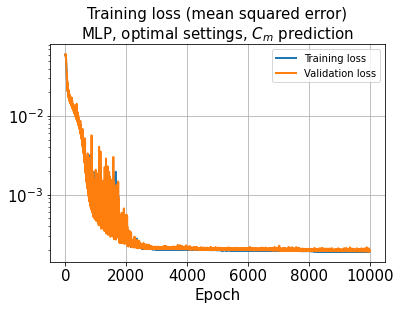

In [33]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

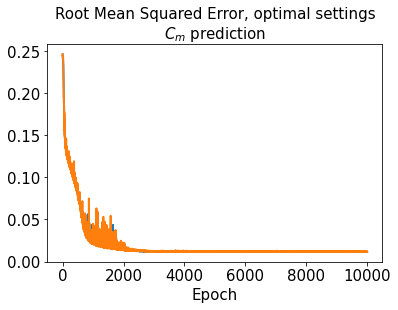

In [34]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

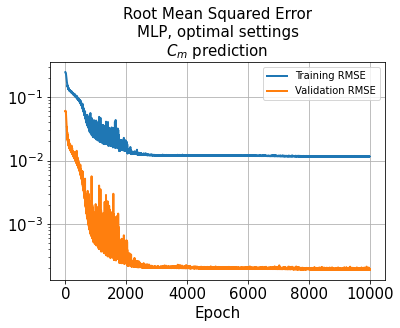

In [35]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [36]:
train_results = model.evaluate(x_train, y_train)

1094/1094 [==============================] - 3s 3ms/step - loss: 1.8666e-04 - rmse: 0.0115


In [37]:
val_results = model.evaluate(x_val, y_val)

313/313 [==============================] - 1s 3ms/step - loss: 1.9095e-04 - rmse: 0.0117


In [38]:
test_results = model.evaluate(x_test, y_test)

157/157 [==============================] - 0s 3ms/step - loss: 1.8841e-04 - rmse: 0.0115


In [39]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

157/157 [==============================] - 0s 1ms/step


In [40]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [41]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [42]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [43]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [44]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [46]:
l2_error_train = l2_error(decoded_train_, y_train)
mape_train = smape(decoded_train_, y_train)
print(l2_error_train)
print(mape_train)

0.02576132274421034
1.1573501026412931


In [47]:
l2_error_val = l2_error(decoded_val_, y_val)
mape_val= smape(decoded_val_, y_val)
print(l2_error_val)
print(mape_val)

0.02602927609045783
1.1763714815138864


In [48]:
l2_error_test = l2_error(decoded_test_, y_test)
mape_test= smape(decoded_test_, y_test)
print(l2_error_test)
print(mape_test)

0.025880034990707474
1.1597222804362874


In [49]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [50]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [51]:
model_directory = "D:\\TrainedModels\\20221229"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221229unsteadyValidation_MLP_10h_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_layers) +"layers_"+str(n_units)+"units_CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [52]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [53]:
os.chdir(storage_dir)

In [54]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [55]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [56]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [57]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [58]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [59]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [60]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

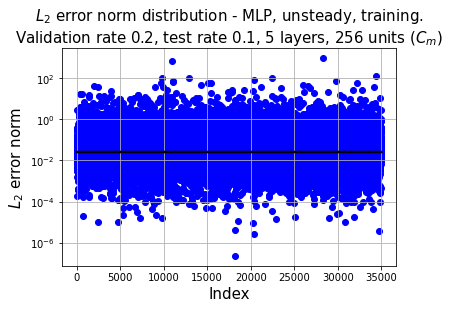

In [61]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

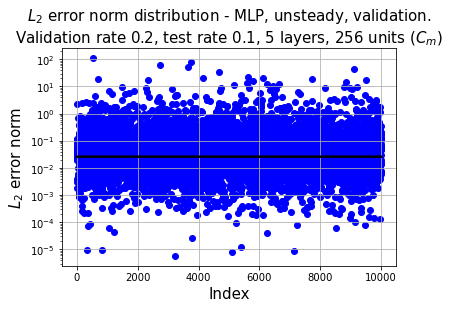

In [62]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

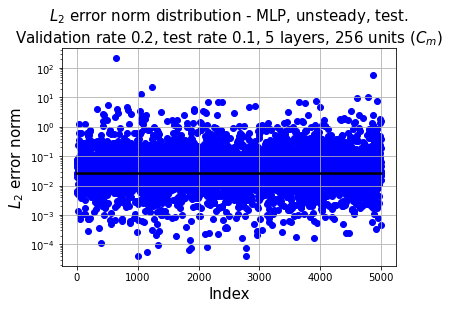

In [63]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [64]:
predicted = model.predict(x)

1563/1563 [==============================] - 2s 1ms/step


In [65]:
tTrain = t[index_train]+10
tVal = t[index_val]+10
tTest = t[index_test]+10

In [66]:
index_train.shape

(35000,)

In [67]:
max(predicted)

array([1.008003], dtype=float32)

In [68]:
l2_error(denormalize(predicted), denormalize(y))

0.035681553378924626

In [69]:
l2_error(predicted, y)

0.02582749229166162

In [70]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [71]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [72]:
iTrain.shape

(35000, 1)

In [73]:
iVal.shape

(10001, 1)

In [74]:
iTest.shape

(5001, 1)

In [75]:
52499+15002+7501

75002

In [76]:
x += 10

In [77]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_0_Cm
        savename1 = "CmComparison_NACA0018.jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([-0.05, 0.22])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0205


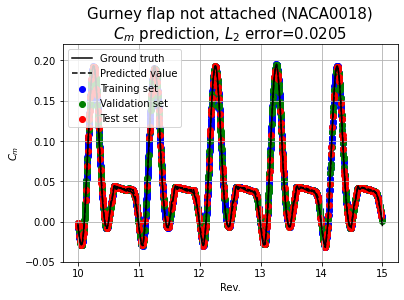

L2 error of Cm: 0.0192


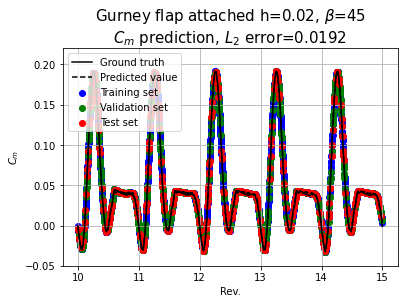

L2 error of Cm: 0.0255


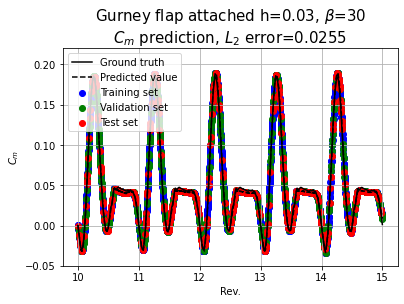

L2 error of Cm: 0.0185


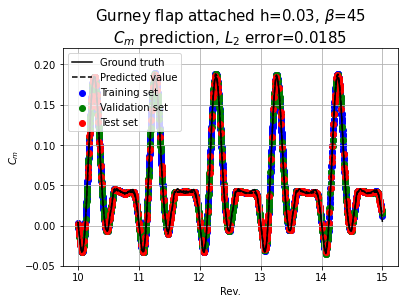

L2 error of Cm: 0.0177


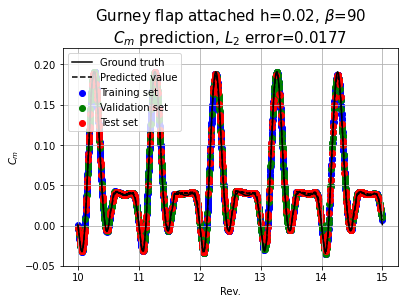

L2 error of Cm: 0.0229


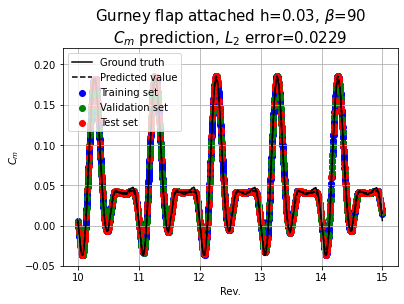

L2 error of Cm: 0.0302


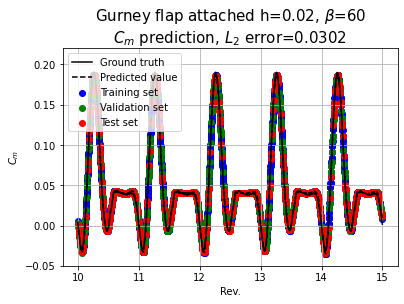

L2 error of Cm: 0.0372


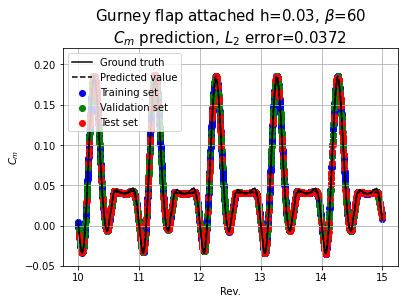

L2 error of Cm: 0.0371


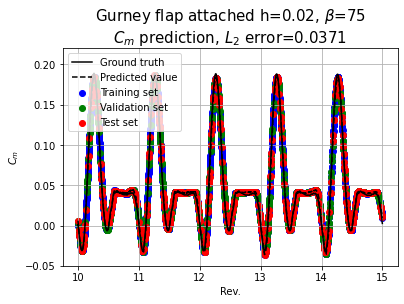

L2 error of Cm: 0.0200


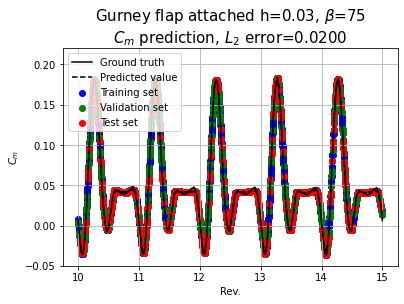

In [80]:
h = [0.02, 0.02, 0.03, 0.03,0.02, 0.03, 0.02, 0.03, 0.02, 0.03]
beta = [30, 45, 30, 45, 90, 90, 60, 60, 75, 75]
for i in range(0,10):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

In [81]:
def Cm_trainTestSplit_Plot2(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
#     title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm), 'b--', label='Predicted value')
#     plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#     plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#     plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0205


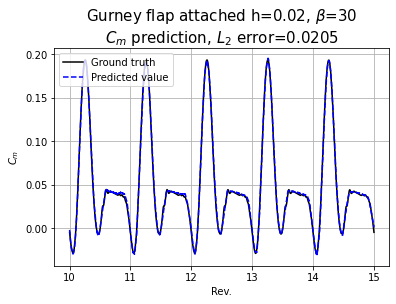

L2 error of Cm: 0.0192


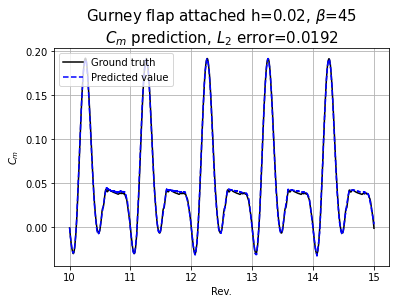

L2 error of Cm: 0.0255


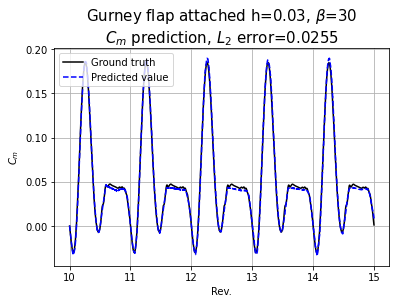

L2 error of Cm: 0.0185


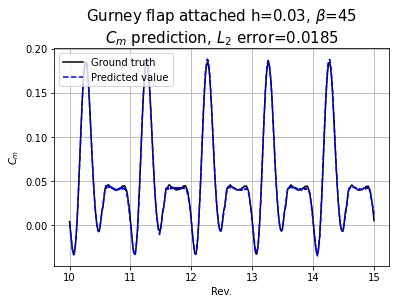

L2 error of Cm: 0.0177


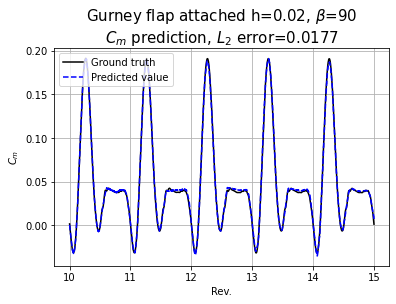

L2 error of Cm: 0.0229


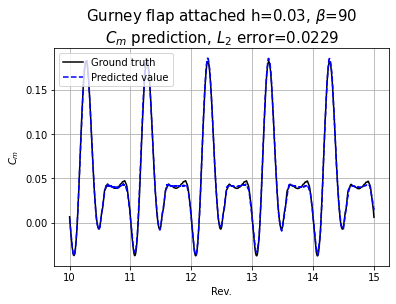

L2 error of Cm: 0.0302


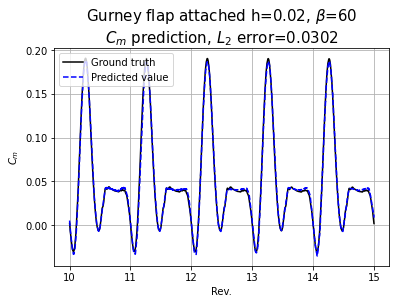

L2 error of Cm: 0.0372


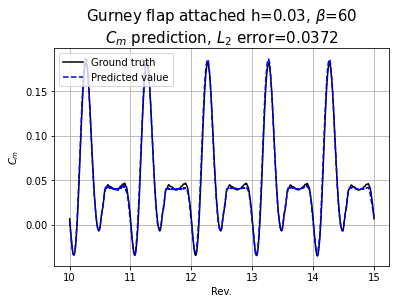

L2 error of Cm: 0.0371


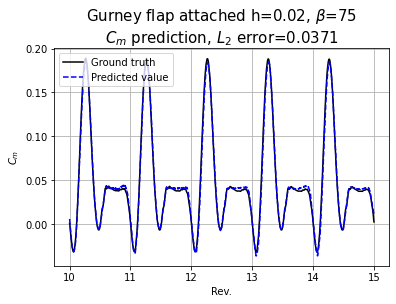

L2 error of Cm: 0.0200


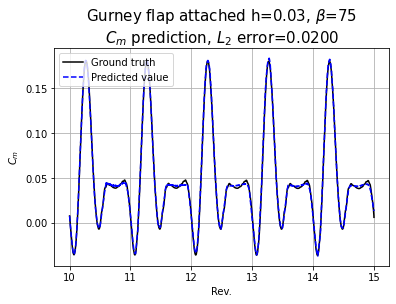

In [83]:
for i in range(0,10):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

L2 error of Cm: 0.0205


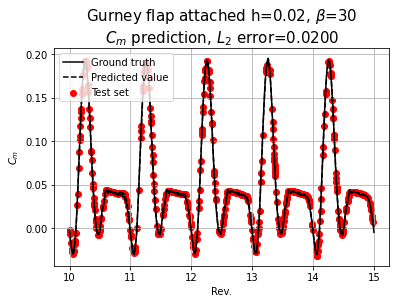

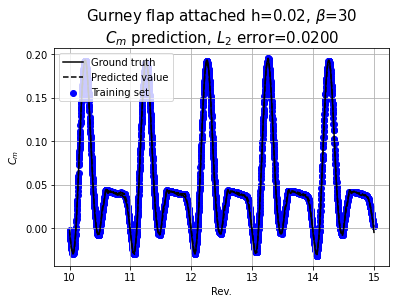

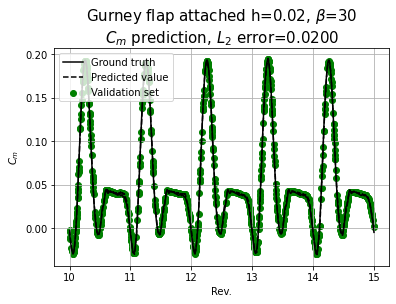

L2 error of Cm: 0.0192


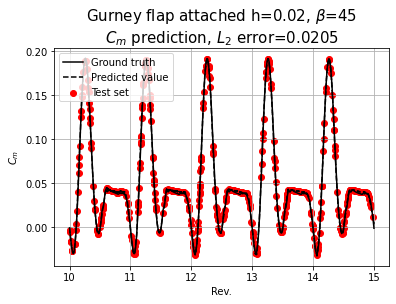

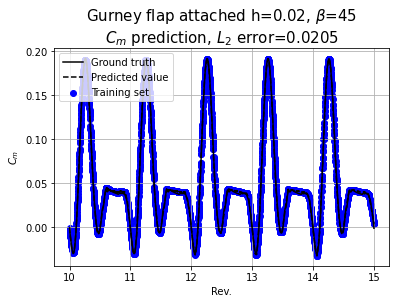

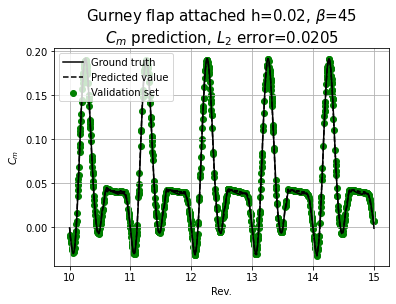

L2 error of Cm: 0.0255


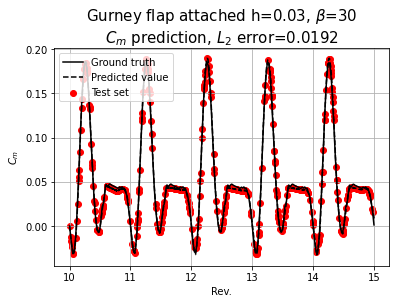

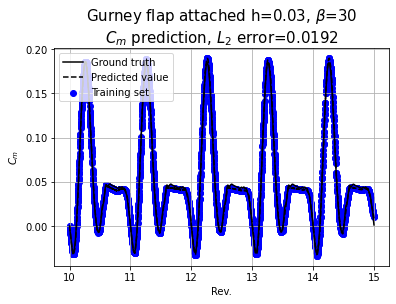

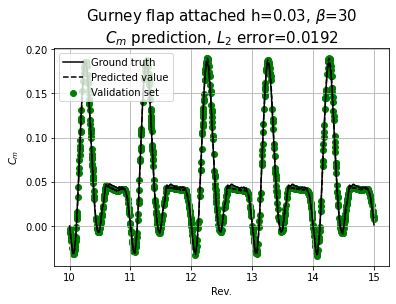

L2 error of Cm: 0.0185


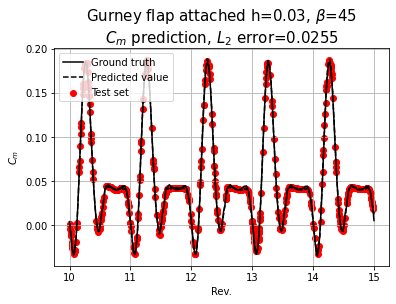

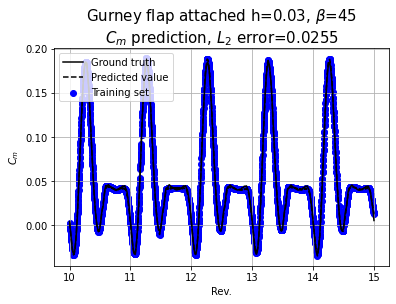

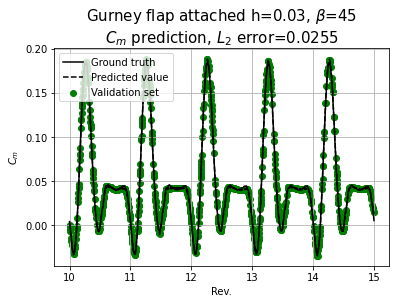

L2 error of Cm: 0.0177


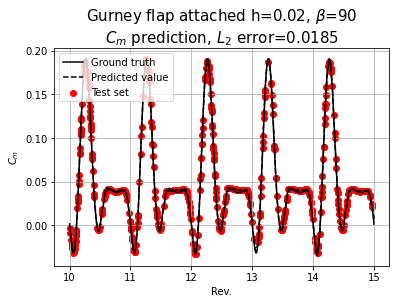

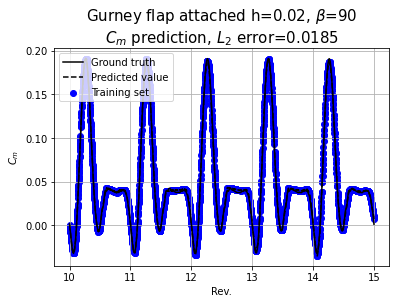

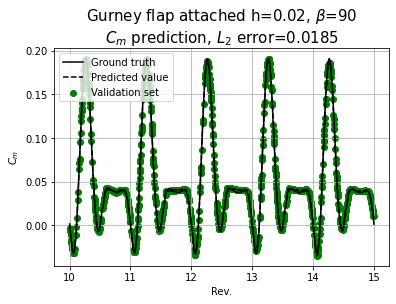

L2 error of Cm: 0.0229


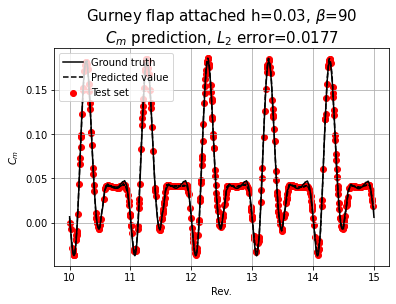

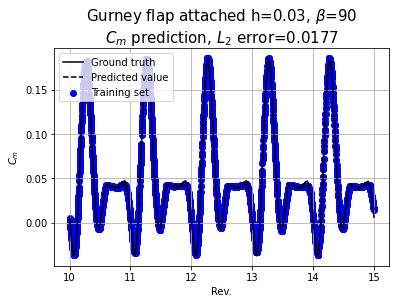

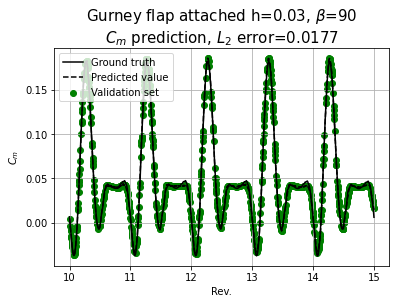

L2 error of Cm: 0.0302


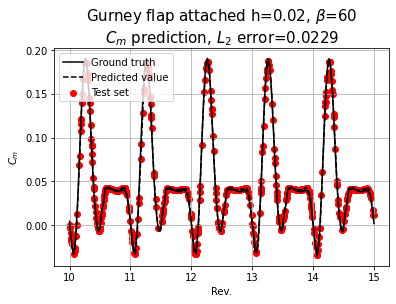

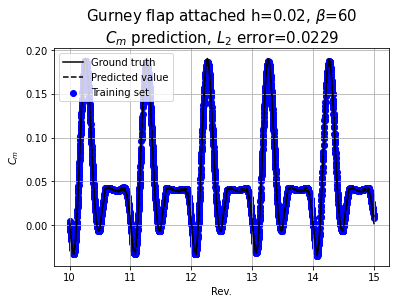

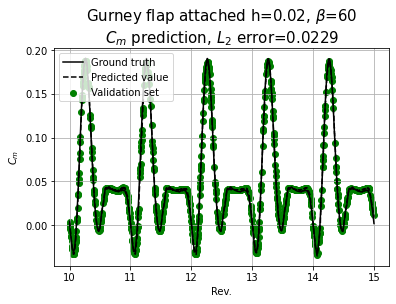

L2 error of Cm: 0.0372


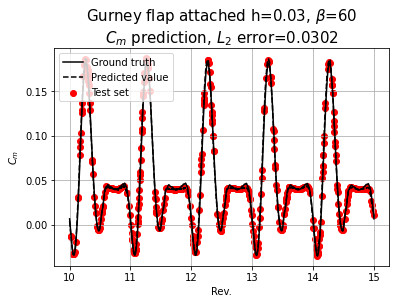

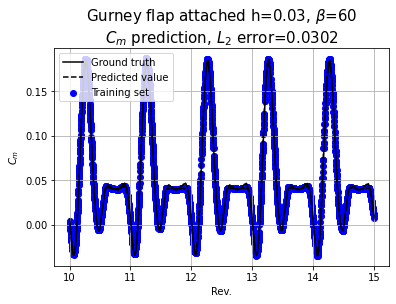

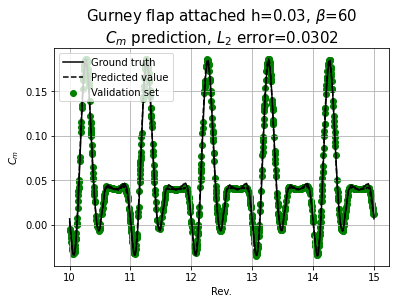

L2 error of Cm: 0.0371


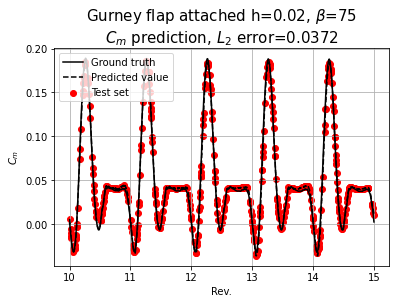

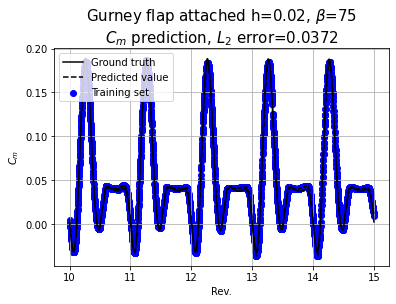

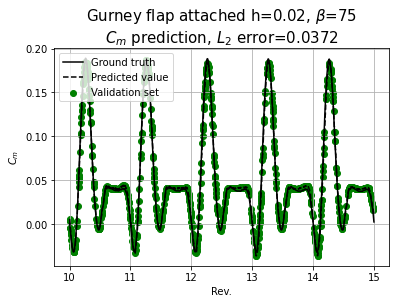

L2 error of Cm: 0.0200


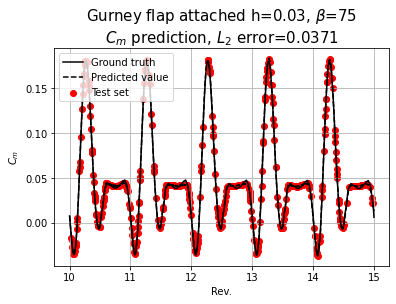

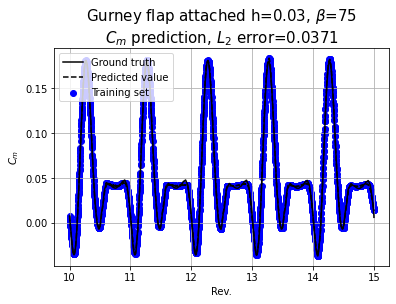

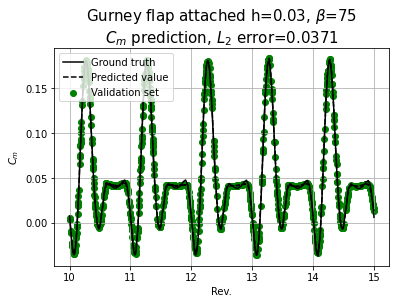

In [84]:
for i in range(0,10):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    title_Cm = title_n_Cm
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"

    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+"training.jpg"
    savename2 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+"validation.jpg"
    savename3 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+"test.jpg"
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
#     Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

    # CD graph plot
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
    plt.scatter(tTest, denormalize(iTest_), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain_), color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
#     plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal_), color='g', label='Validation set')
#     plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()